**Прогнозирование цены криптовалюты**<br>

> **Задача** <br>
Спрогнозировать цену биткоина для таймфреймов одна минута и один день




Main metric for a prediction valuation is **RMSE**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Specify a path variable (project path)
proj_path = '/content/gdrive/MyDrive/Colab Notebooks/save_data/'

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import load_model

# Data cleaning

In [4]:
# Load the data into a DataFrame
candles = pd.read_csv(proj_path + 'binance_data.csv')
candles

,open_time,open_price,high_price,low_price,close_price,volume,close_time,quote_asset_volume,trades_number,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,1678414380000,20106.82,20118.00,20101.90,20116.59,165.194330,1678414439999,3.322095e+06,4672,81.958640,1.648224e+06
1,1678414440000,20116.18,20127.96,20108.71,20125.44,191.487240,1678414499999,3.852397e+06,5402,104.695990,2.106379e+06
2,1678414500000,20125.44,20125.84,20084.04,20084.81,431.434380,1678414559999,8.672093e+06,9675,182.413620,3.666413e+06
3,1678414560000,20084.81,20094.19,20078.59,20089.34,230.222210,1678414619999,4.624388e+06,6257,123.726580,2.485277e+06
4,1678414620000,20088.85,20089.73,20067.96,20075.98,387.942880,1678414679999,7.789311e+06,7693,190.734990,3.829753e+06
...,...,...,...,...,...,...,...,...,...,...,...
1203995,1606212180000,19069.04,19094.99,19040.99,19048.09,166.041829,1606212239999,3.166864e+06,3210,69.709684,1.329408e+06
1203996,1606212240000,19048.10,19100.00,19045.98,19092.32,224.591430,1606212299999,4.286742e+06,3214,170.770636,3.259867e+06
1203997,1606212300000,19092.32,19099.94,19047.17,19062.58,162.456095,1606212359999,3.099339e+06,2967,80.073361,1.527817e+06
1203998,1606212360000,19066.65,19096.60,19062.58,19069.19,128.091541,1606212419999,2.444322e+06,3051,58.514268,1.116667e+06


In [5]:
candles.dropna(inplace=True)
candles.sort_values(by=['open_time'], inplace=True)
candles = candles.reset_index().drop(axis=1, labels='index')

In [6]:
time_df = pd.DataFrame()
time_df['diff_times'] = candles.shift(-1).iloc[:-2, 0] - candles.iloc[:-2, 6]
time_df.dropna(inplace=True)
time_df[time_df.diff_times > 1] / 60000 # find for how many minutes there was a trade stop

,diff_times
9391,60.000017
40039,252.657983
44839,60.000017
114000,79.087117
146940,90.000017
211650,150.000017
218821,284.030900
376816,270.016667
444526,120.000017
568126,0.093967


In [7]:
#Create time dataframe with trade stop time and recover time
time = pd.DataFrame(candles.iloc[time_df[time_df.diff_times > 1].index, [0]])
time = time.append(candles.iloc[time_df[time_df.diff_times > 1].index + 1, [0]])
time.sort_index(inplace=True)

#Get the date of space
time["date"] = pd.to_datetime(time["open_time"], unit='ms')

<ipython-input-7-20a61e28a53e>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  time = time.append(candles.iloc[time_df[time_df.diff_times > 1].index + 1, [0]])


In [8]:
cont_candles = candles.iloc[time.index.max():, :]

# Get features

In [9]:
#Leave only necessary data columns

#WA = "WEIGHTED AVERAGE"
OPR = "OPEN PRICE"
HPR = "HIGH PRICE"
LPR = "LOW PRICE"
CPR = "CLOSE PRICE"
VOL = "VOLUME"
TN = "TRADES NUMBER"
TAKER = "TAKER"
OTIME = "OPEN TIME"

TSIN = 'Day Time sin'
TCOS = 'Day Time cos'
DSIN = 'Week Day sin'
DCOS = 'Week Day cos'

COLUMNS = [OPR, HPR, LPR, CPR, VOL, TN, TAKER, OTIME]

In [10]:
def reparse_candle(candle):

    return [
        float(candle[1]),
        float(candle[2]),
        float(candle[3]),
        float(candle[4]),
        float(candle[5]),
        float(candle[8]),
        float(candle[9]),
        int(candle[0])
    ]

parsed_klines = pd.DataFrame(
    list(map(reparse_candle, cont_candles.values.tolist())),
    columns=COLUMNS
)

Change open_time to new form

In [11]:
#to use this remove comments in agg_to_freq_data

milliseconds_in_day = 24*60*60*1000
parsed_klines[TSIN] = np.sin(parsed_klines[OTIME] * (2 * np.pi / milliseconds_in_day))
parsed_klines[TCOS] = np.cos(parsed_klines[OTIME] * (2 * np.pi / milliseconds_in_day))
parsed_klines[DSIN] = np.sin(parsed_klines[OTIME] * (2 * np.pi / (7 * milliseconds_in_day)))
parsed_klines[DCOS] = np.cos(parsed_klines[OTIME] * (2 * np.pi / (7 * milliseconds_in_day)))
parsed_klines

,OPEN PRICE,HIGH PRICE,LOW PRICE,CLOSE PRICE,VOLUME,TRADES NUMBER,TAKER,OPEN TIME,Day Time sin,Day Time cos,Week Day sin,Week Day cos
0,50951.41,50951.47,50920.62,50931.91,7.22049,389.0,2.56967,1640322000000,0.965926,0.258819,0.884115,0.467269
1,50931.91,50931.97,50876.70,50880.00,25.65137,1185.0,9.06440,1640322060000,0.967046,0.254602,0.884406,0.466717
2,50876.73,50880.00,50837.71,50837.71,16.19787,1201.0,6.86989,1640322120000,0.968148,0.250380,0.884697,0.466166
3,50840.81,50919.27,50837.71,50909.47,22.53036,1215.0,13.97411,1640322180000,0.969231,0.246153,0.884988,0.465615
4,50909.47,50931.95,50869.08,50880.26,14.09173,788.0,4.37506,1640322240000,0.970296,0.241922,0.885278,0.465063
...,...,...,...,...,...,...,...,...,...,...,...,...
635868,19924.80,19931.91,19909.00,19911.25,262.09242,6421.0,120.41953,1678474080000,-0.978148,0.207912,0.999552,-0.029915
635869,19912.20,19912.96,19886.76,19892.08,272.13501,6677.0,133.42091,1678474140000,-0.977231,0.212178,0.999534,-0.030539
635870,19892.61,19904.63,19885.80,19895.61,279.22393,6247.0,136.15247,1678474200000,-0.976296,0.216440,0.999514,-0.031162
635871,19896.19,19896.23,19871.03,19871.03,264.10529,6622.0,126.31206,1678474260000,-0.975342,0.220697,0.999495,-0.031785


In [12]:
def find_direction(df):
  #0 if we going down, 1 if up
  df[DIR] = (df[DIF] > 0).astype(np.int32)
  return df

In [13]:
DIF = 'Difference'
DIR = 'Direction'
A_DIF = f'Absolute {DIF}'

parsed_klines[DIF] = parsed_klines[OPR].diff()
parsed_klines.dropna(inplace=True)

parsed_klines[A_DIF] = abs(parsed_klines[DIF])

#0 if we going down, 1 if up
parsed_klines = find_direction(parsed_klines)
parsed_klines

,OPEN PRICE,HIGH PRICE,LOW PRICE,CLOSE PRICE,VOLUME,TRADES NUMBER,TAKER,OPEN TIME,Day Time sin,Day Time cos,Week Day sin,Week Day cos,Difference,Absolute Difference,Direction
1,50931.91,50931.97,50876.70,50880.00,25.65137,1185.0,9.06440,1640322060000,0.967046,0.254602,0.884406,0.466717,-19.50,19.50,0
2,50876.73,50880.00,50837.71,50837.71,16.19787,1201.0,6.86989,1640322120000,0.968148,0.250380,0.884697,0.466166,-55.18,55.18,0
3,50840.81,50919.27,50837.71,50909.47,22.53036,1215.0,13.97411,1640322180000,0.969231,0.246153,0.884988,0.465615,-35.92,35.92,0
4,50909.47,50931.95,50869.08,50880.26,14.09173,788.0,4.37506,1640322240000,0.970296,0.241922,0.885278,0.465063,68.66,68.66,1
5,50885.58,50895.13,50850.00,50852.82,12.18793,945.0,3.02775,1640322300000,0.971342,0.237686,0.885567,0.464511,-23.89,23.89,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635868,19924.80,19931.91,19909.00,19911.25,262.09242,6421.0,120.41953,1678474080000,-0.978148,0.207912,0.999552,-0.029915,-3.99,3.99,0
635869,19912.20,19912.96,19886.76,19892.08,272.13501,6677.0,133.42091,1678474140000,-0.977231,0.212178,0.999534,-0.030539,-12.60,12.60,0
635870,19892.61,19904.63,19885.80,19895.61,279.22393,6247.0,136.15247,1678474200000,-0.976296,0.216440,0.999514,-0.031162,-19.59,19.59,0
635871,19896.19,19896.23,19871.03,19871.03,264.10529,6622.0,126.31206,1678474260000,-0.975342,0.220697,0.999495,-0.031785,3.58,3.58,1


# Functions for a prediction process

In [14]:
import numpy as np

def agg_to_freq_data(df, mins: int):
    """
    Aggregate data from data per minute to data per n-mins
    :param df:
    :param mins: int frequency in minutes
    :return: df with data for n-mins
    """
    df["date"] = pd.to_datetime(df[OTIME], unit='ms')

    # docs about freq https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
    df = df.groupby(pd.Grouper(key='date', freq=f'{mins}min')).agg({OTIME: np.min, OPR: 'first',
                                                                    HPR: np.max, LPR: np.min,
                                                                    CPR: 'last', VOL: np.sum,
                                                                    TN: np.sum, TAKER: np.sum,
                                                                    DIF: np.sum,
                                                                    A_DIF: np.sum,
                                                                    TSIN: 'first', TCOS:'first',
                                                                    DSIN: 'first', DCOS:'first'
                                                                    })
    df = find_direction(df)
    df[A_DIF] = abs(df[DIF])

    df = df.reset_index()
    return df

In [15]:
from sklearn.metrics import r2_score

def output_stats(y_pred, y_true):
  mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true))
  wape = 1 - np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)

  mae = np.mean(np.abs(y_pred - y_true))
  mpe = np.mean((y_pred - y_true) / y_true)
  rmse = np.mean((y_pred - y_true)**2)**.5
  corr = np.corrcoef(y_pred, y_true)[0, 1]
  r2_sc = r2_score(y_true, y_pred)

  #mins = np.amin(np.hstack([y_pred[:, None], y_true[:, None]]), axis=1)
  #maxs = np.amax(np.hstack([y_pred[:, None], y_true[:, None]]), axis=1)
  #minmax = 1 - np.mean(mins/maxs)

  print(f' mape: {mape},\nwape: {wape},\nmae: {mae},\n mpe: {mpe},\n rmse: {rmse},\n corr: {corr},\nr2_score:{r2_sc} minmax: ')

  return mape, wape, mae, mpe, rmse, corr, r2_sc

In [16]:
parsed_klines = agg_to_freq_data(parsed_klines, 1)

In [17]:
scaler = MinMaxScaler()

In [18]:
# Train the Scaler with training data and smooth data
def smooth_data(arr, smoothing_window_size=700000):
  for di in range(0,arr.size,smoothing_window_size):
    scaler.fit(arr[di:di+smoothing_window_size,:])
    arr[di:di+smoothing_window_size,:] = scaler.transform(arr[di:di+smoothing_window_size,:])

  # You normalize the last bit of remaining data
  if di+smoothing_window_size < arr.size:
    scaler.fit(arr[di+smoothing_window_size:,:])
    arr[di+smoothing_window_size:,:] = scaler.transform(arr[di+smoothing_window_size:,:])

  return arr


def unsmooth_data(arr, smoothing_window_size=700000):
  for di in range(0,arr.size,smoothing_window_size):
    arr[di:di+smoothing_window_size,:] = scaler.inverse_transform(arr[di:di+smoothing_window_size,:])

  # You normalize the last bit of remaining data
  if di+smoothing_window_size < arr.size:
    arr[di+smoothing_window_size:,:] = scaler.inverse_transform(arr[di+smoothing_window_size:,:])

  return arr


def get_and_smooth(df, smoothing_window_size=700000):
  for col in df.columns:
    if col in [TSIN, TCOS, DSIN, DCOS, DIF]:
      continue
    smooth_data(df[col].values.reshape(-1, 1), smoothing_window_size).reshape(-1)

  return df

In [19]:
#Functions to divide data on features and outs
#If features number is 1
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X, y = [], []
  for i in range(len(df_as_np) - window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)

  return np.array(X), np.array(y)


#If features number > 1
def df_to_X_y_n_feat(df, window_size=5):
  df_as_np = df.to_numpy()
  X, y = [], []
  for i in range(len(df_as_np) - window_size):
    row = [a for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)

  return np.array(X), np.array(y)

In [20]:
def build_compile_fit_model(conv_neurons, kernel_size, lstm_neurons,
                            lr, checkpoint, n_epochs,
                            X_train, y_train, X_val, y_val):
  model = Sequential()
  model.add(InputLayer((X_train.shape[1], X_train.shape[2])))
  model.add(Conv1D(conv_neurons, kernel_size=kernel_size))
  model.add(Flatten())
  model.add(Dense(1, 'linear'))

  print(X_train.shape[1], X_train.shape[2])
  print(model.summary())

  cp = ModelCheckpoint(checkpoint, save_best_only=True)
  model.compile(loss='mse', optimizer=Adam(learning_rate=lr), metrics=[RootMeanSquaredError()])

  modelfit = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=n_epochs, callbacks=[cp])
  return modelfit

Data was divided on three parts: training, validation and test. (60% - 20% - 20%, respectively)


In [21]:
def build_continuous_samples(X, y):
  train_size = int(X.shape[0] * 0.6)
  val_size = int(X.shape[0] * 0.2)

  X_train, y_train = X[:train_size], y[:train_size]
  X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
  X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

  return X_train, y_train, X_val, y_val, X_test, y_test


def build_batch_samples(X, y):
  # data -> [0, 1, 2, 3, 4], [5, 6, 7, 8, 9] ...
  # train -> [0, 2, 4], [5, 7, 9] ...
  # val -> [1], [6] ...
  # test -> [3], [8] ...
  train_index = [i for i in range(X.shape[0]) if (i % 5) % 2 == 0]
  val_index = [i for i in range(X.shape[0]) if i % 5 == 1]
  test_index = [i for i in range(X.shape[0]) if i % 5 == 3]

  X_train, y_train = X[train_index], y[train_index]
  X_val, y_val = X[val_index], y[val_index]
  X_test, y_test = X[test_index], y[test_index]

  return X_train, y_train, X_val, y_val, X_test, y_test


def build_data(parsed_klines, mins,
               df_start=0, df_size=200000,
               columns=[CPR, HPR, LPR, VOL, TN, TAKER],
               smoothing_window_size=700000,
               window_size=150, batch=False):
  df_n_mins = parsed_klines[df_start:df_start+df_size].copy()
  df_n_mins = agg_to_freq_data(df_n_mins, mins)
  df_n_mins.index = pd.to_datetime(df_n_mins['date'], format='%d.%m.%Y %H:%M:%S')

  print("WRONG DATA", df_n_mins[df_n_mins[OPR] < 1])
  if df_n_mins[df_n_mins[OPR] < 1].shape[0] > 0:
    return

  df_n_mins = df_n_mins[columns]
  df_n_mins = get_and_smooth(df_n_mins, smoothing_window_size)
  X_n, y_n = df_to_X_y_n_feat(df_n_mins, window_size)
  y_n = y_n[:, 0]

  if batch:
    return build_batch_samples(X_n, y_n)
  else:
    return build_continuous_samples(X_n, y_n)

In [22]:
def build_loss_plot(modelfit):
  plt.plot(modelfit.history['loss'],'r',linewidth=2, label='Training loss')
  plt.plot(modelfit.history['val_loss'], 'g',linewidth=2, label='Validation loss')
  plt.title('CNN - Bitcoin price prediction')
  plt.xlabel('Epochs numbers')
  plt.ylabel('MSE numbers')
  plt.legend()
  plt.show()

In [23]:
def get_predictions(model, X, y, name, drop_nulls=False, unsmooth=False):
  predictions = model.predict(X).flatten()

  if unsmooth:
    predictions = unsmooth_data(predictions.reshape(-1, 1)).reshape(-1)
    y = unsmooth_data(y.copy().reshape(-1, 1)).reshape(-1)

  results = pd.DataFrame(data={f'{name} Predictions': predictions, 'Actuals':y})
  print(results)

  plt.plot(results[f'{name} Predictions'][:150], label='Prediction')
  plt.plot(results['Actuals'][:150], label='Actual')
  plt.legend()
  plt.show()

  if drop_nulls:
    results.loc[results['Actuals'] == 0, 'Actuals'] = results[results['Actuals'] == 0][f'{name} Predictions']
    return output_stats(results[f'{name} Predictions'], results['Actuals'])
  else:
    return output_stats(results[f'{name} Predictions'], results['Actuals'])

# Start to predict

## Dataset with window normalization

Firstly, let's divide dataset with a window and normalize the data of each part. This probably can help to avoid too small normalized values. <br>
Then train the model on this dataset.<br>
Instead of using whole dataset for dividing on training, validation and test parts I use only 200000 because of reaching the google colab limit. <br>

The image shows X dataset. One row of this dataset contains k rows of previous consistent data.

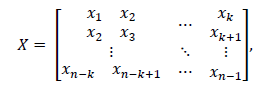

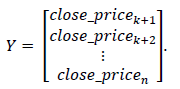

In [ ]:
conv_neurons, kernel_size, mins = 24, 2, 1
X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(
    parsed_klines, 1,
    df_start=430000,
    smoothing_window_size=2500)
build_compile_fit_model(conv_neurons, kernel_size,
                        24, 0.001,
                        f'model_{mins}_min/', 10,
                        X_n_train, y_n_train, X_n_val, y_n_val)
model_1_min = load_model(f'model_{mins}_min/')

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER, Difference, Absolute Difference, Direction]
Index: []
150 6
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 149, 24)           312       
                                                                 
 flatten (Flatten)           (None, 3576)              0         
                                                                 
 dense (Dense)               (None, 1)                 3577      
                                                                 
Total params: 3,889
Trainable params: 3,889
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3745/3748 [============================>.] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0365

3748/3748 [==============================] - 22s 6ms/step - loss: 0.0013 - root_mean_squared_error: 0.0365 - val_loss: 4.9203e-04 - val_root_mean_squared_error: 0.0222
Epoch 2/10
3739/3748 [============================>.] - ETA: 0s - loss: 4.9835e-04 - root_mean_squared_error: 0.0223

3748/3748 [==============================] - 18s 5ms/step - loss: 4.9819e-04 - root_mean_squared_error: 0.0223 - val_loss: 4.6448e-04 - val_root_mean_squared_error: 0.0216
Epoch 3/10
3748/3748 [==============================] - 17s 4ms/step - loss: 4.7937e-04 - root_mean_squared_error: 0.0219 - val_loss: 4.7372e-04 - val_root_mean_squared_error: 0.0218
Epoch 4/10
3743/3748 [============================>.] - ETA: 0s - loss: 4.7005e-04 - root_mean_squared_error: 0.0217

3748/3748 [==============================] - 18s 5ms/step - loss: 4.7011e-04 - root_mean_squared_error: 0.0217 - val_loss: 4.5508e-04 - val_root_mean_squared_error: 0.0213
Epoch 5/10
3739/3748 [============================>.] - ETA: 0s - loss: 4.5546e-04 - root_mean_squared_error: 0.0213

3748/3748 [==============================] - 20s 5ms/step - loss: 4.5518e-04 - root_mean_squared_error: 0.0213 - val_loss: 4.5313e-04 - val_root_mean_squared_error: 0.0213
Epoch 6/10
3748/3748 [==============================] - 17s 5ms/step - loss: 4.4838e-04 - root_mean_squared_error: 0.0212 - val_loss: 5.3603e-04 - val_root_mean_squared_error: 0.0232
Epoch 7/10
3748/3748 [==============================] - 17s 4ms/step - loss: 4.3787e-04 - root_mean_squared_error: 0.0209 - val_loss: 6.8998e-04 - val_root_mean_squared_error: 0.0263
Epoch 8/10
3748/3748 [==============================] - 17s 5ms/step - loss: 4.3037e-04 - root_mean_squared_error: 0.0207 - val_loss: 5.0283e-04 - val_root_mean_squared_error: 0.0224
Epoch 9/10
3743/3748 [============================>.] - ETA: 0s - loss: 4.3202e-04 - root_mean_squared_error: 0.0208

3748/3748 [==============================] - 18s 5ms/step - loss: 4.3197e-04 - root_mean_squared_error: 0.0208 - val_loss: 3.8191e-04 - val_root_mean_squared_error: 0.0195
Epoch 10/10
3748/3748 [==============================] - 19s 5ms/step - loss: 4.2675e-04 - root_mean_squared_error: 0.0207 - val_loss: 4.8895e-04 - val_root_mean_squared_error: 0.0221


3748/3748 [==============================] - 10s 3ms/step
        Train Predictions   Actuals
0                0.706465  0.712149
1                0.716725  0.723283
2                0.722139  0.716055
3                0.715255  0.717998
4                0.712116  0.697527
...                   ...       ...
119905           0.040727  0.030137
119906           0.041565  0.027616
119907           0.036398  0.033134
119908           0.053457  0.031994
119909           0.040604  0.021807

[119910 rows x 2 columns]


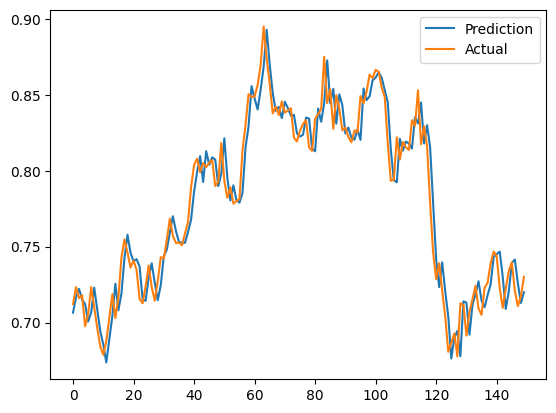

 mape: inf,
wape: 0.9780047602755169,
mae: 0.011037329785576096,
 mpe: nan,
 rmse: 0.019119667840866255,
 corr: 0.9967644957375423,
r2_score:0.9935196714974578 minmax: 


(inf,
 0.9780047602755169,
 0.011037329785576096,
 nan,
 0.019119667840866255,
 0.9967644957375423,
 0.9935196714974578)

In [25]:
get_predictions(model_1_min, X_n_train, y_n_train, 'Train')

1250/1250 [==============================] - 3s 2ms/step
       Val Predictions   Actuals
0             0.029028  0.026529
1             0.036791  0.034063
2             0.039046  0.033267
3             0.038133  0.043401
4             0.053415  0.052872
...                ...       ...
39965         0.323348  0.325957
39966         0.329233  0.301638
39967         0.304774  0.320010
39968         0.318437  0.314244
39969         0.318212  0.319466

[39970 rows x 2 columns]


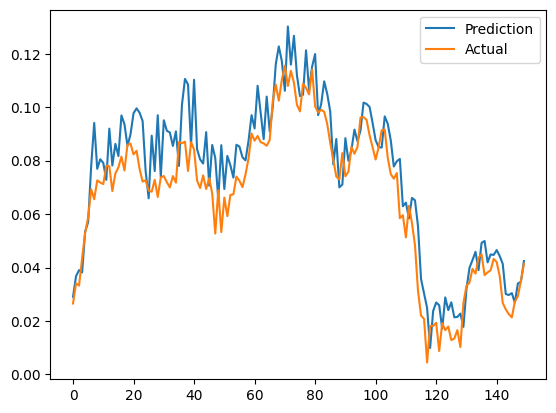

 mape: inf,
wape: 0.978963722681232,
mae: 0.011109689577832952,
 mpe: inf,
 rmse: 0.019542553414536465,
 corr: 0.9968742261314941,
r2_score:0.9937417093896204 minmax: 


(inf,
 0.978963722681232,
 0.011109689577832952,
 inf,
 0.019542553414536465,
 0.9968742261314941,
 0.9937417093896204)

In [26]:
get_predictions(model_1_min, X_n_val, y_n_val, 'Val')

1250/1250 [==============================] - 6s 5ms/step
       Test Predictions   Actuals
0              0.321152  0.316143
1              0.319183  0.295802
2              0.296816  0.294252
3              0.295695  0.295746
4              0.297005  0.287425
...                 ...       ...
39965          0.736036  0.726782
39966          0.713474  0.720712
39967          0.692465  0.690740
39968          0.681689  0.702100
39969          0.685639  0.704437

[39970 rows x 2 columns]


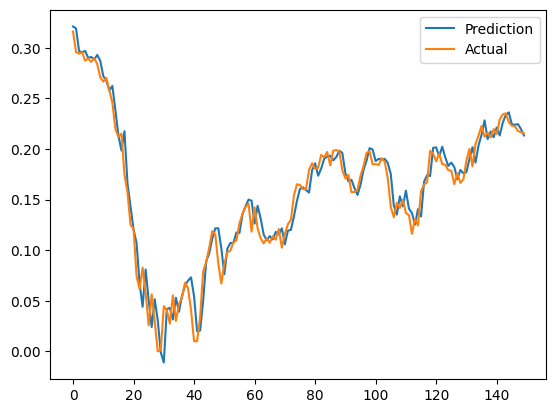

 mape: inf,
wape: 0.9782985872596396,
mae: 0.011016979920503833,
 mpe: nan,
 rmse: 0.019412927402687234,
 corr: 0.9968831694345213,
r2_score:0.9937731489342906 minmax: 


(inf,
 0.9782985872596396,
 0.011016979920503833,
 nan,
 0.019412927402687234,
 0.9968831694345213,
 0.9937731489342906)

In [29]:
#smooth_data(parsed_klines.copy()[CPR][430000:630000].values.reshape(-1, 1), smoothing_window_size=2500)
get_predictions(model_1_min, X_n_test, y_n_test, 'Test', unsmooth=False)

## Dataset normalized without a window

Now let's check results on the dataset which is normalized without any division with a window

In [35]:
conv_neurons, kernel_size, mins = 24, 2, 1
X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(
    parsed_klines, 1,
    df_start=430000
    )
build_compile_fit_model(conv_neurons, kernel_size,
                        24, 0.001,
                        f'model_{mins}_min/', 10,
                        X_n_train, y_n_train, X_n_val, y_n_val)
model_1_min = load_model(f'model_{mins}_min/')

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER, Difference, Absolute Difference, Direction]
Index: []
150 6
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 149, 24)           312       
                                                                 
 flatten_3 (Flatten)         (None, 3576)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3577      
                                                                 
Total params: 3,889
Trainable params: 3,889
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3747/3748 [============================>.] - ETA: 0s - loss: 1.5049e-04 - root_mean_squared_error: 0.0123

3748/3748 [==============================] - 22s 6ms/step - loss: 1.5049e-04 - root_mean_squared_error: 0.0123 - val_loss: 2.3132e-04 - val_root_mean_squared_error: 0.0152
Epoch 2/10
3745/3748 [============================>.] - ETA: 0s - loss: 2.5266e-05 - root_mean_squared_error: 0.0050

3748/3748 [==============================] - 17s 5ms/step - loss: 2.5265e-05 - root_mean_squared_error: 0.0050 - val_loss: 2.0369e-05 - val_root_mean_squared_error: 0.0045
Epoch 3/10
3748/3748 [==============================] - 17s 5ms/step - loss: 1.7545e-05 - root_mean_squared_error: 0.0042 - val_loss: 2.2940e-05 - val_root_mean_squared_error: 0.0048
Epoch 4/10
3748/3748 [==============================] - 17s 5ms/step - loss: 1.2023e-05 - root_mean_squared_error: 0.0035 - val_loss: 2.9733e-05 - val_root_mean_squared_error: 0.0055
Epoch 5/10
3743/3748 [============================>.] - ETA: 0s - loss: 4.9481e-05 - root_mean_squared_error: 0.0070

3748/3748 [==============================] - 18s 5ms/step - loss: 4.9430e-05 - root_mean_squared_error: 0.0070 - val_loss: 1.2814e-05 - val_root_mean_squared_error: 0.0036
Epoch 6/10
3748/3748 [==============================] - 20s 5ms/step - loss: 4.6156e-06 - root_mean_squared_error: 0.0021 - val_loss: 5.7925e-05 - val_root_mean_squared_error: 0.0076
Epoch 7/10
3734/3748 [============================>.] - ETA: 0s - loss: 7.4259e-06 - root_mean_squared_error: 0.0027

3748/3748 [==============================] - 18s 5ms/step - loss: 7.4090e-06 - root_mean_squared_error: 0.0027 - val_loss: 4.9187e-06 - val_root_mean_squared_error: 0.0022
Epoch 8/10
3748/3748 [==============================] - 17s 5ms/step - loss: 7.5101e-06 - root_mean_squared_error: 0.0027 - val_loss: 7.0948e-05 - val_root_mean_squared_error: 0.0084
Epoch 9/10
3748/3748 [==============================] - 17s 5ms/step - loss: 6.3055e-06 - root_mean_squared_error: 0.0025 - val_loss: 1.1411e-05 - val_root_mean_squared_error: 0.0034
Epoch 10/10
3748/3748 [==============================] - 17s 5ms/step - loss: 9.0968e-06 - root_mean_squared_error: 0.0030 - val_loss: 4.0599e-05 - val_root_mean_squared_error: 0.0064


1250/1250 [==============================] - 6s 4ms/step
       Test Predictions   Actuals
0              0.759247  0.760010
1              0.758615  0.758511
2              0.757842  0.758397
3              0.758112  0.758507
4              0.757581  0.757894
...                 ...       ...
39965          0.721079  0.722090
39966          0.721386  0.721857
39967          0.721302  0.720709
39968          0.718423  0.721144
39969          0.719299  0.721234

[39970 rows x 2 columns]


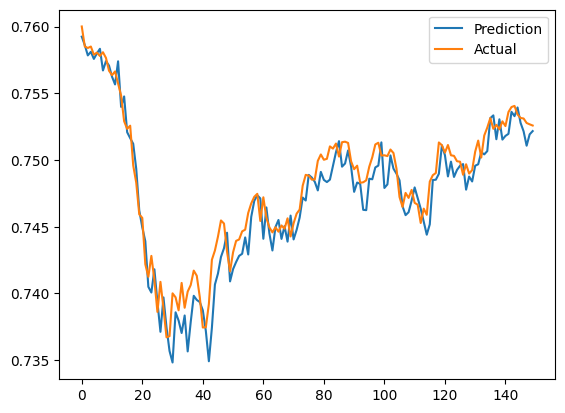

 mape: 0.0017760819984868757,
wape: 0.9982119632028654,
mae: 0.00141073264386876,
 mpe: -0.0010942160691482627,
 rmse: 0.002008819042230737,
 corr: 0.9998456634828675,
r2_score:0.9996197585719686 minmax: 


(0.0017760819984868757,
 0.9982119632028654,
 0.00141073264386876,
 -0.0010942160691482627,
 0.002008819042230737,
 0.9998456634828675,
 0.9996197585719686)

In [33]:
smooth_data(parsed_klines.copy()[CPR][430000:630000].values.reshape(-1, 1))
get_predictions(model_1_min, X_n_test, y_n_test, 'Test', unsmooth=False)

As we can see the prediction on the dataset which is normalized by parts is worse than the dataset which is normalized without any division.<br>



> RMSE fot the first one is **0.019412**<br>
RMSE for the second one is **0.002008**

So, let's use the second dataset for the next predictions

## Let's find better hyperparameters

### Firstly, find the amount of the epochs

In [46]:
conv_neurons, kernel_size, mins = 24, 2, 1
X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(
    parsed_klines, 1,
    df_start=430000
    )
modelfit = build_compile_fit_model(conv_neurons, kernel_size,
                        24, 0.001,
                        f'model_{mins}_min/', 30,
                        X_n_train, y_n_train, X_n_val, y_n_val)
model_1_min = load_model(f'model_{mins}_min/')

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER, Difference, Absolute Difference, Direction]
Index: []
150 6
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 149, 24)           312       
                                                                 
 flatten_10 (Flatten)        (None, 3576)              0         
                                                                 
 dense_10 (Dense)            (None, 1)                 3577      
                                                                 
Total params: 3,889
Trainable params: 3,889
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
3747/3748 [============================>.] - ETA: 0s - loss: 2.6259e-04 - root_mean_squared_error: 0.0162

3748/3748 [==============================] - 24s 6ms/step - loss: 2.6258e-04 - root_mean_squared_error: 0.0162 - val_loss: 2.3577e-04 - val_root_mean_squared_error: 0.0154
Epoch 2/30
3748/3748 [==============================] - 17s 4ms/step - loss: 2.8539e-05 - root_mean_squared_error: 0.0053 - val_loss: 7.8270e-04 - val_root_mean_squared_error: 0.0280
Epoch 3/30
3746/3748 [============================>.] - ETA: 0s - loss: 1.6571e-05 - root_mean_squared_error: 0.0041

3748/3748 [==============================] - 17s 5ms/step - loss: 1.6572e-05 - root_mean_squared_error: 0.0041 - val_loss: 2.8802e-05 - val_root_mean_squared_error: 0.0054
Epoch 4/30
3748/3748 [==============================] - 17s 5ms/step - loss: 1.1422e-05 - root_mean_squared_error: 0.0034 - val_loss: 3.2166e-05 - val_root_mean_squared_error: 0.0057
Epoch 5/30
3735/3748 [============================>.] - ETA: 0s - loss: 2.5635e-05 - root_mean_squared_error: 0.0051

3748/3748 [==============================] - 17s 5ms/step - loss: 2.5560e-05 - root_mean_squared_error: 0.0051 - val_loss: 2.3169e-05 - val_root_mean_squared_error: 0.0048
Epoch 6/30
3748/3748 [==============================] - 19s 5ms/step - loss: 7.2601e-06 - root_mean_squared_error: 0.0027 - val_loss: 2.6407e-05 - val_root_mean_squared_error: 0.0051
Epoch 7/30
3748/3748 [==============================] - 17s 4ms/step - loss: 7.7771e-06 - root_mean_squared_error: 0.0028 - val_loss: 4.8880e-05 - val_root_mean_squared_error: 0.0070
Epoch 8/30
3739/3748 [============================>.] - ETA: 0s - loss: 8.1804e-06 - root_mean_squared_error: 0.0029

3748/3748 [==============================] - 17s 5ms/step - loss: 8.1680e-06 - root_mean_squared_error: 0.0029 - val_loss: 9.7980e-06 - val_root_mean_squared_error: 0.0031
Epoch 9/30
3733/3748 [============================>.] - ETA: 0s - loss: 1.0531e-05 - root_mean_squared_error: 0.0032

3748/3748 [==============================] - 17s 5ms/step - loss: 1.0507e-05 - root_mean_squared_error: 0.0032 - val_loss: 7.4940e-06 - val_root_mean_squared_error: 0.0027
Epoch 10/30
3738/3748 [============================>.] - ETA: 0s - loss: 6.6971e-06 - root_mean_squared_error: 0.0026

3748/3748 [==============================] - 18s 5ms/step - loss: 6.6880e-06 - root_mean_squared_error: 0.0026 - val_loss: 3.9666e-06 - val_root_mean_squared_error: 0.0020
Epoch 11/30
3748/3748 [==============================] - 17s 5ms/step - loss: 7.2443e-06 - root_mean_squared_error: 0.0027 - val_loss: 2.3663e-05 - val_root_mean_squared_error: 0.0049
Epoch 12/30
3748/3748 [==============================] - 19s 5ms/step - loss: 5.6076e-06 - root_mean_squared_error: 0.0024 - val_loss: 8.2447e-06 - val_root_mean_squared_error: 0.0029
Epoch 13/30
3748/3748 [==============================] - 19s 5ms/step - loss: 8.1347e-06 - root_mean_squared_error: 0.0029 - val_loss: 9.3305e-06 - val_root_mean_squared_error: 0.0031
Epoch 14/30
3738/3748 [============================>.] - ETA: 0s - loss: 1.9967e-05 - root_mean_squared_error: 0.0045

3748/3748 [==============================] - 18s 5ms/step - loss: 1.9926e-05 - root_mean_squared_error: 0.0045 - val_loss: 3.2176e-06 - val_root_mean_squared_error: 0.0018
Epoch 15/30
3748/3748 [==============================] - 17s 4ms/step - loss: 4.2004e-06 - root_mean_squared_error: 0.0020 - val_loss: 1.4078e-05 - val_root_mean_squared_error: 0.0038
Epoch 16/30
3748/3748 [==============================] - 17s 5ms/step - loss: 5.2793e-06 - root_mean_squared_error: 0.0023 - val_loss: 1.2092e-05 - val_root_mean_squared_error: 0.0035
Epoch 17/30
3748/3748 [==============================] - 17s 5ms/step - loss: 9.5770e-06 - root_mean_squared_error: 0.0031 - val_loss: 1.2980e-05 - val_root_mean_squared_error: 0.0036
Epoch 18/30
3748/3748 [==============================] - 17s 5ms/step - loss: 4.6955e-06 - root_mean_squared_error: 0.0022 - val_loss: 4.2079e-06 - val_root_mean_squared_error: 0.0021
Epoch 19/30
3748/3748 [==============================] - 16s 4ms/step - loss: 5.2970e-06 - r

3748/3748 [==============================] - 17s 5ms/step - loss: 9.0920e-06 - root_mean_squared_error: 0.0030 - val_loss: 2.7883e-06 - val_root_mean_squared_error: 0.0017
Epoch 28/30
3748/3748 [==============================] - 17s 4ms/step - loss: 3.3710e-06 - root_mean_squared_error: 0.0018 - val_loss: 5.7753e-05 - val_root_mean_squared_error: 0.0076
Epoch 29/30
3748/3748 [==============================] - 16s 4ms/step - loss: 9.6500e-06 - root_mean_squared_error: 0.0031 - val_loss: 3.0832e-05 - val_root_mean_squared_error: 0.0056
Epoch 30/30
3748/3748 [==============================] - 17s 4ms/step - loss: 3.8214e-06 - root_mean_squared_error: 0.0020 - val_loss: 4.0104e-05 - val_root_mean_squared_error: 0.0063


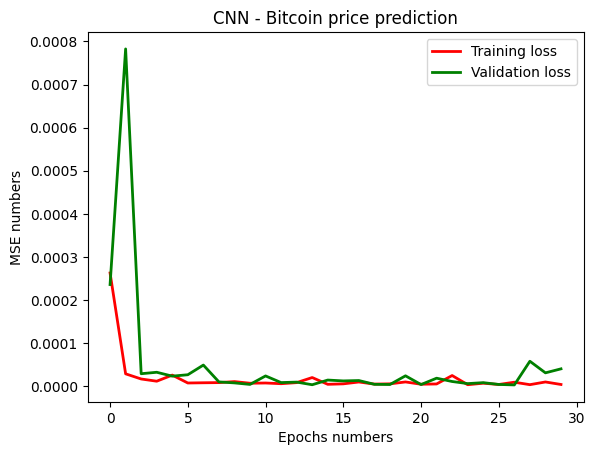

In [47]:
build_loss_plot(modelfit)

Seems like 15 epochs is enough. After loss stops shrinking

### Find amount of neurons and kernel_size

In [ ]:
mins = 1
X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(
    parsed_klines, mins,
    df_start=430000,
    columns=[OPR, HPR, LPR, VOL, TN, TAKER],
    smoothing_window_size=200000
)
smooth_data(parsed_klines[OPR][430000:630000].copy().values.reshape(-1, 1), smoothing_window_size=200000)

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER, Difference, Direction, Absolute Difference]
Index: []


array([[0.37757914],
       [0.37837099],
       [0.37954641],
       ...,
       [0.72155641],
       [0.72057535],
       [0.72094865]])

150 6
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 149, 4)            52        
                                                                 
 flatten_7 (Flatten)         (None, 596)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 597       
                                                                 
Total params: 649
Trainable params: 649
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3742/3748 [============================>.] - ETA: 0s - loss: 3.6055e-04 - root_mean_squared_error: 0.0190

3748/3748 [==============================] - 20s 5ms/step - loss: 3.6014e-04 - root_mean_squared_error: 0.0190 - val_loss: 3.9743e-04 - val_root_mean_squared_error: 0.0199
Epoch 2/20
3745/3748 [============================>.] - ETA: 0s - loss: 3.6792e-05 - root_mean_squared_error: 0.0061

3748/3748 [==============================] - 22s 6ms/step - loss: 3.6780e-05 - root_mean_squared_error: 0.0061 - val_loss: 8.7558e-05 - val_root_mean_squared_error: 0.0094
Epoch 3/20
3737/3748 [============================>.] - ETA: 0s - loss: 2.0490e-05 - root_mean_squared_error: 0.0045

3748/3748 [==============================] - 19s 5ms/step - loss: 2.0457e-05 - root_mean_squared_error: 0.0045 - val_loss: 1.3044e-05 - val_root_mean_squared_error: 0.0036
Epoch 4/20
3748/3748 [==============================] - 19s 5ms/step - loss: 1.3672e-05 - root_mean_squared_error: 0.0037 - val_loss: 2.6817e-04 - val_root_mean_squared_error: 0.0164
Epoch 5/20
3748/3748 [==============================] - 16s 4ms/step - loss: 9.9116e-06 - root_mean_squared_error: 0.0031 - val_loss: 3.5383e-05 - val_root_mean_squared_error: 0.0059
Epoch 6/20
3748/3748 [==============================] - 19s 5ms/step - loss: 8.4171e-06 - root_mean_squared_error: 0.0029 - val_loss: 1.3412e-04 - val_root_mean_squared_error: 0.0116
Epoch 7/20
3748/3748 [==============================] - 16s 4ms/step - loss: 7.7216e-06 - root_mean_squared_error: 0.0028 - val_loss: 3.5356e-05 - val_root_mean_squared_error: 0.0059
Epoch 8/20
3748/3748 [==============================] - 16s 4ms/step - loss: 5.7431e-06 - root_m

3748/3748 [==============================] - 17s 4ms/step - loss: 5.5799e-06 - root_mean_squared_error: 0.0024 - val_loss: 3.2592e-06 - val_root_mean_squared_error: 0.0018
Epoch 10/20
3748/3748 [==============================] - 17s 4ms/step - loss: 4.4420e-06 - root_mean_squared_error: 0.0021 - val_loss: 3.8259e-06 - val_root_mean_squared_error: 0.0020
Epoch 11/20
3746/3748 [============================>.] - ETA: 0s - loss: 3.7046e-06 - root_mean_squared_error: 0.0019

3748/3748 [==============================] - 20s 5ms/step - loss: 3.7036e-06 - root_mean_squared_error: 0.0019 - val_loss: 1.3083e-06 - val_root_mean_squared_error: 0.0011
Epoch 12/20
3748/3748 [==============================] - 16s 4ms/step - loss: 3.4972e-06 - root_mean_squared_error: 0.0019 - val_loss: 1.7931e-04 - val_root_mean_squared_error: 0.0134
Epoch 13/20
3748/3748 [==============================] - 17s 5ms/step - loss: 3.5126e-06 - root_mean_squared_error: 0.0019 - val_loss: 4.6247e-06 - val_root_mean_squared_error: 0.0022
Epoch 14/20
3748/3748 [==============================] - 17s 4ms/step - loss: 3.3562e-06 - root_mean_squared_error: 0.0018 - val_loss: 7.8621e-05 - val_root_mean_squared_error: 0.0089
Epoch 15/20
3748/3748 [==============================] - 16s 4ms/step - loss: 3.4239e-06 - root_mean_squared_error: 0.0019 - val_loss: 2.7698e-06 - val_root_mean_squared_error: 0.0017
Epoch 16/20
3748/3748 [==============================] - 17s 5ms/step - loss: 2.4888e-06 - r

1250/1250 [==============================] - 3s 2ms/step
       Test Predictions   Actuals
0          22911.001953  22905.32
1          22906.781250  22902.29
2          22897.695312  22886.67
3          22884.648438  22886.61
4          22889.419922  22888.05
...                 ...       ...
39965      22536.748047  22542.26
39966      22541.349609  22533.65
39967      22524.029297  22530.37
39968      22515.611328  22520.83
39969      22524.287109  22524.46

[39970 rows x 2 columns]


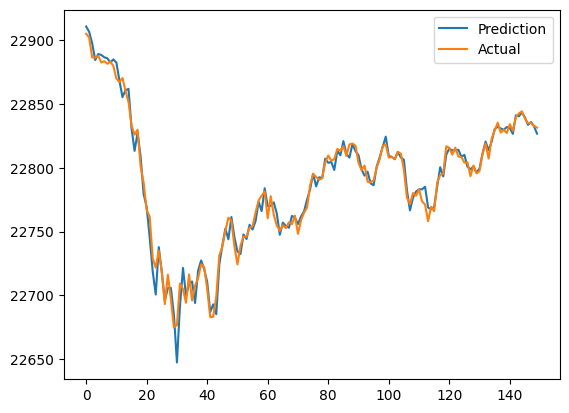

 mape: 0.00023950288024535507,
wape: 0.999758882362993,
mae: 5.59006505855955,
 mpe: -6.5062499220635504e-06,
 rmse: 8.37738517361262,
 corr: 0.9999650249197615,
r2_score:0.9999300268525146 minmax: 
150 6
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 148, 4)            76        
                                                                 
 flatten_8 (Flatten)         (None, 592)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 593       
                                                                 
Total params: 669
Trainable params: 669
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3741/3748 [============================>.] - ETA: 0s - loss: 3.1453e-04 - root_mean_squared_error: 

3748/3748 [==============================] - 23s 6ms/step - loss: 3.1406e-04 - root_mean_squared_error: 0.0177 - val_loss: 6.3474e-05 - val_root_mean_squared_error: 0.0080
Epoch 2/20
3748/3748 [==============================] - 22s 6ms/step - loss: 2.8637e-05 - root_mean_squared_error: 0.0054 - val_loss: 1.4433e-04 - val_root_mean_squared_error: 0.0120
Epoch 3/20
3748/3748 [==============================] - ETA: 0s - loss: 1.4317e-05 - root_mean_squared_error: 0.0038

3748/3748 [==============================] - 23s 6ms/step - loss: 1.4317e-05 - root_mean_squared_error: 0.0038 - val_loss: 7.4636e-06 - val_root_mean_squared_error: 0.0027
Epoch 4/20
3748/3748 [==============================] - 18s 5ms/step - loss: 9.1470e-06 - root_mean_squared_error: 0.0030 - val_loss: 9.7194e-05 - val_root_mean_squared_error: 0.0099
Epoch 5/20
3748/3748 [==============================] - 19s 5ms/step - loss: 6.2623e-06 - root_mean_squared_error: 0.0025 - val_loss: 1.7574e-05 - val_root_mean_squared_error: 0.0042
Epoch 6/20
3748/3748 [==============================] - 16s 4ms/step - loss: 5.4608e-06 - root_mean_squared_error: 0.0023 - val_loss: 9.4575e-05 - val_root_mean_squared_error: 0.0097
Epoch 7/20
3748/3748 [==============================] - 17s 4ms/step - loss: 4.6890e-06 - root_mean_squared_error: 0.0022 - val_loss: 8.4001e-05 - val_root_mean_squared_error: 0.0092
Epoch 8/20
3748/3748 [==============================] - 16s 4ms/step - loss: 4.3735e-06 - root_m

3748/3748 [==============================] - 18s 5ms/step - loss: 3.8516e-06 - root_mean_squared_error: 0.0020 - val_loss: 5.5871e-06 - val_root_mean_squared_error: 0.0024
Epoch 11/20
3738/3748 [============================>.] - ETA: 0s - loss: 3.4692e-06 - root_mean_squared_error: 0.0019

3748/3748 [==============================] - 20s 5ms/step - loss: 3.4622e-06 - root_mean_squared_error: 0.0019 - val_loss: 1.2730e-06 - val_root_mean_squared_error: 0.0011
Epoch 12/20
3748/3748 [==============================] - 18s 5ms/step - loss: 3.6841e-06 - root_mean_squared_error: 0.0019 - val_loss: 1.1654e-05 - val_root_mean_squared_error: 0.0034
Epoch 13/20
3748/3748 [==============================] - 18s 5ms/step - loss: 3.1938e-06 - root_mean_squared_error: 0.0018 - val_loss: 3.2709e-05 - val_root_mean_squared_error: 0.0057
Epoch 14/20
3748/3748 [==============================] - 17s 4ms/step - loss: 2.8132e-06 - root_mean_squared_error: 0.0017 - val_loss: 1.2814e-06 - val_root_mean_squared_error: 0.0011
Epoch 15/20
3748/3748 [==============================] - 16s 4ms/step - loss: 3.3125e-06 - root_mean_squared_error: 0.0018 - val_loss: 7.7201e-06 - val_root_mean_squared_error: 0.0028
Epoch 16/20
3748/3748 [==============================] - 15s 4ms/step - loss: 2.7838e-06 - r

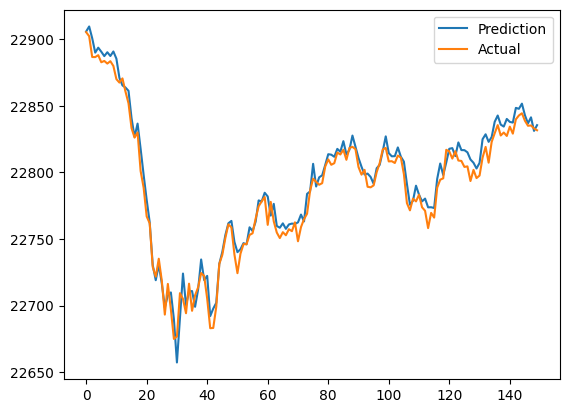

 mape: 0.00041770066794495235,
wape: 0.9995799947505282,
mae: 9.73739083805042,
 mpe: 0.00033829386505962103,
 rmse: 12.083902391733549,
 corr: 0.9999589368351871,
r2_score:0.9998544109007605 minmax: 
150 6
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 147, 4)            100       
                                                                 
 flatten_9 (Flatten)         (None, 588)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 589       
                                                                 
Total params: 689
Trainable params: 689
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3747/3748 [============================>.] - ETA: 0s - loss: 2.1911e-04 - root_mean_squared_error

3748/3748 [==============================] - 20s 5ms/step - loss: 2.1910e-04 - root_mean_squared_error: 0.0148 - val_loss: 2.3622e-05 - val_root_mean_squared_error: 0.0049
Epoch 2/20
3744/3748 [============================>.] - ETA: 0s - loss: 1.8742e-05 - root_mean_squared_error: 0.0043

3748/3748 [==============================] - 17s 5ms/step - loss: 1.8732e-05 - root_mean_squared_error: 0.0043 - val_loss: 2.0016e-05 - val_root_mean_squared_error: 0.0045
Epoch 3/20
3748/3748 [==============================] - 16s 4ms/step - loss: 1.0866e-05 - root_mean_squared_error: 0.0033 - val_loss: 1.2605e-04 - val_root_mean_squared_error: 0.0112
Epoch 4/20
3747/3748 [============================>.] - ETA: 0s - loss: 8.8317e-06 - root_mean_squared_error: 0.0030

3748/3748 [==============================] - 17s 5ms/step - loss: 8.8314e-06 - root_mean_squared_error: 0.0030 - val_loss: 5.4958e-06 - val_root_mean_squared_error: 0.0023
Epoch 5/20
3748/3748 [==============================] - 16s 4ms/step - loss: 6.9179e-06 - root_mean_squared_error: 0.0026 - val_loss: 4.7246e-05 - val_root_mean_squared_error: 0.0069
Epoch 6/20
3748/3748 [==============================] - 17s 4ms/step - loss: 5.4809e-06 - root_mean_squared_error: 0.0023 - val_loss: 1.5502e-05 - val_root_mean_squared_error: 0.0039
Epoch 7/20
3748/3748 [==============================] - 16s 4ms/step - loss: 5.1262e-06 - root_mean_squared_error: 0.0023 - val_loss: 4.1081e-04 - val_root_mean_squared_error: 0.0203
Epoch 8/20
3748/3748 [==============================] - 21s 6ms/step - loss: 5.4160e-06 - root_mean_squared_error: 0.0023 - val_loss: 1.9191e-05 - val_root_mean_squared_error: 0.0044
Epoch 9/20
3737/3748 [============================>.] - ETA: 0s - loss: 4.3989e-06 - root_mean_s

3748/3748 [==============================] - 19s 5ms/step - loss: 4.3914e-06 - root_mean_squared_error: 0.0021 - val_loss: 2.9401e-06 - val_root_mean_squared_error: 0.0017
Epoch 10/20
3748/3748 [==============================] - 15s 4ms/step - loss: 4.6127e-06 - root_mean_squared_error: 0.0021 - val_loss: 3.7744e-06 - val_root_mean_squared_error: 0.0019
Epoch 11/20
3741/3748 [============================>.] - ETA: 0s - loss: 3.1317e-06 - root_mean_squared_error: 0.0018

3748/3748 [==============================] - 16s 4ms/step - loss: 3.1279e-06 - root_mean_squared_error: 0.0018 - val_loss: 1.4923e-06 - val_root_mean_squared_error: 0.0012
Epoch 12/20
3748/3748 [==============================] - 16s 4ms/step - loss: 4.2515e-06 - root_mean_squared_error: 0.0021 - val_loss: 7.5073e-06 - val_root_mean_squared_error: 0.0027
Epoch 13/20
3748/3748 [==============================] - 16s 4ms/step - loss: 4.0618e-06 - root_mean_squared_error: 0.0020 - val_loss: 2.0033e-06 - val_root_mean_squared_error: 0.0014
Epoch 14/20
3748/3748 [==============================] - 16s 4ms/step - loss: 3.9023e-06 - root_mean_squared_error: 0.0020 - val_loss: 2.2705e-06 - val_root_mean_squared_error: 0.0015
Epoch 15/20
3748/3748 [==============================] - 16s 4ms/step - loss: 4.1762e-06 - root_mean_squared_error: 0.0020 - val_loss: 7.1976e-06 - val_root_mean_squared_error: 0.0027
Epoch 16/20
3748/3748 [==============================] - 16s 4ms/step - loss: 3.0205e-06 - r

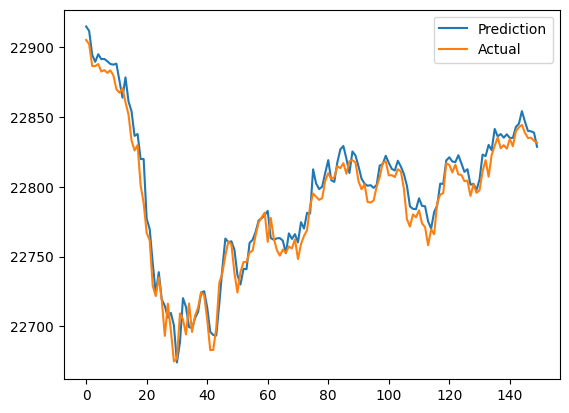

 mape: 0.00047809473567579533,
wape: 0.9995193477211461,
mae: 11.143429998279966,
 mpe: 0.0004189163078532261,
 rmse: 14.245926209876332,
 corr: 0.9999471490280872,
r2_score:0.9997976534412518 minmax: 
150 6
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 146, 4)            124       
                                                                 
 flatten_10 (Flatten)        (None, 584)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 585       
                                                                 
Total params: 709
Trainable params: 709
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3746/3748 [============================>.] - ETA: 0s - loss: 3.3460e-04 - root_mean_squared_err

3748/3748 [==============================] - 25s 7ms/step - loss: 3.3450e-04 - root_mean_squared_error: 0.0183 - val_loss: 4.0141e-05 - val_root_mean_squared_error: 0.0063
Epoch 2/20
3746/3748 [============================>.] - ETA: 0s - loss: 3.0518e-05 - root_mean_squared_error: 0.0055

3748/3748 [==============================] - 20s 5ms/step - loss: 3.0510e-05 - root_mean_squared_error: 0.0055 - val_loss: 2.5269e-05 - val_root_mean_squared_error: 0.0050
Epoch 3/20
3748/3748 [==============================] - 24s 6ms/step - loss: 1.9165e-05 - root_mean_squared_error: 0.0044 - val_loss: 9.7302e-05 - val_root_mean_squared_error: 0.0099
Epoch 4/20
3748/3748 [==============================] - 20s 5ms/step - loss: 1.3334e-05 - root_mean_squared_error: 0.0037 - val_loss: 1.5585e-04 - val_root_mean_squared_error: 0.0125
Epoch 5/20
3743/3748 [============================>.] - ETA: 0s - loss: 1.1489e-05 - root_mean_squared_error: 0.0034

3748/3748 [==============================] - 21s 6ms/step - loss: 1.1483e-05 - root_mean_squared_error: 0.0034 - val_loss: 4.7338e-06 - val_root_mean_squared_error: 0.0022
Epoch 6/20
3748/3748 [==============================] - 19s 5ms/step - loss: 8.5006e-06 - root_mean_squared_error: 0.0029 - val_loss: 6.6190e-06 - val_root_mean_squared_error: 0.0026
Epoch 7/20
3748/3748 [==============================] - 19s 5ms/step - loss: 6.7452e-06 - root_mean_squared_error: 0.0026 - val_loss: 2.4906e-05 - val_root_mean_squared_error: 0.0050
Epoch 8/20
3748/3748 [==============================] - 22s 6ms/step - loss: 7.1282e-06 - root_mean_squared_error: 0.0027 - val_loss: 7.3814e-06 - val_root_mean_squared_error: 0.0027
Epoch 9/20
3748/3748 [==============================] - 20s 5ms/step - loss: 5.2172e-06 - root_mean_squared_error: 0.0023 - val_loss: 6.8011e-06 - val_root_mean_squared_error: 0.0026
Epoch 10/20
3748/3748 [==============================] - 20s 5ms/step - loss: 6.2232e-06 - root_

3748/3748 [==============================] - 23s 6ms/step - loss: 4.7257e-06 - root_mean_squared_error: 0.0022 - val_loss: 1.7070e-06 - val_root_mean_squared_error: 0.0013
Epoch 12/20
3748/3748 [==============================] - 19s 5ms/step - loss: 6.7985e-06 - root_mean_squared_error: 0.0026 - val_loss: 2.0175e-05 - val_root_mean_squared_error: 0.0045
Epoch 13/20
3748/3748 [==============================] - 21s 6ms/step - loss: 3.1107e-06 - root_mean_squared_error: 0.0018 - val_loss: 1.8877e-05 - val_root_mean_squared_error: 0.0043
Epoch 14/20
3748/3748 [==============================] - 19s 5ms/step - loss: 5.4144e-06 - root_mean_squared_error: 0.0023 - val_loss: 1.2348e-05 - val_root_mean_squared_error: 0.0035
Epoch 15/20
3743/3748 [============================>.] - ETA: 0s - loss: 4.1595e-06 - root_mean_squared_error: 0.0020

3748/3748 [==============================] - 21s 5ms/step - loss: 4.1566e-06 - root_mean_squared_error: 0.0020 - val_loss: 1.6134e-06 - val_root_mean_squared_error: 0.0013
Epoch 16/20
3748/3748 [==============================] - 22s 6ms/step - loss: 4.5996e-06 - root_mean_squared_error: 0.0021 - val_loss: 1.4275e-05 - val_root_mean_squared_error: 0.0038
Epoch 17/20
3748/3748 [==============================] - 19s 5ms/step - loss: 3.6344e-06 - root_mean_squared_error: 0.0019 - val_loss: 1.7685e-05 - val_root_mean_squared_error: 0.0042
Epoch 18/20
3748/3748 [==============================] - 19s 5ms/step - loss: 4.2228e-06 - root_mean_squared_error: 0.0021 - val_loss: 9.7983e-06 - val_root_mean_squared_error: 0.0031
Epoch 19/20
3748/3748 [==============================] - 22s 6ms/step - loss: 4.1526e-06 - root_mean_squared_error: 0.0020 - val_loss: 2.3874e-04 - val_root_mean_squared_error: 0.0155
Epoch 20/20
1250/1250 [==============================] - 3s 2ms/step
       Test Predictions

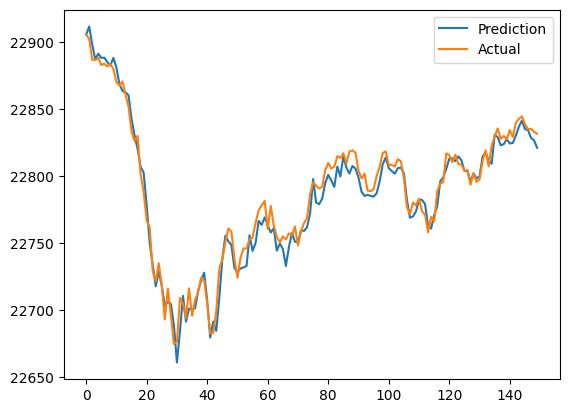

 mape: 0.0003645461165723891,
wape: 0.9996337251602662,
mae: 8.491706408712767,
 mpe: -0.00022207297219115025,
 rmse: 12.35708117989723,
 corr: 0.99993705291241,
r2_score:0.9998477538771826 minmax: 
150 6
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 149, 8)            104       
                                                                 
 flatten_11 (Flatten)        (None, 1192)              0         
                                                                 
 dense_11 (Dense)            (None, 1)                 1193      
                                                                 
Total params: 1,297
Trainable params: 1,297
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3739/3748 [============================>.] - ETA: 0s - loss: 1.1025e-04 - root_mean_squared_er

3748/3748 [==============================] - 20s 5ms/step - loss: 1.1006e-04 - root_mean_squared_error: 0.0105 - val_loss: 8.2885e-05 - val_root_mean_squared_error: 0.0091
Epoch 2/20
3744/3748 [============================>.] - ETA: 0s - loss: 1.7859e-05 - root_mean_squared_error: 0.0042

3748/3748 [==============================] - 17s 4ms/step - loss: 1.7847e-05 - root_mean_squared_error: 0.0042 - val_loss: 2.7898e-05 - val_root_mean_squared_error: 0.0053
Epoch 3/20
3748/3748 [==============================] - 16s 4ms/step - loss: 1.3456e-05 - root_mean_squared_error: 0.0037 - val_loss: 5.4738e-05 - val_root_mean_squared_error: 0.0074
Epoch 4/20
3736/3748 [============================>.] - ETA: 0s - loss: 1.0463e-05 - root_mean_squared_error: 0.0032

3748/3748 [==============================] - 19s 5ms/step - loss: 1.0460e-05 - root_mean_squared_error: 0.0032 - val_loss: 6.4392e-06 - val_root_mean_squared_error: 0.0025
Epoch 5/20
3748/3748 [==============================] - 16s 4ms/step - loss: 8.9570e-06 - root_mean_squared_error: 0.0030 - val_loss: 1.2406e-04 - val_root_mean_squared_error: 0.0111
Epoch 6/20
3748/3748 [==============================] - 16s 4ms/step - loss: 7.3947e-06 - root_mean_squared_error: 0.0027 - val_loss: 7.5251e-04 - val_root_mean_squared_error: 0.0274
Epoch 7/20
3742/3748 [============================>.] - ETA: 0s - loss: 5.4634e-06 - root_mean_squared_error: 0.0023

3748/3748 [==============================] - 17s 4ms/step - loss: 5.4574e-06 - root_mean_squared_error: 0.0023 - val_loss: 3.7740e-06 - val_root_mean_squared_error: 0.0019
Epoch 8/20
3748/3748 [==============================] - 16s 4ms/step - loss: 5.1902e-06 - root_mean_squared_error: 0.0023 - val_loss: 9.5442e-06 - val_root_mean_squared_error: 0.0031
Epoch 9/20
3748/3748 [==============================] - 16s 4ms/step - loss: 4.3945e-06 - root_mean_squared_error: 0.0021 - val_loss: 7.1203e-06 - val_root_mean_squared_error: 0.0027
Epoch 10/20
3748/3748 [==============================] - 16s 4ms/step - loss: 4.2986e-06 - root_mean_squared_error: 0.0021 - val_loss: 4.0315e-06 - val_root_mean_squared_error: 0.0020
Epoch 11/20
3748/3748 [==============================] - 16s 4ms/step - loss: 4.5220e-06 - root_mean_squared_error: 0.0021 - val_loss: 9.8821e-06 - val_root_mean_squared_error: 0.0031
Epoch 12/20
3746/3748 [============================>.] - ETA: 0s - loss: 3.2352e-06 - root_mea

3748/3748 [==============================] - 17s 5ms/step - loss: 3.2346e-06 - root_mean_squared_error: 0.0018 - val_loss: 1.0950e-06 - val_root_mean_squared_error: 0.0010
Epoch 13/20
3748/3748 [==============================] - 16s 4ms/step - loss: 3.1031e-06 - root_mean_squared_error: 0.0018 - val_loss: 3.2289e-06 - val_root_mean_squared_error: 0.0018
Epoch 14/20
3748/3748 [==============================] - 16s 4ms/step - loss: 4.3511e-06 - root_mean_squared_error: 0.0021 - val_loss: 2.8551e-06 - val_root_mean_squared_error: 0.0017
Epoch 15/20
3748/3748 [==============================] - 16s 4ms/step - loss: 2.3418e-06 - root_mean_squared_error: 0.0015 - val_loss: 1.0086e-05 - val_root_mean_squared_error: 0.0032
Epoch 16/20
3748/3748 [==============================] - 16s 4ms/step - loss: 3.1022e-06 - root_mean_squared_error: 0.0018 - val_loss: 1.9142e-05 - val_root_mean_squared_error: 0.0044
Epoch 17/20
3748/3748 [==============================] - 16s 4ms/step - loss: 4.2648e-06 - r

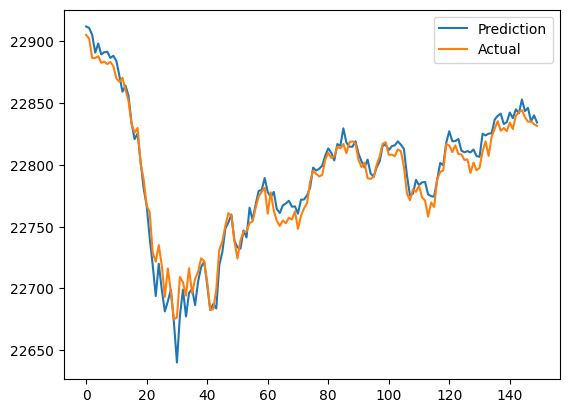

 mape: 0.00033596880822064055,
wape: 0.9996636642077795,
mae: 7.797600305698032,
 mpe: 0.000146821308476721,
 rmse: 10.54328917693097,
 corr: 0.9999505752768845,
r2_score:0.9998891676150908 minmax: 
150 6
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 148, 8)            152       
                                                                 
 flatten_12 (Flatten)        (None, 1184)              0         
                                                                 
 dense_12 (Dense)            (None, 1)                 1185      
                                                                 
Total params: 1,337
Trainable params: 1,337
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3737/3748 [============================>.] - ETA: 0s - loss: 1.0744e-04 - root_mean_squared_er

3748/3748 [==============================] - 19s 5ms/step - loss: 1.0723e-04 - root_mean_squared_error: 0.0104 - val_loss: 3.0648e-05 - val_root_mean_squared_error: 0.0055
Epoch 2/20
3748/3748 [==============================] - 22s 6ms/step - loss: 1.9648e-05 - root_mean_squared_error: 0.0044 - val_loss: 3.0800e-05 - val_root_mean_squared_error: 0.0055
Epoch 3/20
3737/3748 [============================>.] - ETA: 0s - loss: 1.1369e-05 - root_mean_squared_error: 0.0034

3748/3748 [==============================] - 17s 5ms/step - loss: 1.1352e-05 - root_mean_squared_error: 0.0034 - val_loss: 1.1705e-05 - val_root_mean_squared_error: 0.0034
Epoch 4/20
3748/3748 [==============================] - 16s 4ms/step - loss: 7.7995e-06 - root_mean_squared_error: 0.0028 - val_loss: 1.0107e-04 - val_root_mean_squared_error: 0.0101
Epoch 5/20
3744/3748 [============================>.] - ETA: 0s - loss: 6.0466e-06 - root_mean_squared_error: 0.0025

3748/3748 [==============================] - 17s 5ms/step - loss: 6.0477e-06 - root_mean_squared_error: 0.0025 - val_loss: 2.2010e-06 - val_root_mean_squared_error: 0.0015
Epoch 6/20
3748/3748 [==============================] - 17s 4ms/step - loss: 5.6196e-06 - root_mean_squared_error: 0.0024 - val_loss: 4.0886e-06 - val_root_mean_squared_error: 0.0020
Epoch 7/20
3748/3748 [==============================] - 17s 4ms/step - loss: 5.2110e-06 - root_mean_squared_error: 0.0023 - val_loss: 1.1559e-04 - val_root_mean_squared_error: 0.0108
Epoch 8/20
3748/3748 [==============================] - 19s 5ms/step - loss: 4.6148e-06 - root_mean_squared_error: 0.0021 - val_loss: 1.1455e-05 - val_root_mean_squared_error: 0.0034
Epoch 9/20
3748/3748 [==============================] - 16s 4ms/step - loss: 3.8332e-06 - root_mean_squared_error: 0.0020 - val_loss: 3.4819e-06 - val_root_mean_squared_error: 0.0019
Epoch 10/20
3746/3748 [============================>.] - ETA: 0s - loss: 5.3265e-06 - root_mean_

3748/3748 [==============================] - 17s 5ms/step - loss: 5.3249e-06 - root_mean_squared_error: 0.0023 - val_loss: 2.0276e-06 - val_root_mean_squared_error: 0.0014
Epoch 11/20
3748/3748 [==============================] - 17s 4ms/step - loss: 3.2983e-06 - root_mean_squared_error: 0.0018 - val_loss: 1.3235e-05 - val_root_mean_squared_error: 0.0036
Epoch 12/20
3737/3748 [============================>.] - ETA: 0s - loss: 4.8770e-06 - root_mean_squared_error: 0.0022

3748/3748 [==============================] - 19s 5ms/step - loss: 4.8662e-06 - root_mean_squared_error: 0.0022 - val_loss: 1.8259e-06 - val_root_mean_squared_error: 0.0014
Epoch 13/20
3745/3748 [============================>.] - ETA: 0s - loss: 2.5202e-06 - root_mean_squared_error: 0.0016

3748/3748 [==============================] - 18s 5ms/step - loss: 2.5193e-06 - root_mean_squared_error: 0.0016 - val_loss: 1.4961e-06 - val_root_mean_squared_error: 0.0012
Epoch 14/20
3748/3748 [==============================] - 16s 4ms/step - loss: 3.3947e-06 - root_mean_squared_error: 0.0018 - val_loss: 9.9677e-06 - val_root_mean_squared_error: 0.0032
Epoch 15/20
3748/3748 [==============================] - 16s 4ms/step - loss: 2.8886e-06 - root_mean_squared_error: 0.0017 - val_loss: 1.7259e-06 - val_root_mean_squared_error: 0.0013
Epoch 16/20
3734/3748 [============================>.] - ETA: 0s - loss: 4.9871e-06 - root_mean_squared_error: 0.0022

3748/3748 [==============================] - 17s 5ms/step - loss: 4.9717e-06 - root_mean_squared_error: 0.0022 - val_loss: 1.4481e-06 - val_root_mean_squared_error: 0.0012
Epoch 17/20
3735/3748 [============================>.] - ETA: 0s - loss: 2.0332e-06 - root_mean_squared_error: 0.0014

3748/3748 [==============================] - 18s 5ms/step - loss: 2.0305e-06 - root_mean_squared_error: 0.0014 - val_loss: 1.3986e-06 - val_root_mean_squared_error: 0.0012
Epoch 18/20
3748/3748 [==============================] - 17s 5ms/step - loss: 2.9988e-06 - root_mean_squared_error: 0.0017 - val_loss: 4.3656e-06 - val_root_mean_squared_error: 0.0021
Epoch 19/20
3734/3748 [============================>.] - ETA: 0s - loss: 2.9900e-06 - root_mean_squared_error: 0.0017

3748/3748 [==============================] - 18s 5ms/step - loss: 2.9819e-06 - root_mean_squared_error: 0.0017 - val_loss: 1.0624e-06 - val_root_mean_squared_error: 0.0010
Epoch 20/20
1250/1250 [==============================] - 3s 2ms/step
       Test Predictions   Actuals
0          22906.234375  22905.32
1          22899.332031  22902.29
2          22891.466797  22886.67
3          22882.576172  22886.61
4          22886.494141  22888.05
...                 ...       ...
39965      22534.400391  22542.26
39966      22533.216797  22533.65
39967      22523.507812  22530.37
39968      22512.576172  22520.83
39969      22521.359375  22524.46

[39970 rows x 2 columns]


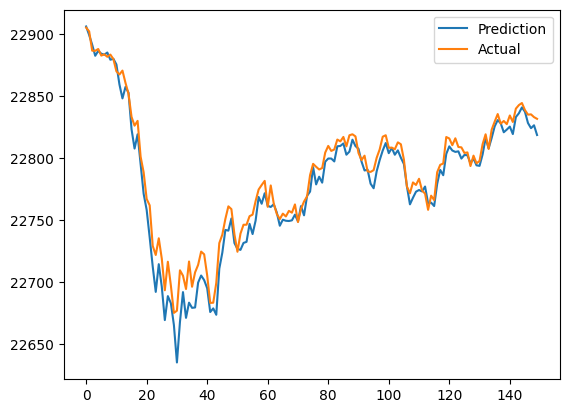

 mape: 0.00033204226900160393,
wape: 0.9996662275613099,
mae: 7.738171583765936,
 mpe: -0.0002798369636350357,
 rmse: 11.062759728346641,
 corr: 0.9999603619228352,
r2_score:0.9998779770831985 minmax: 
150 6
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 147, 8)            200       
                                                                 
 flatten_13 (Flatten)        (None, 1176)              0         
                                                                 
 dense_13 (Dense)            (None, 1)                 1177      
                                                                 
Total params: 1,377
Trainable params: 1,377
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3747/3748 [============================>.] - ETA: 0s - loss: 8.0771e-05 - root_mean_squared

3748/3748 [==============================] - 19s 5ms/step - loss: 8.0768e-05 - root_mean_squared_error: 0.0090 - val_loss: 3.6869e-05 - val_root_mean_squared_error: 0.0061
Epoch 2/20
3748/3748 [==============================] - 19s 5ms/step - loss: 2.3192e-05 - root_mean_squared_error: 0.0048 - val_loss: 2.2567e-04 - val_root_mean_squared_error: 0.0150
Epoch 3/20
3748/3748 [==============================] - 17s 4ms/step - loss: 1.4903e-05 - root_mean_squared_error: 0.0039 - val_loss: 2.7113e-04 - val_root_mean_squared_error: 0.0165
Epoch 4/20
3748/3748 [==============================] - 17s 5ms/step - loss: 1.1413e-05 - root_mean_squared_error: 0.0034 - val_loss: 2.4468e-04 - val_root_mean_squared_error: 0.0156
Epoch 5/20
3748/3748 [==============================] - 16s 4ms/step - loss: 1.4113e-05 - root_mean_squared_error: 0.0038 - val_loss: 4.2750e-05 - val_root_mean_squared_error: 0.0065
Epoch 6/20
3748/3748 [==============================] - 19s 5ms/step - loss: 7.3872e-06 - root_m

3748/3748 [==============================] - 18s 5ms/step - loss: 7.3834e-06 - root_mean_squared_error: 0.0027 - val_loss: 2.2991e-06 - val_root_mean_squared_error: 0.0015
Epoch 8/20
3748/3748 [==============================] - 17s 5ms/step - loss: 9.3358e-06 - root_mean_squared_error: 0.0031 - val_loss: 9.7467e-06 - val_root_mean_squared_error: 0.0031
Epoch 9/20
3748/3748 [==============================] - 17s 5ms/step - loss: 5.6614e-06 - root_mean_squared_error: 0.0024 - val_loss: 1.1911e-05 - val_root_mean_squared_error: 0.0035
Epoch 10/20
3748/3748 [==============================] - 17s 5ms/step - loss: 8.9930e-06 - root_mean_squared_error: 0.0030 - val_loss: 1.3835e-05 - val_root_mean_squared_error: 0.0037
Epoch 11/20
3748/3748 [==============================] - 17s 5ms/step - loss: 4.0796e-06 - root_mean_squared_error: 0.0020 - val_loss: 2.6129e-06 - val_root_mean_squared_error: 0.0016
Epoch 12/20
3748/3748 [==============================] - 17s 5ms/step - loss: 4.4853e-06 - roo

3748/3748 [==============================] - 18s 5ms/step - loss: 9.3190e-06 - root_mean_squared_error: 0.0031 - val_loss: 1.5975e-06 - val_root_mean_squared_error: 0.0013
Epoch 18/20
3748/3748 [==============================] - 17s 5ms/step - loss: 2.0469e-06 - root_mean_squared_error: 0.0014 - val_loss: 3.3109e-04 - val_root_mean_squared_error: 0.0182
Epoch 19/20
3748/3748 [==============================] - 19s 5ms/step - loss: 3.6154e-06 - root_mean_squared_error: 0.0019 - val_loss: 1.1370e-04 - val_root_mean_squared_error: 0.0107
Epoch 20/20
1250/1250 [==============================] - 4s 3ms/step
       Test Predictions   Actuals
0          22912.962891  22905.32
1          22914.105469  22902.29
2          22904.640625  22886.67
3          22899.750000  22886.61
4          22901.105469  22888.05
...                 ...       ...
39965      22542.669922  22542.26
39966      22545.076172  22533.65
39967      22551.744141  22530.37
39968      22518.818359  22520.83
39969      22539.

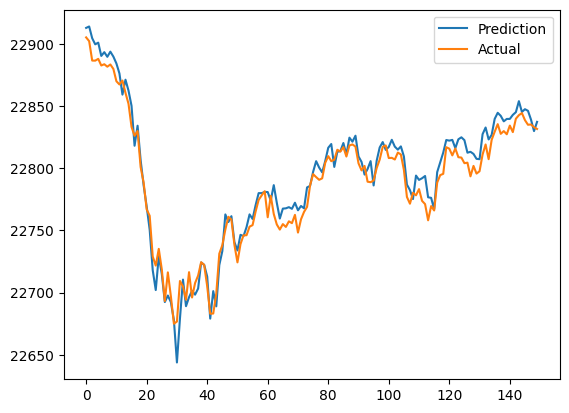

 mape: 0.00041991738193847744,
wape: 0.9995778164997302,
mae: 9.787891348198656,
 mpe: 0.000312796509894972,
 rmse: 12.343475577667785,
 corr: 0.9999513320161243,
r2_score:0.9998480889498124 minmax: 
150 6
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 146, 8)            248       
                                                                 
 flatten_14 (Flatten)        (None, 1168)              0         
                                                                 
 dense_14 (Dense)            (None, 1)                 1169      
                                                                 
Total params: 1,417
Trainable params: 1,417
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3743/3748 [============================>.] - ETA: 0s - loss: 1.7158e-04 - root_mean_squared_e

3748/3748 [==============================] - 21s 6ms/step - loss: 1.7142e-04 - root_mean_squared_error: 0.0131 - val_loss: 5.9926e-04 - val_root_mean_squared_error: 0.0245
Epoch 2/20
3746/3748 [============================>.] - ETA: 0s - loss: 2.7977e-05 - root_mean_squared_error: 0.0053

3748/3748 [==============================] - 23s 6ms/step - loss: 2.7970e-05 - root_mean_squared_error: 0.0053 - val_loss: 1.5680e-05 - val_root_mean_squared_error: 0.0040
Epoch 3/20
3747/3748 [============================>.] - ETA: 0s - loss: 1.2930e-05 - root_mean_squared_error: 0.0036

3748/3748 [==============================] - 23s 6ms/step - loss: 1.2929e-05 - root_mean_squared_error: 0.0036 - val_loss: 9.4879e-06 - val_root_mean_squared_error: 0.0031
Epoch 4/20
3748/3748 [==============================] - 19s 5ms/step - loss: 8.6968e-06 - root_mean_squared_error: 0.0029 - val_loss: 4.0962e-04 - val_root_mean_squared_error: 0.0202
Epoch 5/20
3748/3748 [==============================] - 20s 5ms/step - loss: 1.5697e-05 - root_mean_squared_error: 0.0040 - val_loss: 5.2280e-05 - val_root_mean_squared_error: 0.0072
Epoch 6/20
3738/3748 [============================>.] - ETA: 0s - loss: 3.3221e-06 - root_mean_squared_error: 0.0018

3748/3748 [==============================] - 23s 6ms/step - loss: 3.3244e-06 - root_mean_squared_error: 0.0018 - val_loss: 3.8169e-06 - val_root_mean_squared_error: 0.0020
Epoch 7/20
3748/3748 [==============================] - 19s 5ms/step - loss: 7.3866e-06 - root_mean_squared_error: 0.0027 - val_loss: 1.0845e-05 - val_root_mean_squared_error: 0.0033
Epoch 8/20
3748/3748 [==============================] - 19s 5ms/step - loss: 5.3347e-06 - root_mean_squared_error: 0.0023 - val_loss: 5.3058e-05 - val_root_mean_squared_error: 0.0073
Epoch 9/20
3748/3748 [==============================] - 23s 6ms/step - loss: 4.7128e-06 - root_mean_squared_error: 0.0022 - val_loss: 1.0009e-04 - val_root_mean_squared_error: 0.0100
Epoch 10/20
3748/3748 [==============================] - 20s 5ms/step - loss: 9.9162e-06 - root_mean_squared_error: 0.0031 - val_loss: 5.2928e-06 - val_root_mean_squared_error: 0.0023
Epoch 11/20
3748/3748 [==============================] - 24s 6ms/step - loss: 4.6177e-06 - root

3748/3748 [==============================] - 21s 6ms/step - loss: 1.1871e-05 - root_mean_squared_error: 0.0034 - val_loss: 8.5834e-07 - val_root_mean_squared_error: 9.2647e-04
Epoch 13/20
3748/3748 [==============================] - 24s 6ms/step - loss: 3.5117e-06 - root_mean_squared_error: 0.0019 - val_loss: 2.6471e-06 - val_root_mean_squared_error: 0.0016
Epoch 14/20
3748/3748 [==============================] - 21s 6ms/step - loss: 5.2461e-06 - root_mean_squared_error: 0.0023 - val_loss: 1.1877e-05 - val_root_mean_squared_error: 0.0034
Epoch 15/20
3748/3748 [==============================] - 20s 5ms/step - loss: 3.7179e-06 - root_mean_squared_error: 0.0019 - val_loss: 1.3305e-06 - val_root_mean_squared_error: 0.0012
Epoch 16/20
3748/3748 [==============================] - 21s 6ms/step - loss: 4.4501e-06 - root_mean_squared_error: 0.0021 - val_loss: 1.6977e-05 - val_root_mean_squared_error: 0.0041
Epoch 17/20
3748/3748 [==============================] - 23s 6ms/step - loss: 5.7026e-06

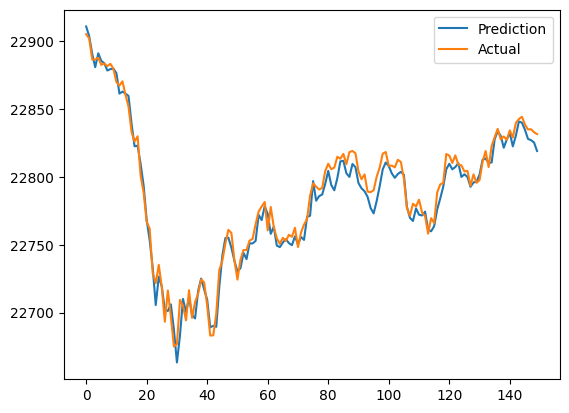

 mape: 0.0002948010267936229,
wape: 0.9997030002099402,
mae: 6.885635449243189,
 mpe: -0.00017303707669133754,
 rmse: 9.549661383987244,
 corr: 0.9999629117348556,
r2_score:0.9999090735183122 minmax: 
150 6
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 149, 12)           156       
                                                                 
 flatten_15 (Flatten)        (None, 1788)              0         
                                                                 
 dense_15 (Dense)            (None, 1)                 1789      
                                                                 
Total params: 1,945
Trainable params: 1,945
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3745/3748 [============================>.] - ETA: 0s - loss: 5.2188e-04 - root_mean_squared_

3748/3748 [==============================] - 24s 6ms/step - loss: 5.2162e-04 - root_mean_squared_error: 0.0228 - val_loss: 7.5314e-05 - val_root_mean_squared_error: 0.0087
Epoch 2/20
3748/3748 [==============================] - 24s 6ms/step - loss: 5.1100e-05 - root_mean_squared_error: 0.0071 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0492
Epoch 3/20
3739/3748 [============================>.] - ETA: 0s - loss: 2.0666e-05 - root_mean_squared_error: 0.0045

3748/3748 [==============================] - 18s 5ms/step - loss: 2.0632e-05 - root_mean_squared_error: 0.0045 - val_loss: 7.2477e-06 - val_root_mean_squared_error: 0.0027
Epoch 4/20
3748/3748 [==============================] - 18s 5ms/step - loss: 1.2181e-05 - root_mean_squared_error: 0.0035 - val_loss: 9.1317e-06 - val_root_mean_squared_error: 0.0030
Epoch 5/20
3748/3748 [==============================] - 19s 5ms/step - loss: 1.1715e-05 - root_mean_squared_error: 0.0034 - val_loss: 1.0132e-05 - val_root_mean_squared_error: 0.0032
Epoch 6/20
3748/3748 [==============================] - 19s 5ms/step - loss: 6.9727e-06 - root_mean_squared_error: 0.0026 - val_loss: 3.8787e-05 - val_root_mean_squared_error: 0.0062
Epoch 7/20
3748/3748 [==============================] - 20s 5ms/step - loss: 6.7326e-06 - root_mean_squared_error: 0.0026 - val_loss: 1.5038e-04 - val_root_mean_squared_error: 0.0123
Epoch 8/20
3738/3748 [============================>.] - ETA: 0s - loss: 5.6296e-06 - root_mean_s

3748/3748 [==============================] - 21s 6ms/step - loss: 5.6255e-06 - root_mean_squared_error: 0.0024 - val_loss: 5.3265e-06 - val_root_mean_squared_error: 0.0023
Epoch 9/20
3748/3748 [==============================] - 18s 5ms/step - loss: 4.2005e-06 - root_mean_squared_error: 0.0020 - val_loss: 5.6740e-06 - val_root_mean_squared_error: 0.0024
Epoch 10/20
3743/3748 [============================>.] - ETA: 0s - loss: 4.8564e-06 - root_mean_squared_error: 0.0022

3748/3748 [==============================] - 19s 5ms/step - loss: 4.8521e-06 - root_mean_squared_error: 0.0022 - val_loss: 4.6994e-06 - val_root_mean_squared_error: 0.0022
Epoch 11/20
3748/3748 [==============================] - 23s 6ms/step - loss: 9.9280e-06 - root_mean_squared_error: 0.0032 - val_loss: 8.7627e-06 - val_root_mean_squared_error: 0.0030
Epoch 12/20
3748/3748 [==============================] - 24s 6ms/step - loss: 2.8551e-06 - root_mean_squared_error: 0.0017 - val_loss: 5.0411e-06 - val_root_mean_squared_error: 0.0022
Epoch 13/20
3748/3748 [==============================] - 20s 5ms/step - loss: 3.0626e-06 - root_mean_squared_error: 0.0018 - val_loss: 7.1498e-05 - val_root_mean_squared_error: 0.0085
Epoch 14/20
3748/3748 [==============================] - 24s 6ms/step - loss: 3.0756e-06 - root_mean_squared_error: 0.0018 - val_loss: 1.7088e-04 - val_root_mean_squared_error: 0.0131
Epoch 15/20
3748/3748 [==============================] - 23s 6ms/step - loss: 3.3112e-06 - r

3748/3748 [==============================] - 24s 6ms/step - loss: 2.1900e-06 - root_mean_squared_error: 0.0015 - val_loss: 3.0033e-06 - val_root_mean_squared_error: 0.0017
Epoch 18/20
3748/3748 [==============================] - 20s 5ms/step - loss: 8.2663e-06 - root_mean_squared_error: 0.0029 - val_loss: 3.4628e-06 - val_root_mean_squared_error: 0.0019
Epoch 19/20
3748/3748 [==============================] - 23s 6ms/step - loss: 1.5472e-06 - root_mean_squared_error: 0.0012 - val_loss: 3.2928e-05 - val_root_mean_squared_error: 0.0057
Epoch 20/20
1250/1250 [==============================] - 4s 3ms/step
       Test Predictions   Actuals
0          22900.830078  22905.32
1          22901.474609  22902.29
2          22887.873047  22886.67
3          22873.367188  22886.61
4          22882.964844  22888.05
...                 ...       ...
39965      22518.191406  22542.26
39966      22523.226562  22533.65
39967      22516.609375  22530.37
39968      22502.667969  22520.83
39969      22506.

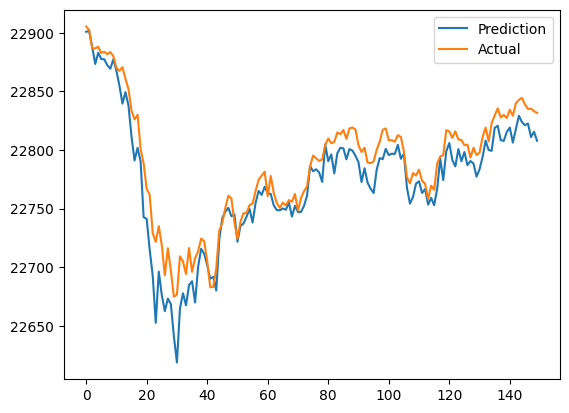

 mape: 0.000728843222882976,
wape: 0.9992655714840786,
mae: 17.026971713159863,
 mpe: -0.0007091258924000153,
 rmse: 20.829799009701826,
 corr: 0.9999272255377012,
r2_score:0.9995674019069606 minmax: 
150 6
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 148, 12)           228       
                                                                 
 flatten_16 (Flatten)        (None, 1776)              0         
                                                                 
 dense_16 (Dense)            (None, 1)                 1777      
                                                                 
Total params: 2,005
Trainable params: 2,005
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3744/3748 [============================>.] - ETA: 0s - loss: 1.1279e-04 - root_mean_squared_

3748/3748 [==============================] - 25s 6ms/step - loss: 1.1272e-04 - root_mean_squared_error: 0.0106 - val_loss: 2.7791e-05 - val_root_mean_squared_error: 0.0053
Epoch 2/20
3748/3748 [==============================] - 25s 7ms/step - loss: 2.2391e-05 - root_mean_squared_error: 0.0047 - val_loss: 7.0396e-05 - val_root_mean_squared_error: 0.0084
Epoch 3/20
3748/3748 [==============================] - 24s 6ms/step - loss: 1.4502e-05 - root_mean_squared_error: 0.0038 - val_loss: 3.5553e-05 - val_root_mean_squared_error: 0.0060
Epoch 4/20
3742/3748 [============================>.] - ETA: 0s - loss: 8.4405e-06 - root_mean_squared_error: 0.0029

3748/3748 [==============================] - 25s 7ms/step - loss: 8.4342e-06 - root_mean_squared_error: 0.0029 - val_loss: 8.8037e-06 - val_root_mean_squared_error: 0.0030
Epoch 5/20
3744/3748 [============================>.] - ETA: 0s - loss: 6.9922e-06 - root_mean_squared_error: 0.0026

3748/3748 [==============================] - 26s 7ms/step - loss: 6.9885e-06 - root_mean_squared_error: 0.0026 - val_loss: 3.2800e-06 - val_root_mean_squared_error: 0.0018
Epoch 6/20
3748/3748 [==============================] - 26s 7ms/step - loss: 6.5478e-06 - root_mean_squared_error: 0.0026 - val_loss: 7.9203e-06 - val_root_mean_squared_error: 0.0028
Epoch 7/20
3748/3748 [==============================] - 25s 7ms/step - loss: 5.0587e-06 - root_mean_squared_error: 0.0022 - val_loss: 7.8521e-06 - val_root_mean_squared_error: 0.0028
Epoch 8/20
3748/3748 [==============================] - 22s 6ms/step - loss: 4.0269e-06 - root_mean_squared_error: 0.0020 - val_loss: 7.5404e-06 - val_root_mean_squared_error: 0.0027
Epoch 9/20
3742/3748 [============================>.] - ETA: 0s - loss: 5.2683e-06 - root_mean_squared_error: 0.0023

3748/3748 [==============================] - 26s 7ms/step - loss: 5.2617e-06 - root_mean_squared_error: 0.0023 - val_loss: 1.1547e-06 - val_root_mean_squared_error: 0.0011
Epoch 10/20
3748/3748 [==============================] - 25s 7ms/step - loss: 7.0888e-06 - root_mean_squared_error: 0.0027 - val_loss: 2.6031e-05 - val_root_mean_squared_error: 0.0051
Epoch 11/20
3743/3748 [============================>.] - ETA: 0s - loss: 2.6353e-06 - root_mean_squared_error: 0.0016

3748/3748 [==============================] - 25s 7ms/step - loss: 2.6333e-06 - root_mean_squared_error: 0.0016 - val_loss: 1.0520e-06 - val_root_mean_squared_error: 0.0010
Epoch 12/20
3748/3748 [==============================] - 21s 6ms/step - loss: 4.5309e-06 - root_mean_squared_error: 0.0021 - val_loss: 2.9111e-04 - val_root_mean_squared_error: 0.0171
Epoch 13/20
3748/3748 [==============================] - 20s 5ms/step - loss: 3.3889e-06 - root_mean_squared_error: 0.0018 - val_loss: 4.2819e-06 - val_root_mean_squared_error: 0.0021
Epoch 14/20
3748/3748 [==============================] - 22s 6ms/step - loss: 3.3162e-06 - root_mean_squared_error: 0.0018 - val_loss: 1.6091e-05 - val_root_mean_squared_error: 0.0040
Epoch 15/20
3748/3748 [==============================] - 18s 5ms/step - loss: 1.5393e-05 - root_mean_squared_error: 0.0039 - val_loss: 4.3666e-06 - val_root_mean_squared_error: 0.0021
Epoch 16/20
3748/3748 [==============================] - 19s 5ms/step - loss: 2.5696e-06 - r

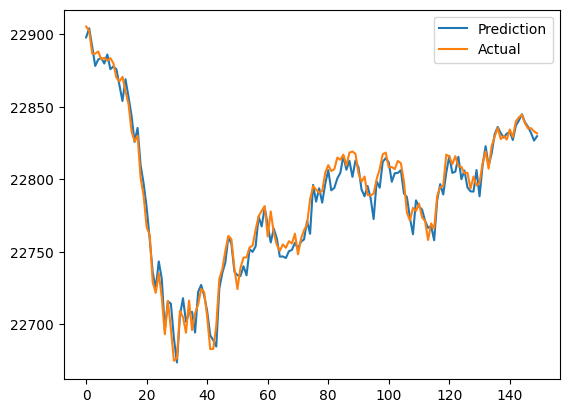

 mape: 0.00029590469024649705,
wape: 0.9997020054370358,
mae: 6.908698238522633,
 mpe: -8.895750088104592e-05,
 rmse: 10.006450916751508,
 corr: 0.9999522657633473,
r2_score:0.9999001668945299 minmax: 
150 6
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 147, 12)           300       
                                                                 
 flatten_17 (Flatten)        (None, 1764)              0         
                                                                 
 dense_17 (Dense)            (None, 1)                 1765      
                                                                 
Total params: 2,065
Trainable params: 2,065
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3740/3748 [============================>.] - ETA: 0s - loss: 2.3854e-04 - root_mean_squared

3748/3748 [==============================] - 20s 5ms/step - loss: 2.3812e-04 - root_mean_squared_error: 0.0154 - val_loss: 3.3250e-04 - val_root_mean_squared_error: 0.0182
Epoch 2/20
3748/3748 [==============================] - 18s 5ms/step - loss: 3.2003e-05 - root_mean_squared_error: 0.0057 - val_loss: 4.6998e-04 - val_root_mean_squared_error: 0.0217
Epoch 3/20
3747/3748 [============================>.] - ETA: 0s - loss: 1.8506e-05 - root_mean_squared_error: 0.0043

3748/3748 [==============================] - 19s 5ms/step - loss: 1.8506e-05 - root_mean_squared_error: 0.0043 - val_loss: 1.2662e-05 - val_root_mean_squared_error: 0.0036
Epoch 4/20
3748/3748 [==============================] - 19s 5ms/step - loss: 1.0718e-05 - root_mean_squared_error: 0.0033 - val_loss: 2.9585e-05 - val_root_mean_squared_error: 0.0054
Epoch 5/20
3735/3748 [============================>.] - ETA: 0s - loss: 1.3390e-05 - root_mean_squared_error: 0.0037

3748/3748 [==============================] - 20s 5ms/step - loss: 1.3351e-05 - root_mean_squared_error: 0.0037 - val_loss: 5.9127e-06 - val_root_mean_squared_error: 0.0024
Epoch 6/20
3748/3748 [==============================] - 21s 6ms/step - loss: 4.8394e-06 - root_mean_squared_error: 0.0022 - val_loss: 7.4792e-05 - val_root_mean_squared_error: 0.0086
Epoch 7/20
3735/3748 [============================>.] - ETA: 0s - loss: 6.7275e-06 - root_mean_squared_error: 0.0026

3748/3748 [==============================] - 19s 5ms/step - loss: 6.7121e-06 - root_mean_squared_error: 0.0026 - val_loss: 2.4520e-06 - val_root_mean_squared_error: 0.0016
Epoch 8/20
3748/3748 [==============================] - 20s 5ms/step - loss: 5.9292e-06 - root_mean_squared_error: 0.0024 - val_loss: 4.5699e-06 - val_root_mean_squared_error: 0.0021
Epoch 9/20
3748/3748 [==============================] - 19s 5ms/step - loss: 4.6937e-06 - root_mean_squared_error: 0.0022 - val_loss: 6.4004e-06 - val_root_mean_squared_error: 0.0025
Epoch 10/20
3748/3748 [==============================] - 22s 6ms/step - loss: 1.4438e-05 - root_mean_squared_error: 0.0038 - val_loss: 2.9820e-06 - val_root_mean_squared_error: 0.0017
Epoch 11/20
3748/3748 [==============================] - 20s 5ms/step - loss: 2.9767e-06 - root_mean_squared_error: 0.0017 - val_loss: 9.6903e-05 - val_root_mean_squared_error: 0.0098
Epoch 12/20
3748/3748 [==============================] - 20s 5ms/step - loss: 5.2988e-06 - roo

3748/3748 [==============================] - 20s 5ms/step - loss: 3.9984e-06 - root_mean_squared_error: 0.0020 - val_loss: 1.1537e-06 - val_root_mean_squared_error: 0.0011
Epoch 19/20
3748/3748 [==============================] - 22s 6ms/step - loss: 3.0089e-06 - root_mean_squared_error: 0.0017 - val_loss: 2.1356e-06 - val_root_mean_squared_error: 0.0015
Epoch 20/20
1250/1250 [==============================] - 4s 3ms/step
       Test Predictions   Actuals
0          22915.970703  22905.32
1          22912.828125  22902.29
2          22900.351562  22886.67
3          22886.496094  22886.61
4          22892.896484  22888.05
...                 ...       ...
39965      22540.777344  22542.26
39966      22546.771484  22533.65
39967      22540.892578  22530.37
39968      22523.347656  22520.83
39969      22540.505859  22524.46

[39970 rows x 2 columns]


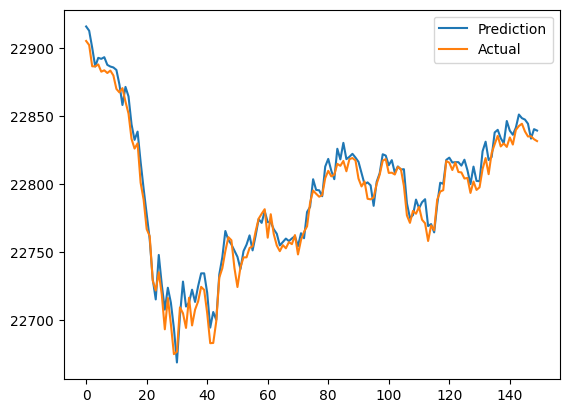

 mape: 0.00039956550782809007,
wape: 0.9995979327830846,
mae: 9.321515955325879,
 mpe: 0.00035830258841651903,
 rmse: 11.616425672537137,
 corr: 0.9999688761384753,
r2_score:0.9998654575047946 minmax: 
150 6
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 146, 12)           372       
                                                                 
 flatten_18 (Flatten)        (None, 1752)              0         
                                                                 
 dense_18 (Dense)            (None, 1)                 1753      
                                                                 
Total params: 2,125
Trainable params: 2,125
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3740/3748 [============================>.] - ETA: 0s - loss: 4.0409e-04 - root_mean_squared

3748/3748 [==============================] - 24s 6ms/step - loss: 4.0345e-04 - root_mean_squared_error: 0.0201 - val_loss: 7.6771e-04 - val_root_mean_squared_error: 0.0277
Epoch 2/20
3739/3748 [============================>.] - ETA: 0s - loss: 3.0786e-05 - root_mean_squared_error: 0.0055

3748/3748 [==============================] - 25s 7ms/step - loss: 3.0737e-05 - root_mean_squared_error: 0.0055 - val_loss: 7.0762e-05 - val_root_mean_squared_error: 0.0084
Epoch 3/20
3746/3748 [============================>.] - ETA: 0s - loss: 1.8017e-05 - root_mean_squared_error: 0.0042

3748/3748 [==============================] - 26s 7ms/step - loss: 1.8013e-05 - root_mean_squared_error: 0.0042 - val_loss: 3.2577e-05 - val_root_mean_squared_error: 0.0057
Epoch 4/20
3748/3748 [==============================] - ETA: 0s - loss: 1.0435e-05 - root_mean_squared_error: 0.0032

3748/3748 [==============================] - 27s 7ms/step - loss: 1.0435e-05 - root_mean_squared_error: 0.0032 - val_loss: 1.0350e-05 - val_root_mean_squared_error: 0.0032
Epoch 5/20
3736/3748 [============================>.] - ETA: 0s - loss: 1.5778e-05 - root_mean_squared_error: 0.0040

3748/3748 [==============================] - 23s 6ms/step - loss: 1.5742e-05 - root_mean_squared_error: 0.0040 - val_loss: 3.5122e-06 - val_root_mean_squared_error: 0.0019
Epoch 6/20
3748/3748 [==============================] - 23s 6ms/step - loss: 8.0252e-06 - root_mean_squared_error: 0.0028 - val_loss: 1.0218e-05 - val_root_mean_squared_error: 0.0032
Epoch 7/20
3748/3748 [==============================] - 22s 6ms/step - loss: 1.8682e-05 - root_mean_squared_error: 0.0043 - val_loss: 2.8603e-05 - val_root_mean_squared_error: 0.0053
Epoch 8/20
3745/3748 [============================>.] - ETA: 0s - loss: 4.5594e-06 - root_mean_squared_error: 0.0021

3748/3748 [==============================] - 25s 7ms/step - loss: 4.5618e-06 - root_mean_squared_error: 0.0021 - val_loss: 2.3445e-06 - val_root_mean_squared_error: 0.0015
Epoch 9/20
3748/3748 [==============================] - 30s 8ms/step - loss: 1.1041e-05 - root_mean_squared_error: 0.0033 - val_loss: 8.0480e-05 - val_root_mean_squared_error: 0.0090
Epoch 10/20
3748/3748 [==============================] - 23s 6ms/step - loss: 4.1165e-06 - root_mean_squared_error: 0.0020 - val_loss: 5.6765e-06 - val_root_mean_squared_error: 0.0024
Epoch 11/20
3748/3748 [==============================] - 25s 7ms/step - loss: 1.3190e-05 - root_mean_squared_error: 0.0036 - val_loss: 1.3999e-05 - val_root_mean_squared_error: 0.0037
Epoch 12/20
3748/3748 [==============================] - 23s 6ms/step - loss: 5.3986e-06 - root_mean_squared_error: 0.0023 - val_loss: 8.9018e-06 - val_root_mean_squared_error: 0.0030
Epoch 13/20
3748/3748 [==============================] - 22s 6ms/step - loss: 2.5616e-05 - ro

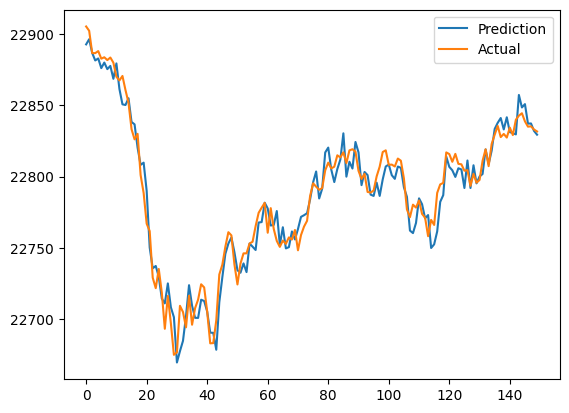

 mape: 0.0004481942856521403,
wape: 0.9995495700340887,
mae: 10.442756676882654,
 mpe: -3.601576737425663e-06,
 rmse: 15.095598536458438,
 corr: 0.9998863971192838,
r2_score:0.9997727964480219 minmax: 
150 6
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_19 (Conv1D)          (None, 149, 16)           208       
                                                                 
 flatten_19 (Flatten)        (None, 2384)              0         
                                                                 
 dense_19 (Dense)            (None, 1)                 2385      
                                                                 
Total params: 2,593
Trainable params: 2,593
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3740/3748 [============================>.] - ETA: 0s - loss: 2.4354e-04 - root_mean_squared

3748/3748 [==============================] - 22s 5ms/step - loss: 2.4310e-04 - root_mean_squared_error: 0.0156 - val_loss: 4.0209e-05 - val_root_mean_squared_error: 0.0063
Epoch 2/20
3743/3748 [============================>.] - ETA: 0s - loss: 2.9540e-05 - root_mean_squared_error: 0.0054

3748/3748 [==============================] - 22s 6ms/step - loss: 2.9513e-05 - root_mean_squared_error: 0.0054 - val_loss: 2.3552e-05 - val_root_mean_squared_error: 0.0049
Epoch 3/20
3748/3748 [==============================] - 22s 6ms/step - loss: 1.6954e-05 - root_mean_squared_error: 0.0041 - val_loss: 2.3565e-04 - val_root_mean_squared_error: 0.0154
Epoch 4/20
3736/3748 [============================>.] - ETA: 0s - loss: 1.3634e-05 - root_mean_squared_error: 0.0037

3748/3748 [==============================] - 19s 5ms/step - loss: 1.3612e-05 - root_mean_squared_error: 0.0037 - val_loss: 2.0722e-05 - val_root_mean_squared_error: 0.0046
Epoch 5/20
3739/3748 [============================>.] - ETA: 0s - loss: 9.4611e-06 - root_mean_squared_error: 0.0031

3748/3748 [==============================] - 20s 5ms/step - loss: 9.4793e-06 - root_mean_squared_error: 0.0031 - val_loss: 1.3165e-05 - val_root_mean_squared_error: 0.0036
Epoch 6/20
3743/3748 [============================>.] - ETA: 0s - loss: 7.0311e-06 - root_mean_squared_error: 0.0027

3748/3748 [==============================] - 20s 5ms/step - loss: 7.0259e-06 - root_mean_squared_error: 0.0027 - val_loss: 3.4007e-06 - val_root_mean_squared_error: 0.0018
Epoch 7/20
3748/3748 [==============================] - ETA: 0s - loss: 8.5107e-06 - root_mean_squared_error: 0.0029

3748/3748 [==============================] - 21s 6ms/step - loss: 8.5107e-06 - root_mean_squared_error: 0.0029 - val_loss: 1.4114e-06 - val_root_mean_squared_error: 0.0012
Epoch 8/20
3748/3748 [==============================] - 19s 5ms/step - loss: 3.9255e-06 - root_mean_squared_error: 0.0020 - val_loss: 2.9327e-06 - val_root_mean_squared_error: 0.0017
Epoch 9/20
3748/3748 [==============================] - 19s 5ms/step - loss: 4.3873e-06 - root_mean_squared_error: 0.0021 - val_loss: 2.6478e-04 - val_root_mean_squared_error: 0.0163
Epoch 10/20
3748/3748 [==============================] - 19s 5ms/step - loss: 4.6336e-06 - root_mean_squared_error: 0.0022 - val_loss: 2.3123e-05 - val_root_mean_squared_error: 0.0048
Epoch 11/20
3748/3748 [==============================] - 19s 5ms/step - loss: 3.1657e-06 - root_mean_squared_error: 0.0018 - val_loss: 4.9715e-05 - val_root_mean_squared_error: 0.0071
Epoch 12/20
3748/3748 [==============================] - 22s 6ms/step - loss: 3.9355e-06 - roo

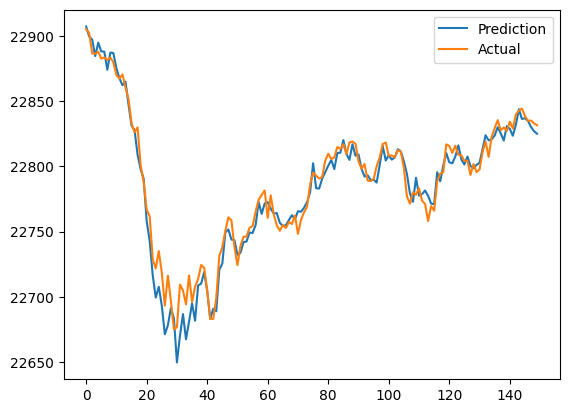

 mape: 0.0003299735852911814,
wape: 0.9996680095809083,
mae: 7.696857287496879,
 mpe: -6.679729376471411e-05,
 rmse: 11.428508427270504,
 corr: 0.9999362759185418,
r2_score:0.9998697752454189 minmax: 
150 6
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 148, 16)           304       
                                                                 
 flatten_20 (Flatten)        (None, 2368)              0         
                                                                 
 dense_20 (Dense)            (None, 1)                 2369      
                                                                 
Total params: 2,673
Trainable params: 2,673
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3747/3748 [============================>.] - ETA: 0s - loss: 2.3632e-04 - root_mean_squared_

3748/3748 [==============================] - 22s 6ms/step - loss: 2.3631e-04 - root_mean_squared_error: 0.0154 - val_loss: 8.6706e-04 - val_root_mean_squared_error: 0.0294
Epoch 2/20
3736/3748 [============================>.] - ETA: 0s - loss: 2.5710e-05 - root_mean_squared_error: 0.0051

3748/3748 [==============================] - 19s 5ms/step - loss: 2.5671e-05 - root_mean_squared_error: 0.0051 - val_loss: 2.0734e-05 - val_root_mean_squared_error: 0.0046
Epoch 3/20
3748/3748 [==============================] - 20s 5ms/step - loss: 1.6380e-05 - root_mean_squared_error: 0.0040 - val_loss: 2.9914e-05 - val_root_mean_squared_error: 0.0055
Epoch 4/20
3748/3748 [==============================] - ETA: 0s - loss: 1.1175e-05 - root_mean_squared_error: 0.0033

3748/3748 [==============================] - 20s 5ms/step - loss: 1.1175e-05 - root_mean_squared_error: 0.0033 - val_loss: 1.8863e-05 - val_root_mean_squared_error: 0.0043
Epoch 5/20
3748/3748 [==============================] - 21s 6ms/step - loss: 8.2916e-06 - root_mean_squared_error: 0.0029 - val_loss: 1.9466e-04 - val_root_mean_squared_error: 0.0140
Epoch 6/20
3741/3748 [============================>.] - ETA: 0s - loss: 5.6115e-06 - root_mean_squared_error: 0.0024

3748/3748 [==============================] - 19s 5ms/step - loss: 5.6090e-06 - root_mean_squared_error: 0.0024 - val_loss: 7.7295e-06 - val_root_mean_squared_error: 0.0028
Epoch 7/20
3746/3748 [============================>.] - ETA: 0s - loss: 1.2767e-05 - root_mean_squared_error: 0.0036

3748/3748 [==============================] - 21s 6ms/step - loss: 1.2763e-05 - root_mean_squared_error: 0.0036 - val_loss: 1.8049e-06 - val_root_mean_squared_error: 0.0013
Epoch 8/20
3748/3748 [==============================] - 22s 6ms/step - loss: 3.3209e-06 - root_mean_squared_error: 0.0018 - val_loss: 1.3544e-05 - val_root_mean_squared_error: 0.0037
Epoch 9/20
3748/3748 [==============================] - 19s 5ms/step - loss: 1.1908e-05 - root_mean_squared_error: 0.0035 - val_loss: 1.1251e-05 - val_root_mean_squared_error: 0.0034
Epoch 10/20
3748/3748 [==============================] - 19s 5ms/step - loss: 2.9369e-06 - root_mean_squared_error: 0.0017 - val_loss: 3.3986e-06 - val_root_mean_squared_error: 0.0018
Epoch 11/20
3748/3748 [==============================] - 19s 5ms/step - loss: 7.1259e-06 - root_mean_squared_error: 0.0027 - val_loss: 5.7779e-06 - val_root_mean_squared_error: 0.0024
Epoch 12/20
3748/3748 [==============================] - 19s 5ms/step - loss: 1.0598e-05 - roo

3748/3748 [==============================] - 20s 5ms/step - loss: 2.3777e-06 - root_mean_squared_error: 0.0015 - val_loss: 1.2620e-06 - val_root_mean_squared_error: 0.0011
Epoch 14/20
3748/3748 [==============================] - 21s 6ms/step - loss: 1.2734e-05 - root_mean_squared_error: 0.0036 - val_loss: 2.6043e-05 - val_root_mean_squared_error: 0.0051
Epoch 15/20
3748/3748 [==============================] - 19s 5ms/step - loss: 2.3579e-06 - root_mean_squared_error: 0.0015 - val_loss: 1.0163e-04 - val_root_mean_squared_error: 0.0101
Epoch 16/20
3748/3748 [==============================] - 19s 5ms/step - loss: 1.2291e-05 - root_mean_squared_error: 0.0035 - val_loss: 1.5537e-05 - val_root_mean_squared_error: 0.0039
Epoch 17/20
3748/3748 [==============================] - 19s 5ms/step - loss: 4.3408e-06 - root_mean_squared_error: 0.0021 - val_loss: 3.7046e-06 - val_root_mean_squared_error: 0.0019
Epoch 18/20
3748/3748 [==============================] - 21s 6ms/step - loss: 2.6265e-06 - r

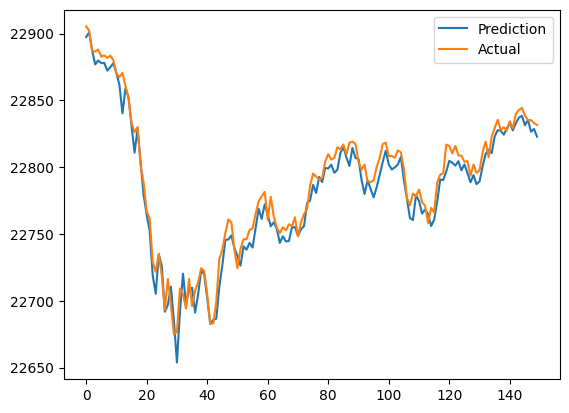

 mape: 0.00032605705642078464,
wape: 0.9996717620944282,
mae: 7.6098591111302225,
 mpe: -0.000211510528688885,
 rmse: 10.455458499876954,
 corr: 0.9999580007359404,
r2_score:0.9998910064979623 minmax: 
150 6
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_21 (Conv1D)          (None, 147, 16)           400       
                                                                 
 flatten_21 (Flatten)        (None, 2352)              0         
                                                                 
 dense_21 (Dense)            (None, 1)                 2353      
                                                                 
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3741/3748 [============================>.] - ETA: 0s - loss: 2.4662e-04 - root_mean_squared

3748/3748 [==============================] - 24s 6ms/step - loss: 2.4626e-04 - root_mean_squared_error: 0.0157 - val_loss: 4.9742e-05 - val_root_mean_squared_error: 0.0071
Epoch 2/20
3746/3748 [============================>.] - ETA: 0s - loss: 2.6225e-05 - root_mean_squared_error: 0.0051

3748/3748 [==============================] - 20s 5ms/step - loss: 2.6219e-05 - root_mean_squared_error: 0.0051 - val_loss: 3.7706e-05 - val_root_mean_squared_error: 0.0061
Epoch 3/20
3748/3748 [==============================] - 19s 5ms/step - loss: 1.7240e-05 - root_mean_squared_error: 0.0042 - val_loss: 4.1032e-04 - val_root_mean_squared_error: 0.0203
Epoch 4/20
3739/3748 [============================>.] - ETA: 0s - loss: 9.9041e-06 - root_mean_squared_error: 0.0031

3748/3748 [==============================] - 20s 5ms/step - loss: 9.8987e-06 - root_mean_squared_error: 0.0031 - val_loss: 2.4320e-05 - val_root_mean_squared_error: 0.0049
Epoch 5/20
3741/3748 [============================>.] - ETA: 0s - loss: 1.4285e-05 - root_mean_squared_error: 0.0038

3748/3748 [==============================] - 20s 5ms/step - loss: 1.4266e-05 - root_mean_squared_error: 0.0038 - val_loss: 6.4239e-06 - val_root_mean_squared_error: 0.0025
Epoch 6/20
3746/3748 [============================>.] - ETA: 0s - loss: 7.6031e-06 - root_mean_squared_error: 0.0028

3748/3748 [==============================] - 23s 6ms/step - loss: 7.6013e-06 - root_mean_squared_error: 0.0028 - val_loss: 5.0996e-06 - val_root_mean_squared_error: 0.0023
Epoch 7/20
3742/3748 [============================>.] - ETA: 0s - loss: 2.7905e-05 - root_mean_squared_error: 0.0053

3748/3748 [==============================] - 20s 5ms/step - loss: 2.7867e-05 - root_mean_squared_error: 0.0053 - val_loss: 3.4830e-06 - val_root_mean_squared_error: 0.0019
Epoch 8/20
3748/3748 [==============================] - 21s 6ms/step - loss: 1.4687e-06 - root_mean_squared_error: 0.0012 - val_loss: 5.9889e-06 - val_root_mean_squared_error: 0.0024
Epoch 9/20
3748/3748 [==============================] - 22s 6ms/step - loss: 5.4043e-06 - root_mean_squared_error: 0.0023 - val_loss: 1.9721e-05 - val_root_mean_squared_error: 0.0044
Epoch 10/20
3748/3748 [==============================] - 22s 6ms/step - loss: 7.0887e-06 - root_mean_squared_error: 0.0027 - val_loss: 6.1941e-06 - val_root_mean_squared_error: 0.0025
Epoch 11/20
3745/3748 [============================>.] - ETA: 0s - loss: 1.0532e-05 - root_mean_squared_error: 0.0032

3748/3748 [==============================] - 21s 5ms/step - loss: 1.0526e-05 - root_mean_squared_error: 0.0032 - val_loss: 1.1307e-06 - val_root_mean_squared_error: 0.0011
Epoch 12/20
3748/3748 [==============================] - 20s 5ms/step - loss: 3.1097e-06 - root_mean_squared_error: 0.0018 - val_loss: 1.2592e-05 - val_root_mean_squared_error: 0.0035
Epoch 13/20
3748/3748 [==============================] - 20s 5ms/step - loss: 3.4431e-05 - root_mean_squared_error: 0.0059 - val_loss: 2.3342e-06 - val_root_mean_squared_error: 0.0015
Epoch 14/20
3748/3748 [==============================] - 20s 5ms/step - loss: 6.7387e-06 - root_mean_squared_error: 0.0026 - val_loss: 1.3560e-06 - val_root_mean_squared_error: 0.0012
Epoch 15/20
3748/3748 [==============================] - 23s 6ms/step - loss: 4.9208e-06 - root_mean_squared_error: 0.0022 - val_loss: 5.1322e-06 - val_root_mean_squared_error: 0.0023
Epoch 16/20
3748/3748 [==============================] - 20s 5ms/step - loss: 2.1416e-05 - r

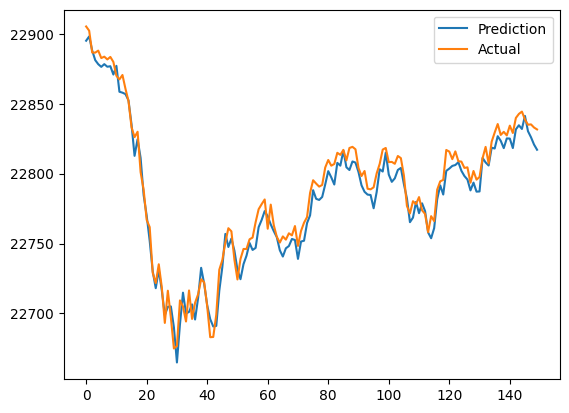

 mape: 0.0003808501687385754,
wape: 0.9996171553849663,
mae: 8.875859650597327,
 mpe: -0.00028127643793068673,
 rmse: 11.236835648193095,
 corr: 0.9999584577617895,
r2_score:0.999874106734241 minmax: 
150 6
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 146, 16)           496       
                                                                 
 flatten_22 (Flatten)        (None, 2336)              0         
                                                                 
 dense_22 (Dense)            (None, 1)                 2337      
                                                                 
Total params: 2,833
Trainable params: 2,833
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3747/3748 [============================>.] - ETA: 0s - loss: 1.0005e-04 - root_mean_squared_

3748/3748 [==============================] - 25s 7ms/step - loss: 1.0004e-04 - root_mean_squared_error: 0.0100 - val_loss: 3.8170e-04 - val_root_mean_squared_error: 0.0195
Epoch 2/20
3738/3748 [============================>.] - ETA: 0s - loss: 1.9012e-05 - root_mean_squared_error: 0.0044

3748/3748 [==============================] - 23s 6ms/step - loss: 1.8976e-05 - root_mean_squared_error: 0.0044 - val_loss: 1.1818e-05 - val_root_mean_squared_error: 0.0034
Epoch 3/20
3748/3748 [==============================] - 25s 7ms/step - loss: 7.3829e-05 - root_mean_squared_error: 0.0086 - val_loss: 4.5424e-05 - val_root_mean_squared_error: 0.0067
Epoch 4/20
3740/3748 [============================>.] - ETA: 0s - loss: 2.8615e-06 - root_mean_squared_error: 0.0017

3748/3748 [==============================] - 23s 6ms/step - loss: 2.8594e-06 - root_mean_squared_error: 0.0017 - val_loss: 1.1214e-05 - val_root_mean_squared_error: 0.0033
Epoch 5/20
3742/3748 [============================>.] - ETA: 0s - loss: 6.6679e-06 - root_mean_squared_error: 0.0026

3748/3748 [==============================] - 25s 7ms/step - loss: 6.6665e-06 - root_mean_squared_error: 0.0026 - val_loss: 2.3010e-06 - val_root_mean_squared_error: 0.0015
Epoch 6/20
3748/3748 [==============================] - 22s 6ms/step - loss: 6.6924e-06 - root_mean_squared_error: 0.0026 - val_loss: 1.3345e-05 - val_root_mean_squared_error: 0.0037
Epoch 7/20
3748/3748 [==============================] - 24s 7ms/step - loss: 9.1517e-06 - root_mean_squared_error: 0.0030 - val_loss: 3.1942e-05 - val_root_mean_squared_error: 0.0057
Epoch 8/20
3748/3748 [==============================] - 25s 7ms/step - loss: 7.5484e-06 - root_mean_squared_error: 0.0027 - val_loss: 3.9258e-05 - val_root_mean_squared_error: 0.0063
Epoch 9/20
3748/3748 [==============================] - ETA: 0s - loss: 4.0148e-05 - root_mean_squared_error: 0.0063

3748/3748 [==============================] - 23s 6ms/step - loss: 4.0148e-05 - root_mean_squared_error: 0.0063 - val_loss: 1.9958e-06 - val_root_mean_squared_error: 0.0014
Epoch 10/20
3747/3748 [============================>.] - ETA: 0s - loss: 3.3323e-06 - root_mean_squared_error: 0.0018

3748/3748 [==============================] - 25s 7ms/step - loss: 3.3322e-06 - root_mean_squared_error: 0.0018 - val_loss: 1.5969e-06 - val_root_mean_squared_error: 0.0013
Epoch 11/20
3748/3748 [==============================] - 22s 6ms/step - loss: 8.8151e-06 - root_mean_squared_error: 0.0030 - val_loss: 4.3424e-06 - val_root_mean_squared_error: 0.0021
Epoch 12/20
3748/3748 [==============================] - 25s 7ms/step - loss: 3.7588e-06 - root_mean_squared_error: 0.0019 - val_loss: 1.2551e-05 - val_root_mean_squared_error: 0.0035
Epoch 13/20
3748/3748 [==============================] - 24s 6ms/step - loss: 1.8746e-05 - root_mean_squared_error: 0.0043 - val_loss: 4.4399e-05 - val_root_mean_squared_error: 0.0067
Epoch 14/20
3748/3748 [==============================] - 21s 6ms/step - loss: 3.7332e-06 - root_mean_squared_error: 0.0019 - val_loss: 1.1034e-05 - val_root_mean_squared_error: 0.0033
Epoch 15/20
3748/3748 [==============================] - 21s 6ms/step - loss: 1.8619e-05 - r

3748/3748 [==============================] - 22s 6ms/step - loss: 5.9112e-06 - root_mean_squared_error: 0.0024 - val_loss: 1.5951e-06 - val_root_mean_squared_error: 0.0013
Epoch 18/20
3748/3748 [==============================] - 22s 6ms/step - loss: 3.1117e-06 - root_mean_squared_error: 0.0018 - val_loss: 2.2965e-04 - val_root_mean_squared_error: 0.0152
Epoch 19/20
3748/3748 [==============================] - 22s 6ms/step - loss: 6.3680e-06 - root_mean_squared_error: 0.0025 - val_loss: 6.1782e-06 - val_root_mean_squared_error: 0.0025
Epoch 20/20
1250/1250 [==============================] - 4s 3ms/step
       Test Predictions   Actuals
0          22918.892578  22905.32
1          22907.990234  22902.29
2          22896.937500  22886.67
3          22886.679688  22886.61
4          22888.865234  22888.05
...                 ...       ...
39965      22555.847656  22542.26
39966      22553.492188  22533.65
39967      22546.285156  22530.37
39968      22527.570312  22520.83
39969      22532.

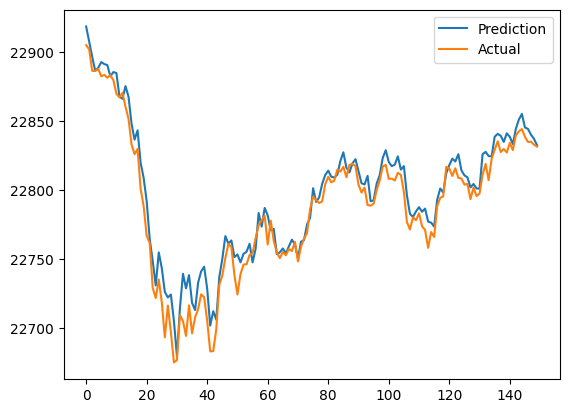

 mape: 0.0005086924980472424,
wape: 0.9994889761353433,
mae: 11.847564057808995,
 mpe: 0.0004707871848396308,
 rmse: 14.568193581422458,
 corr: 0.9999551725974057,
r2_score:0.9997883950370718 minmax: 
150 6
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_23 (Conv1D)          (None, 149, 20)           260       
                                                                 
 flatten_23 (Flatten)        (None, 2980)              0         
                                                                 
 dense_23 (Dense)            (None, 1)                 2981      
                                                                 
Total params: 3,241
Trainable params: 3,241
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3746/3748 [============================>.] - ETA: 0s - loss: 2.5354e-04 - root_mean_squared_

3748/3748 [==============================] - 21s 6ms/step - loss: 2.5346e-04 - root_mean_squared_error: 0.0159 - val_loss: 2.3431e-05 - val_root_mean_squared_error: 0.0048
Epoch 2/20
3748/3748 [==============================] - 20s 5ms/step - loss: 2.8927e-05 - root_mean_squared_error: 0.0054 - val_loss: 6.2187e-05 - val_root_mean_squared_error: 0.0079
Epoch 3/20
3745/3748 [============================>.] - ETA: 0s - loss: 1.6289e-05 - root_mean_squared_error: 0.0040

3748/3748 [==============================] - 23s 6ms/step - loss: 1.6293e-05 - root_mean_squared_error: 0.0040 - val_loss: 2.1362e-05 - val_root_mean_squared_error: 0.0046
Epoch 4/20
3743/3748 [============================>.] - ETA: 0s - loss: 1.1079e-05 - root_mean_squared_error: 0.0033

3748/3748 [==============================] - 21s 6ms/step - loss: 1.1074e-05 - root_mean_squared_error: 0.0033 - val_loss: 1.2036e-05 - val_root_mean_squared_error: 0.0035
Epoch 5/20
3748/3748 [==============================] - 19s 5ms/step - loss: 9.2088e-06 - root_mean_squared_error: 0.0030 - val_loss: 1.9704e-04 - val_root_mean_squared_error: 0.0140
Epoch 6/20
3740/3748 [============================>.] - ETA: 0s - loss: 3.1077e-05 - root_mean_squared_error: 0.0056

3748/3748 [==============================] - 21s 6ms/step - loss: 3.1019e-05 - root_mean_squared_error: 0.0056 - val_loss: 7.4659e-06 - val_root_mean_squared_error: 0.0027
Epoch 7/20
3748/3748 [==============================] - 27s 7ms/step - loss: 2.6197e-06 - root_mean_squared_error: 0.0016 - val_loss: 7.8747e-06 - val_root_mean_squared_error: 0.0028
Epoch 8/20
3748/3748 [==============================] - 20s 5ms/step - loss: 6.0743e-06 - root_mean_squared_error: 0.0025 - val_loss: 1.4950e-05 - val_root_mean_squared_error: 0.0039
Epoch 9/20
3748/3748 [==============================] - ETA: 0s - loss: 5.6958e-06 - root_mean_squared_error: 0.0024

3748/3748 [==============================] - 21s 5ms/step - loss: 5.6958e-06 - root_mean_squared_error: 0.0024 - val_loss: 2.4253e-06 - val_root_mean_squared_error: 0.0016
Epoch 10/20
3748/3748 [==============================] - 23s 6ms/step - loss: 5.3608e-06 - root_mean_squared_error: 0.0023 - val_loss: 3.4053e-05 - val_root_mean_squared_error: 0.0058
Epoch 11/20
3748/3748 [==============================] - 22s 6ms/step - loss: 7.3234e-06 - root_mean_squared_error: 0.0027 - val_loss: 3.8659e-06 - val_root_mean_squared_error: 0.0020
Epoch 12/20
3748/3748 [==============================] - 20s 5ms/step - loss: 2.8779e-06 - root_mean_squared_error: 0.0017 - val_loss: 3.8793e-05 - val_root_mean_squared_error: 0.0062
Epoch 13/20
3746/3748 [============================>.] - ETA: 0s - loss: 3.3649e-06 - root_mean_squared_error: 0.0018

3748/3748 [==============================] - 21s 6ms/step - loss: 3.3650e-06 - root_mean_squared_error: 0.0018 - val_loss: 1.3989e-06 - val_root_mean_squared_error: 0.0012
Epoch 14/20
3748/3748 [==============================] - 20s 5ms/step - loss: 4.3957e-06 - root_mean_squared_error: 0.0021 - val_loss: 1.1118e-05 - val_root_mean_squared_error: 0.0033
Epoch 15/20
3748/3748 [==============================] - 21s 6ms/step - loss: 1.9601e-05 - root_mean_squared_error: 0.0044 - val_loss: 3.3275e-06 - val_root_mean_squared_error: 0.0018
Epoch 16/20
3741/3748 [============================>.] - ETA: 0s - loss: 1.4441e-06 - root_mean_squared_error: 0.0012

3748/3748 [==============================] - 23s 6ms/step - loss: 1.4432e-06 - root_mean_squared_error: 0.0012 - val_loss: 8.1761e-07 - val_root_mean_squared_error: 9.0422e-04
Epoch 17/20
3748/3748 [==============================] - 21s 6ms/step - loss: 5.9678e-06 - root_mean_squared_error: 0.0024 - val_loss: 1.7922e-06 - val_root_mean_squared_error: 0.0013
Epoch 18/20
3748/3748 [==============================] - 21s 5ms/step - loss: 1.6986e-06 - root_mean_squared_error: 0.0013 - val_loss: 1.5406e-06 - val_root_mean_squared_error: 0.0012
Epoch 19/20
3748/3748 [==============================] - 23s 6ms/step - loss: 2.9466e-06 - root_mean_squared_error: 0.0017 - val_loss: 2.5833e-06 - val_root_mean_squared_error: 0.0016
Epoch 20/20
3747/3748 [============================>.] - ETA: 0s - loss: 6.5813e-06 - root_mean_squared_error: 0.0026

1250/1250 [==============================] - 4s 3ms/step
       Test Predictions   Actuals
0          22916.009766  22905.32
1          22912.267578  22902.29
2          22899.179688  22886.67
3          22890.621094  22886.61
4          22895.593750  22888.05
...                 ...       ...
39965      22542.224609  22542.26
39966      22537.316406  22533.65
39967      22535.351562  22530.37
39968      22517.580078  22520.83
39969      22526.958984  22524.46

[39970 rows x 2 columns]


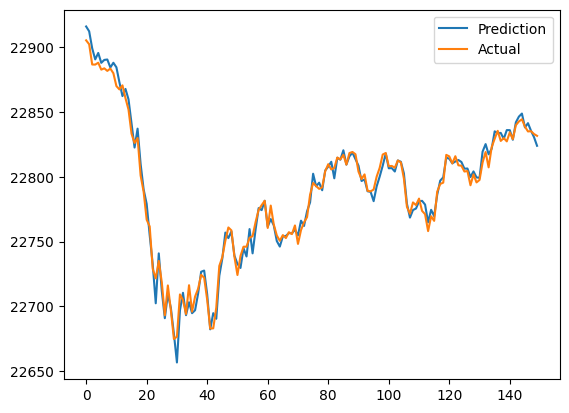

 mape: 0.00026174974596152316,
wape: 0.9997369492006002,
mae: 6.098562928055423,
 mpe: 5.227479998754239e-05,
 rmse: 8.55698234844118,
 corr: 0.9999642187817503,
r2_score:0.9999269944774031 minmax: 
150 6
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 148, 20)           380       
                                                                 
 flatten_24 (Flatten)        (None, 2960)              0         
                                                                 
 dense_24 (Dense)            (None, 1)                 2961      
                                                                 
Total params: 3,341
Trainable params: 3,341
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3744/3748 [============================>.] - ETA: 0s - loss: 2.8852e-04 - root_mean_squared_er

3748/3748 [==============================] - 25s 7ms/step - loss: 2.8832e-04 - root_mean_squared_error: 0.0170 - val_loss: 2.6272e-05 - val_root_mean_squared_error: 0.0051
Epoch 2/20
3737/3748 [============================>.] - ETA: 0s - loss: 3.0261e-05 - root_mean_squared_error: 0.0055

3748/3748 [==============================] - 22s 6ms/step - loss: 3.0205e-05 - root_mean_squared_error: 0.0055 - val_loss: 1.0796e-05 - val_root_mean_squared_error: 0.0033
Epoch 3/20
3748/3748 [==============================] - 22s 6ms/step - loss: 1.6939e-05 - root_mean_squared_error: 0.0041 - val_loss: 1.5444e-05 - val_root_mean_squared_error: 0.0039
Epoch 4/20
3742/3748 [============================>.] - ETA: 0s - loss: 1.0902e-05 - root_mean_squared_error: 0.0033

3748/3748 [==============================] - 25s 7ms/step - loss: 1.0898e-05 - root_mean_squared_error: 0.0033 - val_loss: 1.0193e-05 - val_root_mean_squared_error: 0.0032
Epoch 5/20
3740/3748 [============================>.] - ETA: 0s - loss: 2.8072e-05 - root_mean_squared_error: 0.0053

3748/3748 [==============================] - 22s 6ms/step - loss: 2.8023e-05 - root_mean_squared_error: 0.0053 - val_loss: 2.2163e-06 - val_root_mean_squared_error: 0.0015
Epoch 6/20
3738/3748 [============================>.] - ETA: 0s - loss: 3.5559e-06 - root_mean_squared_error: 0.0019

3748/3748 [==============================] - 22s 6ms/step - loss: 3.5495e-06 - root_mean_squared_error: 0.0019 - val_loss: 1.4286e-06 - val_root_mean_squared_error: 0.0012
Epoch 7/20
3748/3748 [==============================] - 24s 6ms/step - loss: 6.1560e-06 - root_mean_squared_error: 0.0025 - val_loss: 1.8922e-05 - val_root_mean_squared_error: 0.0043
Epoch 8/20
3748/3748 [==============================] - 25s 7ms/step - loss: 1.5281e-05 - root_mean_squared_error: 0.0039 - val_loss: 1.0066e-05 - val_root_mean_squared_error: 0.0032
Epoch 9/20
3748/3748 [==============================] - 25s 7ms/step - loss: 4.1765e-06 - root_mean_squared_error: 0.0020 - val_loss: 3.8169e-06 - val_root_mean_squared_error: 0.0020
Epoch 10/20
3746/3748 [============================>.] - ETA: 0s - loss: 2.8836e-05 - root_mean_squared_error: 0.0054

3748/3748 [==============================] - 25s 7ms/step - loss: 2.8827e-05 - root_mean_squared_error: 0.0054 - val_loss: 1.0855e-06 - val_root_mean_squared_error: 0.0010
Epoch 11/20
3748/3748 [==============================] - 22s 6ms/step - loss: 3.3262e-06 - root_mean_squared_error: 0.0018 - val_loss: 5.1790e-06 - val_root_mean_squared_error: 0.0023
Epoch 12/20
3748/3748 [==============================] - 22s 6ms/step - loss: 4.6918e-06 - root_mean_squared_error: 0.0022 - val_loss: 1.2266e-06 - val_root_mean_squared_error: 0.0011
Epoch 13/20
3748/3748 [==============================] - 24s 6ms/step - loss: 1.1771e-05 - root_mean_squared_error: 0.0034 - val_loss: 2.0021e-05 - val_root_mean_squared_error: 0.0045
Epoch 14/20
3748/3748 [==============================] - 23s 6ms/step - loss: 2.8977e-06 - root_mean_squared_error: 0.0017 - val_loss: 1.5895e-05 - val_root_mean_squared_error: 0.0040
Epoch 15/20
3748/3748 [==============================] - 22s 6ms/step - loss: 1.0810e-05 - r

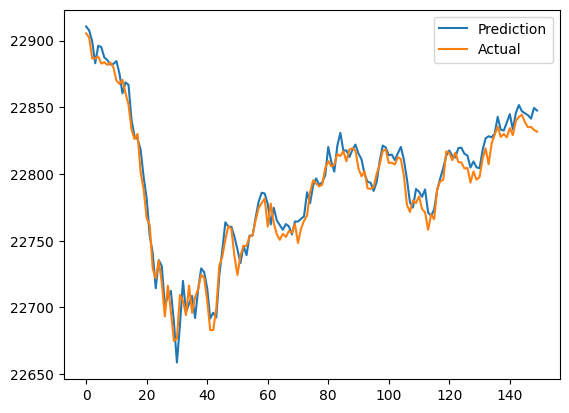

 mape: 0.00039818975142869625,
wape: 0.9995982894219703,
mae: 9.313247648627108,
 mpe: 0.0003169297376482179,
 rmse: 12.162959368670457,
 corr: 0.999955937051155,
r2_score:0.9998524996829602 minmax: 
150 6
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_25 (Conv1D)          (None, 147, 20)           500       
                                                                 
 flatten_25 (Flatten)        (None, 2940)              0         
                                                                 
 dense_25 (Dense)            (None, 1)                 2941      
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3748/3748 [==============================] - ETA: 0s - loss: 4.9174e-04 - root_mean_squared_e

3748/3748 [==============================] - 23s 6ms/step - loss: 4.9174e-04 - root_mean_squared_error: 0.0222 - val_loss: 3.9479e-05 - val_root_mean_squared_error: 0.0063
Epoch 2/20
3746/3748 [============================>.] - ETA: 0s - loss: 3.1577e-05 - root_mean_squared_error: 0.0056

3748/3748 [==============================] - 23s 6ms/step - loss: 3.1569e-05 - root_mean_squared_error: 0.0056 - val_loss: 1.3751e-05 - val_root_mean_squared_error: 0.0037
Epoch 3/20
3748/3748 [==============================] - 23s 6ms/step - loss: 1.7738e-05 - root_mean_squared_error: 0.0042 - val_loss: 4.9844e-04 - val_root_mean_squared_error: 0.0223
Epoch 4/20
3748/3748 [==============================] - 22s 6ms/step - loss: 1.0698e-05 - root_mean_squared_error: 0.0033 - val_loss: 9.0583e-05 - val_root_mean_squared_error: 0.0095
Epoch 5/20
3748/3748 [==============================] - 23s 6ms/step - loss: 1.4354e-05 - root_mean_squared_error: 0.0038 - val_loss: 3.8624e-05 - val_root_mean_squared_error: 0.0062
Epoch 6/20
3746/3748 [============================>.] - ETA: 0s - loss: 1.3699e-05 - root_mean_squared_error: 0.0037

3748/3748 [==============================] - 26s 7ms/step - loss: 1.3695e-05 - root_mean_squared_error: 0.0037 - val_loss: 1.3201e-05 - val_root_mean_squared_error: 0.0036
Epoch 7/20
3748/3748 [==============================] - 23s 6ms/step - loss: 3.1121e-05 - root_mean_squared_error: 0.0056 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1167
Epoch 8/20
3746/3748 [============================>.] - ETA: 0s - loss: 1.1072e-05 - root_mean_squared_error: 0.0033

3748/3748 [==============================] - 23s 6ms/step - loss: 1.1073e-05 - root_mean_squared_error: 0.0033 - val_loss: 8.5209e-06 - val_root_mean_squared_error: 0.0029
Epoch 9/20
3748/3748 [==============================] - 25s 7ms/step - loss: 4.3813e-06 - root_mean_squared_error: 0.0021 - val_loss: 1.3562e-05 - val_root_mean_squared_error: 0.0037
Epoch 10/20
3738/3748 [============================>.] - ETA: 0s - loss: 1.6903e-05 - root_mean_squared_error: 0.0041

3748/3748 [==============================] - 23s 6ms/step - loss: 1.6866e-05 - root_mean_squared_error: 0.0041 - val_loss: 2.2744e-06 - val_root_mean_squared_error: 0.0015
Epoch 11/20
3748/3748 [==============================] - 22s 6ms/step - loss: 4.7815e-06 - root_mean_squared_error: 0.0022 - val_loss: 2.2845e-06 - val_root_mean_squared_error: 0.0015
Epoch 12/20
3748/3748 [==============================] - 24s 6ms/step - loss: 6.6156e-06 - root_mean_squared_error: 0.0026 - val_loss: 3.5720e-05 - val_root_mean_squared_error: 0.0060
Epoch 13/20
3748/3748 [==============================] - 24s 7ms/step - loss: 2.2233e-05 - root_mean_squared_error: 0.0047 - val_loss: 4.2664e-06 - val_root_mean_squared_error: 0.0021
Epoch 14/20
3748/3748 [==============================] - 22s 6ms/step - loss: 2.9287e-06 - root_mean_squared_error: 0.0017 - val_loss: 7.0825e-04 - val_root_mean_squared_error: 0.0266
Epoch 15/20
3747/3748 [============================>.] - ETA: 0s - loss: 7.6632e-06 - root_m

3748/3748 [==============================] - 22s 6ms/step - loss: 7.6629e-06 - root_mean_squared_error: 0.0028 - val_loss: 9.0591e-07 - val_root_mean_squared_error: 9.5179e-04
Epoch 16/20
3748/3748 [==============================] - 25s 7ms/step - loss: 3.4397e-06 - root_mean_squared_error: 0.0019 - val_loss: 2.3432e-06 - val_root_mean_squared_error: 0.0015
Epoch 17/20
3748/3748 [==============================] - 22s 6ms/step - loss: 1.1367e-05 - root_mean_squared_error: 0.0034 - val_loss: 1.8463e-05 - val_root_mean_squared_error: 0.0043
Epoch 18/20
3748/3748 [==============================] - 22s 6ms/step - loss: 1.6830e-05 - root_mean_squared_error: 0.0041 - val_loss: 3.4691e-06 - val_root_mean_squared_error: 0.0019
Epoch 19/20
3748/3748 [==============================] - 21s 6ms/step - loss: 1.6447e-06 - root_mean_squared_error: 0.0013 - val_loss: 5.0847e-06 - val_root_mean_squared_error: 0.0023
Epoch 20/20
1250/1250 [==============================] - 3s 3ms/step
       Test Predict

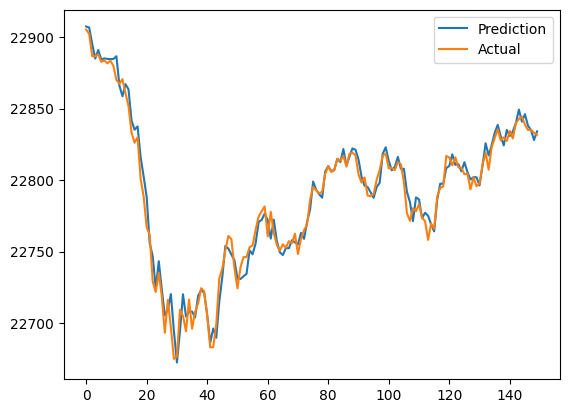

 mape: 0.00027886992747497226,
wape: 0.999720069209266,
mae: 6.489908210454723,
 mpe: 0.00011111977714058306,
 rmse: 9.236868299372421,
 corr: 0.9999611327905064,
r2_score:0.9999149324461343 minmax: 
150 6
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_26 (Conv1D)          (None, 146, 20)           620       
                                                                 
 flatten_26 (Flatten)        (None, 2920)              0         
                                                                 
 dense_26 (Dense)            (None, 1)                 2921      
                                                                 
Total params: 3,541
Trainable params: 3,541
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3748/3748 [==============================] - ETA: 0s - loss: 3.0179e-04 - root_mean_squared_e

3748/3748 [==============================] - 29s 8ms/step - loss: 3.0179e-04 - root_mean_squared_error: 0.0174 - val_loss: 7.7825e-04 - val_root_mean_squared_error: 0.0279
Epoch 2/20
3743/3748 [============================>.] - ETA: 0s - loss: 3.0799e-05 - root_mean_squared_error: 0.0055

3748/3748 [==============================] - 25s 7ms/step - loss: 3.0774e-05 - root_mean_squared_error: 0.0055 - val_loss: 2.7361e-05 - val_root_mean_squared_error: 0.0052
Epoch 3/20
3748/3748 [==============================] - 28s 7ms/step - loss: 1.4033e-05 - root_mean_squared_error: 0.0037 - val_loss: 7.7211e-04 - val_root_mean_squared_error: 0.0278
Epoch 4/20
3746/3748 [============================>.] - ETA: 0s - loss: 1.4587e-05 - root_mean_squared_error: 0.0038

3748/3748 [==============================] - 26s 7ms/step - loss: 1.4583e-05 - root_mean_squared_error: 0.0038 - val_loss: 3.3962e-06 - val_root_mean_squared_error: 0.0018
Epoch 5/20
3748/3748 [==============================] - 27s 7ms/step - loss: 6.7372e-06 - root_mean_squared_error: 0.0026 - val_loss: 1.1714e-05 - val_root_mean_squared_error: 0.0034
Epoch 6/20
3748/3748 [==============================] - 28s 7ms/step - loss: 5.3421e-05 - root_mean_squared_error: 0.0073 - val_loss: 1.0098e-04 - val_root_mean_squared_error: 0.0100
Epoch 7/20
3748/3748 [==============================] - 25s 7ms/step - loss: 8.7643e-06 - root_mean_squared_error: 0.0030 - val_loss: 2.3981e-05 - val_root_mean_squared_error: 0.0049
Epoch 8/20
3748/3748 [==============================] - 28s 8ms/step - loss: 2.2111e-05 - root_mean_squared_error: 0.0047 - val_loss: 8.0698e-05 - val_root_mean_squared_error: 0.0090
Epoch 9/20
3748/3748 [==============================] - 25s 7ms/step - loss: 7.5764e-06 - root_m

3748/3748 [==============================] - 27s 7ms/step - loss: 3.3466e-05 - root_mean_squared_error: 0.0058 - val_loss: 2.7161e-06 - val_root_mean_squared_error: 0.0016
Epoch 13/20
3743/3748 [============================>.] - ETA: 0s - loss: 3.3512e-06 - root_mean_squared_error: 0.0018

3748/3748 [==============================] - 29s 8ms/step - loss: 3.3485e-06 - root_mean_squared_error: 0.0018 - val_loss: 2.0543e-06 - val_root_mean_squared_error: 0.0014
Epoch 14/20
3748/3748 [==============================] - 30s 8ms/step - loss: 5.4552e-05 - root_mean_squared_error: 0.0074 - val_loss: 3.1060e-06 - val_root_mean_squared_error: 0.0018
Epoch 15/20
3744/3748 [============================>.] - ETA: 0s - loss: 1.4597e-06 - root_mean_squared_error: 0.0012

3748/3748 [==============================] - 29s 8ms/step - loss: 1.4588e-06 - root_mean_squared_error: 0.0012 - val_loss: 9.4989e-07 - val_root_mean_squared_error: 9.7462e-04
Epoch 16/20
3748/3748 [==============================] - 28s 7ms/step - loss: 1.5346e-05 - root_mean_squared_error: 0.0039 - val_loss: 1.2037e-05 - val_root_mean_squared_error: 0.0035
Epoch 17/20
3748/3748 [==============================] - 27s 7ms/step - loss: 2.0413e-06 - root_mean_squared_error: 0.0014 - val_loss: 2.0610e-05 - val_root_mean_squared_error: 0.0045
Epoch 18/20
3748/3748 [==============================] - 25s 7ms/step - loss: 5.5778e-05 - root_mean_squared_error: 0.0075 - val_loss: 1.6549e-06 - val_root_mean_squared_error: 0.0013
Epoch 19/20
3748/3748 [==============================] - 28s 7ms/step - loss: 2.6023e-06 - root_mean_squared_error: 0.0016 - val_loss: 3.9462e-06 - val_root_mean_squared_error: 0.0020
Epoch 20/20
1250/1250 [==============================] - 5s 4ms/step
       Test Predict

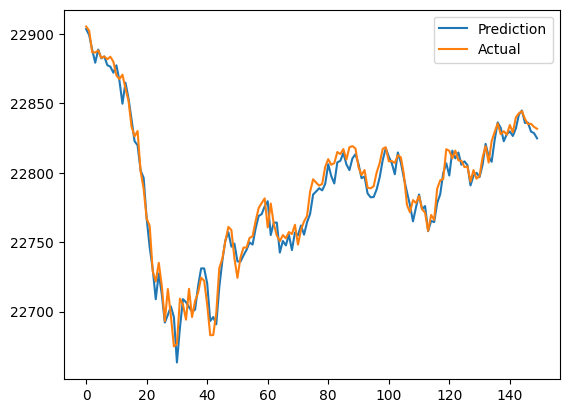

 mape: 0.00027685834510022194,
wape: 0.9997207309660062,
mae: 6.474566059310112,
 mpe: -0.0001265183974969542,
 rmse: 9.425983813620613,
 corr: 0.999960830704657,
r2_score:0.9999114134433166 minmax: 
150 6
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 149, 24)           312       
                                                                 
 flatten_27 (Flatten)        (None, 3576)              0         
                                                                 
 dense_27 (Dense)            (None, 1)                 3577      
                                                                 
Total params: 3,889
Trainable params: 3,889
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3743/3748 [============================>.] - ETA: 0s - loss: 1.5584e-04 - root_mean_squared_e

3748/3748 [==============================] - 27s 7ms/step - loss: 1.5568e-04 - root_mean_squared_error: 0.0125 - val_loss: 7.3312e-05 - val_root_mean_squared_error: 0.0086
Epoch 2/20
3744/3748 [============================>.] - ETA: 0s - loss: 2.6360e-05 - root_mean_squared_error: 0.0051

3748/3748 [==============================] - 23s 6ms/step - loss: 2.6351e-05 - root_mean_squared_error: 0.0051 - val_loss: 1.1454e-05 - val_root_mean_squared_error: 0.0034
Epoch 3/20
3748/3748 [==============================] - 26s 7ms/step - loss: 1.7693e-05 - root_mean_squared_error: 0.0042 - val_loss: 1.3059e-05 - val_root_mean_squared_error: 0.0036
Epoch 4/20
3748/3748 [==============================] - 24s 6ms/step - loss: 9.2584e-06 - root_mean_squared_error: 0.0030 - val_loss: 2.7633e-05 - val_root_mean_squared_error: 0.0053
Epoch 5/20
3748/3748 [==============================] - 23s 6ms/step - loss: 1.0493e-05 - root_mean_squared_error: 0.0032 - val_loss: 1.1836e-05 - val_root_mean_squared_error: 0.0034
Epoch 6/20
3747/3748 [============================>.] - ETA: 0s - loss: 6.4126e-06 - root_mean_squared_error: 0.0025

3748/3748 [==============================] - 27s 7ms/step - loss: 6.4123e-06 - root_mean_squared_error: 0.0025 - val_loss: 2.7844e-06 - val_root_mean_squared_error: 0.0017
Epoch 7/20
3748/3748 [==============================] - 23s 6ms/step - loss: 1.0315e-05 - root_mean_squared_error: 0.0032 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0680
Epoch 8/20
3748/3748 [==============================] - 22s 6ms/step - loss: 6.4056e-06 - root_mean_squared_error: 0.0025 - val_loss: 2.0923e-05 - val_root_mean_squared_error: 0.0046
Epoch 9/20
3748/3748 [==============================] - 22s 6ms/step - loss: 4.1067e-06 - root_mean_squared_error: 0.0020 - val_loss: 9.5816e-06 - val_root_mean_squared_error: 0.0031
Epoch 10/20
3748/3748 [==============================] - 25s 7ms/step - loss: 2.7800e-05 - root_mean_squared_error: 0.0053 - val_loss: 5.5248e-06 - val_root_mean_squared_error: 0.0024
Epoch 11/20
3741/3748 [============================>.] - ETA: 0s - loss: 3.9935e-06 - root_mean_squ

3748/3748 [==============================] - 23s 6ms/step - loss: 3.9890e-06 - root_mean_squared_error: 0.0020 - val_loss: 1.7733e-06 - val_root_mean_squared_error: 0.0013
Epoch 12/20
3748/3748 [==============================] - 25s 7ms/step - loss: 1.1502e-05 - root_mean_squared_error: 0.0034 - val_loss: 6.4730e-06 - val_root_mean_squared_error: 0.0025
Epoch 13/20
3748/3748 [==============================] - 25s 7ms/step - loss: 2.7619e-06 - root_mean_squared_error: 0.0017 - val_loss: 3.8939e-05 - val_root_mean_squared_error: 0.0062
Epoch 14/20
3748/3748 [==============================] - 23s 6ms/step - loss: 6.3154e-06 - root_mean_squared_error: 0.0025 - val_loss: 2.4036e-06 - val_root_mean_squared_error: 0.0016
Epoch 15/20
3745/3748 [============================>.] - ETA: 0s - loss: 6.8695e-06 - root_mean_squared_error: 0.0026

3748/3748 [==============================] - 26s 7ms/step - loss: 6.8657e-06 - root_mean_squared_error: 0.0026 - val_loss: 1.7066e-06 - val_root_mean_squared_error: 0.0013
Epoch 16/20
3748/3748 [==============================] - 25s 7ms/step - loss: 2.8335e-06 - root_mean_squared_error: 0.0017 - val_loss: 1.9080e-05 - val_root_mean_squared_error: 0.0044
Epoch 17/20
3748/3748 [==============================] - 23s 6ms/step - loss: 3.9320e-06 - root_mean_squared_error: 0.0020 - val_loss: 1.4824e-05 - val_root_mean_squared_error: 0.0039
Epoch 18/20
3748/3748 [==============================] - 22s 6ms/step - loss: 2.7075e-06 - root_mean_squared_error: 0.0016 - val_loss: 1.4760e-04 - val_root_mean_squared_error: 0.0121
Epoch 19/20
3748/3748 [==============================] - 25s 7ms/step - loss: 1.5224e-05 - root_mean_squared_error: 0.0039 - val_loss: 3.6177e-05 - val_root_mean_squared_error: 0.0060
Epoch 20/20
1250/1250 [==============================] - 4s 3ms/step
       Test Predictions

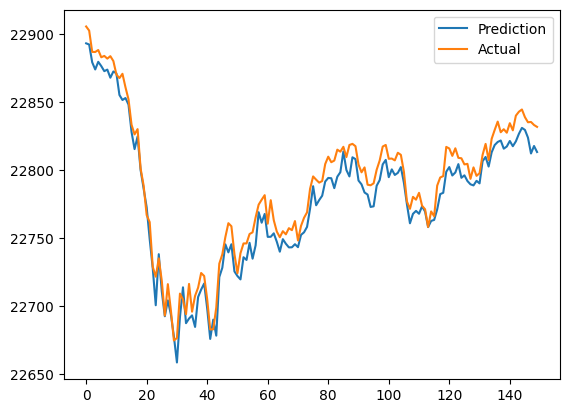

 mape: 0.0005508905673903857,
wape: 0.999445133310274,
mae: 12.86401497998498,
 mpe: -0.0005226887648957441,
 rmse: 14.84601746724663,
 corr: 0.9999677304987942,
r2_score:0.999780247220799 minmax: 
150 6
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 148, 24)           456       
                                                                 
 flatten_28 (Flatten)        (None, 3552)              0         
                                                                 
 dense_28 (Dense)            (None, 1)                 3553      
                                                                 
Total params: 4,009
Trainable params: 4,009
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3741/3748 [============================>.] - ETA: 0s - loss: 1.5739e-04 - root_mean_squared_err

3748/3748 [==============================] - 28s 7ms/step - loss: 1.5716e-04 - root_mean_squared_error: 0.0125 - val_loss: 1.8469e-04 - val_root_mean_squared_error: 0.0136
Epoch 2/20
3741/3748 [============================>.] - ETA: 0s - loss: 1.8597e-05 - root_mean_squared_error: 0.0043

3748/3748 [==============================] - 23s 6ms/step - loss: 1.8583e-05 - root_mean_squared_error: 0.0043 - val_loss: 1.4102e-05 - val_root_mean_squared_error: 0.0038
Epoch 3/20
3739/3748 [============================>.] - ETA: 0s - loss: 1.1111e-05 - root_mean_squared_error: 0.0033

3748/3748 [==============================] - 23s 6ms/step - loss: 1.1099e-05 - root_mean_squared_error: 0.0033 - val_loss: 5.0465e-06 - val_root_mean_squared_error: 0.0022
Epoch 4/20
3748/3748 [==============================] - 24s 6ms/step - loss: 9.8447e-06 - root_mean_squared_error: 0.0031 - val_loss: 2.6868e-04 - val_root_mean_squared_error: 0.0164
Epoch 5/20
3748/3748 [==============================] - 23s 6ms/step - loss: 8.6569e-06 - root_mean_squared_error: 0.0029 - val_loss: 4.4992e-05 - val_root_mean_squared_error: 0.0067
Epoch 6/20
3748/3748 [==============================] - 22s 6ms/step - loss: 2.7451e-05 - root_mean_squared_error: 0.0052 - val_loss: 5.8846e-06 - val_root_mean_squared_error: 0.0024
Epoch 7/20
3748/3748 [==============================] - 26s 7ms/step - loss: 2.7130e-06 - root_mean_squared_error: 0.0016 - val_loss: 8.9604e-06 - val_root_mean_squared_error: 0.0030
Epoch 8/20
3741/3748 [============================>.] - ETA: 0s - loss: 9.4604e-05 - root_mean_s

3748/3748 [==============================] - 23s 6ms/step - loss: 9.4452e-05 - root_mean_squared_error: 0.0097 - val_loss: 2.8897e-06 - val_root_mean_squared_error: 0.0017
Epoch 9/20
3748/3748 [==============================] - 25s 7ms/step - loss: 3.4998e-06 - root_mean_squared_error: 0.0019 - val_loss: 4.0977e-06 - val_root_mean_squared_error: 0.0020
Epoch 10/20
3748/3748 [==============================] - 27s 7ms/step - loss: 3.0969e-06 - root_mean_squared_error: 0.0018 - val_loss: 1.2910e-04 - val_root_mean_squared_error: 0.0114
Epoch 11/20
3748/3748 [==============================] - 25s 7ms/step - loss: 2.9131e-05 - root_mean_squared_error: 0.0054 - val_loss: 4.7776e-06 - val_root_mean_squared_error: 0.0022
Epoch 12/20
3748/3748 [==============================] - 23s 6ms/step - loss: 2.4116e-06 - root_mean_squared_error: 0.0016 - val_loss: 5.2454e-06 - val_root_mean_squared_error: 0.0023
Epoch 13/20
3748/3748 [==============================] - 23s 6ms/step - loss: 4.5214e-06 - ro

3748/3748 [==============================] - 25s 7ms/step - loss: 4.6299e-06 - root_mean_squared_error: 0.0022 - val_loss: 9.4970e-07 - val_root_mean_squared_error: 9.7453e-04
Epoch 16/20
3748/3748 [==============================] - 22s 6ms/step - loss: 3.9679e-06 - root_mean_squared_error: 0.0020 - val_loss: 1.1115e-06 - val_root_mean_squared_error: 0.0011
Epoch 17/20
3748/3748 [==============================] - 22s 6ms/step - loss: 1.1586e-05 - root_mean_squared_error: 0.0034 - val_loss: 1.9920e-05 - val_root_mean_squared_error: 0.0045
Epoch 18/20
3748/3748 [==============================] - 22s 6ms/step - loss: 3.0570e-06 - root_mean_squared_error: 0.0017 - val_loss: 2.1836e-06 - val_root_mean_squared_error: 0.0015
Epoch 19/20
3748/3748 [==============================] - 27s 7ms/step - loss: 3.0954e-05 - root_mean_squared_error: 0.0056 - val_loss: 7.7251e-05 - val_root_mean_squared_error: 0.0088
Epoch 20/20
1250/1250 [==============================] - 4s 3ms/step
       Test Predict

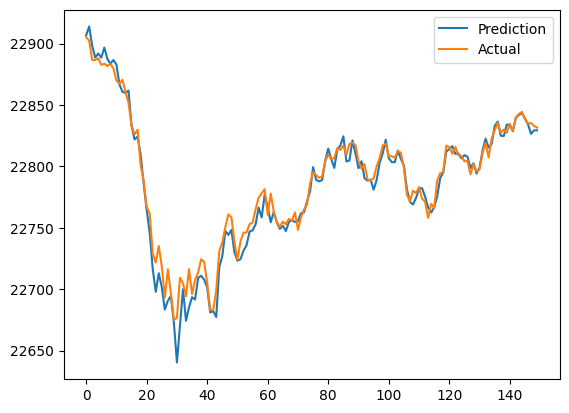

 mape: 0.0003060785203394752,
wape: 0.9996920917052158,
mae: 7.138537940564786,
 mpe: -0.00013078001875051158,
 rmse: 10.736056689781119,
 corr: 0.99994885057579,
r2_score:0.9998850777728192 minmax: 
150 6
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_29 (Conv1D)          (None, 147, 24)           600       
                                                                 
 flatten_29 (Flatten)        (None, 3528)              0         
                                                                 
 dense_29 (Dense)            (None, 1)                 3529      
                                                                 
Total params: 4,129
Trainable params: 4,129
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3743/3748 [============================>.] - ETA: 0s - loss: 3.6075e-04 - root_mean_squared_e

3748/3748 [==============================] - 24s 6ms/step - loss: 3.6040e-04 - root_mean_squared_error: 0.0190 - val_loss: 3.5869e-05 - val_root_mean_squared_error: 0.0060
Epoch 2/20
3743/3748 [============================>.] - ETA: 0s - loss: 2.3069e-05 - root_mean_squared_error: 0.0048

3748/3748 [==============================] - 26s 7ms/step - loss: 2.3053e-05 - root_mean_squared_error: 0.0048 - val_loss: 6.8292e-06 - val_root_mean_squared_error: 0.0026
Epoch 3/20
3748/3748 [==============================] - 23s 6ms/step - loss: 1.1642e-05 - root_mean_squared_error: 0.0034 - val_loss: 2.8456e-04 - val_root_mean_squared_error: 0.0169
Epoch 4/20
3748/3748 [==============================] - 23s 6ms/step - loss: 4.2114e-05 - root_mean_squared_error: 0.0065 - val_loss: 1.2877e-05 - val_root_mean_squared_error: 0.0036
Epoch 5/20
3739/3748 [============================>.] - ETA: 0s - loss: 2.3614e-06 - root_mean_squared_error: 0.0015

3748/3748 [==============================] - 24s 6ms/step - loss: 2.3579e-06 - root_mean_squared_error: 0.0015 - val_loss: 2.4324e-06 - val_root_mean_squared_error: 0.0016
Epoch 6/20
3748/3748 [==============================] - 25s 7ms/step - loss: 1.5764e-05 - root_mean_squared_error: 0.0040 - val_loss: 3.3635e-05 - val_root_mean_squared_error: 0.0058
Epoch 7/20
3748/3748 [==============================] - 23s 6ms/step - loss: 5.9518e-06 - root_mean_squared_error: 0.0024 - val_loss: 2.4410e-06 - val_root_mean_squared_error: 0.0016
Epoch 8/20
3748/3748 [==============================] - 22s 6ms/step - loss: 2.0488e-05 - root_mean_squared_error: 0.0045 - val_loss: 2.0208e-05 - val_root_mean_squared_error: 0.0045
Epoch 9/20
3748/3748 [==============================] - 25s 7ms/step - loss: 4.5711e-06 - root_mean_squared_error: 0.0021 - val_loss: 9.6050e-06 - val_root_mean_squared_error: 0.0031
Epoch 10/20
3748/3748 [==============================] - 26s 7ms/step - loss: 3.6584e-05 - root_

3748/3748 [==============================] - 24s 6ms/step - loss: 5.5918e-05 - root_mean_squared_error: 0.0075 - val_loss: 1.3660e-06 - val_root_mean_squared_error: 0.0012
Epoch 15/20
3748/3748 [==============================] - 23s 6ms/step - loss: 1.1477e-06 - root_mean_squared_error: 0.0011 - val_loss: 9.3748e-06 - val_root_mean_squared_error: 0.0031
Epoch 16/20
3748/3748 [==============================] - 26s 7ms/step - loss: 1.2704e-05 - root_mean_squared_error: 0.0036 - val_loss: 3.1327e-06 - val_root_mean_squared_error: 0.0018
Epoch 17/20
3744/3748 [============================>.] - ETA: 0s - loss: 2.3044e-06 - root_mean_squared_error: 0.0015

3748/3748 [==============================] - 24s 6ms/step - loss: 2.3033e-06 - root_mean_squared_error: 0.0015 - val_loss: 8.6793e-07 - val_root_mean_squared_error: 9.3163e-04
Epoch 18/20
3748/3748 [==============================] - 23s 6ms/step - loss: 1.8474e-05 - root_mean_squared_error: 0.0043 - val_loss: 7.4974e-05 - val_root_mean_squared_error: 0.0087
Epoch 19/20
3738/3748 [============================>.] - ETA: 0s - loss: 3.9193e-06 - root_mean_squared_error: 0.0020

3748/3748 [==============================] - 26s 7ms/step - loss: 3.9115e-06 - root_mean_squared_error: 0.0020 - val_loss: 7.6031e-07 - val_root_mean_squared_error: 8.7196e-04
Epoch 20/20
1250/1250 [==============================] - 4s 3ms/step
       Test Predictions   Actuals
0          22906.886719  22905.32
1          22910.970703  22902.29
2          22894.046875  22886.67
3          22886.523438  22886.61
4          22893.548828  22888.05
...                 ...       ...
39965      22538.210938  22542.26
39966      22547.964844  22533.65
39967      22536.814453  22530.37
39968      22524.576172  22520.83
39969      22533.923828  22524.46

[39970 rows x 2 columns]


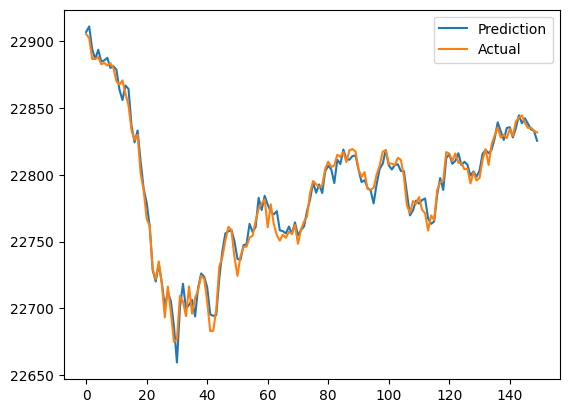

 mape: 0.0002468798405631811,
wape: 0.9997517969217753,
mae: 5.75433374444897,
 mpe: 9.28500353227095e-05,
 rmse: 8.4320953961336,
 corr: 0.9999668711162034,
r2_score:0.9999291099203307 minmax: 
150 6
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 146, 24)           744       
                                                                 
 flatten_30 (Flatten)        (None, 3504)              0         
                                                                 
 dense_30 (Dense)            (None, 1)                 3505      
                                                                 
Total params: 4,249
Trainable params: 4,249
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3745/3748 [============================>.] - ETA: 0s - loss: 1.0295e-04 - root_mean_squared_error:

3748/3748 [==============================] - 31s 8ms/step - loss: 1.0289e-04 - root_mean_squared_error: 0.0101 - val_loss: 1.9523e-05 - val_root_mean_squared_error: 0.0044
Epoch 2/20
3748/3748 [==============================] - 29s 8ms/step - loss: 2.0196e-05 - root_mean_squared_error: 0.0045 - val_loss: 6.4388e-05 - val_root_mean_squared_error: 0.0080
Epoch 3/20
3747/3748 [============================>.] - ETA: 0s - loss: 5.4879e-05 - root_mean_squared_error: 0.0074

3748/3748 [==============================] - 28s 8ms/step - loss: 5.4877e-05 - root_mean_squared_error: 0.0074 - val_loss: 2.5762e-06 - val_root_mean_squared_error: 0.0016
Epoch 4/20
3748/3748 [==============================] - 28s 7ms/step - loss: 3.9668e-06 - root_mean_squared_error: 0.0020 - val_loss: 1.0796e-04 - val_root_mean_squared_error: 0.0104
Epoch 5/20
3748/3748 [==============================] - 28s 7ms/step - loss: 8.0959e-06 - root_mean_squared_error: 0.0028 - val_loss: 3.6389e-05 - val_root_mean_squared_error: 0.0060
Epoch 6/20
3748/3748 [==============================] - 25s 7ms/step - loss: 4.3358e-05 - root_mean_squared_error: 0.0066 - val_loss: 7.8221e-06 - val_root_mean_squared_error: 0.0028
Epoch 7/20
3748/3748 [==============================] - 28s 7ms/step - loss: 4.4424e-06 - root_mean_squared_error: 0.0021 - val_loss: 9.1133e-05 - val_root_mean_squared_error: 0.0095
Epoch 8/20
3748/3748 [==============================] - 26s 7ms/step - loss: 1.0932e-04 - root_m

3748/3748 [==============================] - 29s 8ms/step - loss: 1.5839e-06 - root_mean_squared_error: 0.0013 - val_loss: 2.5579e-06 - val_root_mean_squared_error: 0.0016
Epoch 10/20
3748/3748 [==============================] - 28s 7ms/step - loss: 3.3179e-05 - root_mean_squared_error: 0.0058 - val_loss: 3.4096e-06 - val_root_mean_squared_error: 0.0018
Epoch 11/20
3748/3748 [==============================] - 28s 7ms/step - loss: 3.7675e-06 - root_mean_squared_error: 0.0019 - val_loss: 2.2163e-05 - val_root_mean_squared_error: 0.0047
Epoch 12/20
3748/3748 [==============================] - 28s 8ms/step - loss: 4.6913e-06 - root_mean_squared_error: 0.0022 - val_loss: 3.6299e-06 - val_root_mean_squared_error: 0.0019
Epoch 13/20
3748/3748 [==============================] - 28s 7ms/step - loss: 7.2232e-05 - root_mean_squared_error: 0.0085 - val_loss: 5.4399e-06 - val_root_mean_squared_error: 0.0023
Epoch 14/20
3748/3748 [==============================] - 26s 7ms/step - loss: 3.3946e-06 - r

3748/3748 [==============================] - 29s 8ms/step - loss: 2.1486e-05 - root_mean_squared_error: 0.0046 - val_loss: 1.6029e-06 - val_root_mean_squared_error: 0.0013
Epoch 18/20
3748/3748 [==============================] - 28s 7ms/step - loss: 2.0570e-06 - root_mean_squared_error: 0.0014 - val_loss: 5.3138e-06 - val_root_mean_squared_error: 0.0023
Epoch 19/20
3748/3748 [==============================] - ETA: 0s - loss: 4.5967e-05 - root_mean_squared_error: 0.0068

3748/3748 [==============================] - 30s 8ms/step - loss: 4.5967e-05 - root_mean_squared_error: 0.0068 - val_loss: 9.4726e-07 - val_root_mean_squared_error: 9.7327e-04
Epoch 20/20
1250/1250 [==============================] - 4s 3ms/step
       Test Predictions   Actuals
0          22909.593750  22905.32
1          22903.441406  22902.29
2          22900.230469  22886.67
3          22886.068359  22886.61
4          22892.828125  22888.05
...                 ...       ...
39965      22545.345703  22542.26
39966      22539.744141  22533.65
39967      22536.820312  22530.37
39968      22524.261719  22520.83
39969      22529.189453  22524.46

[39970 rows x 2 columns]


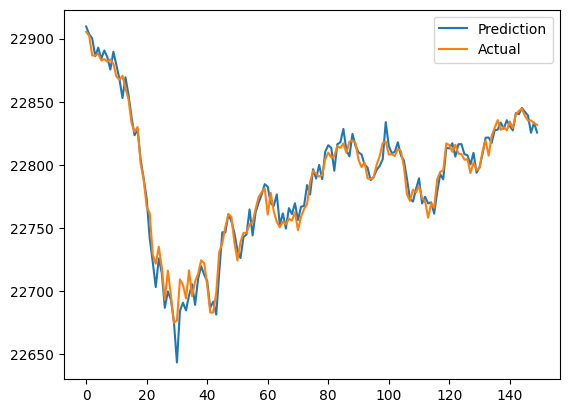

 mape: 0.00028406764729267865,
wape: 0.9997141444850152,
mae: 6.627266864210658,
 mpe: 1.044880313461096e-05,
 rmse: 9.695751808458107,
 corr: 0.9999532445811874,
r2_score:0.9999062702579736 minmax: 
150 6
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_31 (Conv1D)          (None, 149, 28)           364       
                                                                 
 flatten_31 (Flatten)        (None, 4172)              0         
                                                                 
 dense_31 (Dense)            (None, 1)                 4173      
                                                                 
Total params: 4,537
Trainable params: 4,537
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3742/3748 [============================>.] - ETA: 0s - loss: 2.5050e-04 - root_mean_squared_e

3748/3748 [==============================] - 30s 8ms/step - loss: 2.5020e-04 - root_mean_squared_error: 0.0158 - val_loss: 2.6418e-05 - val_root_mean_squared_error: 0.0051
Epoch 2/20
3739/3748 [============================>.] - ETA: 0s - loss: 3.1479e-05 - root_mean_squared_error: 0.0056

3748/3748 [==============================] - 29s 8ms/step - loss: 3.1443e-05 - root_mean_squared_error: 0.0056 - val_loss: 2.1100e-05 - val_root_mean_squared_error: 0.0046
Epoch 3/20
3745/3748 [============================>.] - ETA: 0s - loss: 1.6345e-05 - root_mean_squared_error: 0.0040

3748/3748 [==============================] - 26s 7ms/step - loss: 1.6341e-05 - root_mean_squared_error: 0.0040 - val_loss: 1.1174e-05 - val_root_mean_squared_error: 0.0033
Epoch 4/20
3748/3748 [==============================] - 27s 7ms/step - loss: 1.3368e-05 - root_mean_squared_error: 0.0037 - val_loss: 1.1837e-05 - val_root_mean_squared_error: 0.0034
Epoch 5/20
3748/3748 [==============================] - 30s 8ms/step - loss: 8.2416e-06 - root_mean_squared_error: 0.0029 - val_loss: 4.9406e-04 - val_root_mean_squared_error: 0.0222
Epoch 6/20
3748/3748 [==============================] - 28s 7ms/step - loss: 6.6781e-06 - root_mean_squared_error: 0.0026 - val_loss: 1.1739e-05 - val_root_mean_squared_error: 0.0034
Epoch 7/20
3748/3748 [==============================] - 27s 7ms/step - loss: 1.1496e-05 - root_mean_squared_error: 0.0034 - val_loss: 2.0206e-05 - val_root_mean_squared_error: 0.0045
Epoch 8/20
3748/3748 [==============================] - 28s 7ms/step - loss: 1.3548e-05 - root_m

3748/3748 [==============================] - 27s 7ms/step - loss: 1.3970e-05 - root_mean_squared_error: 0.0037 - val_loss: 2.3932e-06 - val_root_mean_squared_error: 0.0015
Epoch 13/20
3748/3748 [==============================] - 26s 7ms/step - loss: 2.2042e-06 - root_mean_squared_error: 0.0015 - val_loss: 3.6276e-06 - val_root_mean_squared_error: 0.0019
Epoch 14/20
3748/3748 [==============================] - 26s 7ms/step - loss: 3.7084e-06 - root_mean_squared_error: 0.0019 - val_loss: 3.9124e-05 - val_root_mean_squared_error: 0.0063
Epoch 15/20
3741/3748 [============================>.] - ETA: 0s - loss: 6.1109e-06 - root_mean_squared_error: 0.0025

3748/3748 [==============================] - 29s 8ms/step - loss: 6.1021e-06 - root_mean_squared_error: 0.0025 - val_loss: 1.9347e-06 - val_root_mean_squared_error: 0.0014
Epoch 16/20
3744/3748 [============================>.] - ETA: 0s - loss: 1.0190e-05 - root_mean_squared_error: 0.0032

3748/3748 [==============================] - 28s 8ms/step - loss: 1.0182e-05 - root_mean_squared_error: 0.0032 - val_loss: 1.5572e-06 - val_root_mean_squared_error: 0.0012
Epoch 17/20
3748/3748 [==============================] - 28s 7ms/step - loss: 1.3048e-06 - root_mean_squared_error: 0.0011 - val_loss: 1.1606e-05 - val_root_mean_squared_error: 0.0034
Epoch 18/20
3748/3748 [==============================] - 27s 7ms/step - loss: 5.8256e-06 - root_mean_squared_error: 0.0024 - val_loss: 2.2781e-06 - val_root_mean_squared_error: 0.0015
Epoch 19/20
3748/3748 [==============================] - 25s 7ms/step - loss: 2.0202e-06 - root_mean_squared_error: 0.0014 - val_loss: 9.2267e-06 - val_root_mean_squared_error: 0.0030
Epoch 20/20
1250/1250 [==============================] - 4s 3ms/step
       Test Predictions   Actuals
0          22898.544922  22905.32
1          22906.710938  22902.29
2          22894.197266  22886.67
3          22888.007812  22886.61
4          22887.847656  22888.05
...

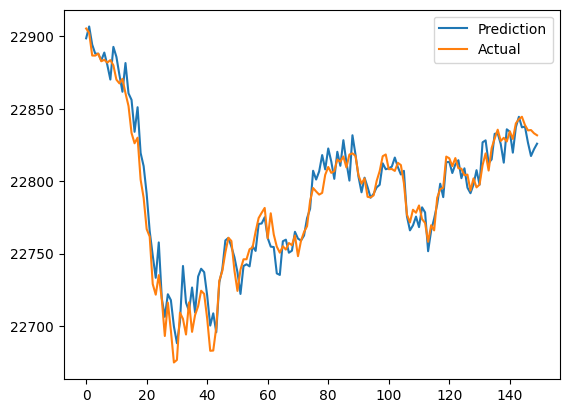

 mape: 0.00037454933479893283,
wape: 0.9996236566313141,
mae: 8.725134923458231,
 mpe: 0.00010364255494378237,
 rmse: 12.435486396061881,
 corr: 0.9999257675108602,
r2_score:0.9998458157561076 minmax: 
150 6
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 148, 28)           532       
                                                                 
 flatten_32 (Flatten)        (None, 4144)              0         
                                                                 
 dense_32 (Dense)            (None, 1)                 4145      
                                                                 
Total params: 4,677
Trainable params: 4,677
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3745/3748 [============================>.] - ETA: 0s - loss: 1.6798e-04 - root_mean_squared

3748/3748 [==============================] - 31s 8ms/step - loss: 1.6790e-04 - root_mean_squared_error: 0.0130 - val_loss: 1.0532e-04 - val_root_mean_squared_error: 0.0103
Epoch 2/20
3741/3748 [============================>.] - ETA: 0s - loss: 2.2173e-05 - root_mean_squared_error: 0.0047

3748/3748 [==============================] - 28s 7ms/step - loss: 2.2152e-05 - root_mean_squared_error: 0.0047 - val_loss: 2.1225e-05 - val_root_mean_squared_error: 0.0046
Epoch 3/20
3748/3748 [==============================] - 24s 6ms/step - loss: 1.4395e-05 - root_mean_squared_error: 0.0038 - val_loss: 3.1092e-04 - val_root_mean_squared_error: 0.0176
Epoch 4/20
3747/3748 [============================>.] - ETA: 0s - loss: 2.6150e-05 - root_mean_squared_error: 0.0051

3748/3748 [==============================] - 30s 8ms/step - loss: 2.6149e-05 - root_mean_squared_error: 0.0051 - val_loss: 7.9831e-06 - val_root_mean_squared_error: 0.0028
Epoch 5/20
3748/3748 [==============================] - 27s 7ms/step - loss: 6.2242e-06 - root_mean_squared_error: 0.0025 - val_loss: 1.3060e-05 - val_root_mean_squared_error: 0.0036
Epoch 6/20
3746/3748 [============================>.] - ETA: 0s - loss: 3.1178e-05 - root_mean_squared_error: 0.0056

3748/3748 [==============================] - 26s 7ms/step - loss: 3.1170e-05 - root_mean_squared_error: 0.0056 - val_loss: 2.1847e-06 - val_root_mean_squared_error: 0.0015
Epoch 7/20
3748/3748 [==============================] - 27s 7ms/step - loss: 4.6993e-06 - root_mean_squared_error: 0.0022 - val_loss: 1.3713e-05 - val_root_mean_squared_error: 0.0037
Epoch 8/20
3748/3748 [==============================] - 24s 6ms/step - loss: 2.5795e-05 - root_mean_squared_error: 0.0051 - val_loss: 1.2330e-05 - val_root_mean_squared_error: 0.0035
Epoch 9/20
3748/3748 [==============================] - 26s 7ms/step - loss: 1.2009e-05 - root_mean_squared_error: 0.0035 - val_loss: 7.0515e-05 - val_root_mean_squared_error: 0.0084
Epoch 10/20
3748/3748 [==============================] - 25s 7ms/step - loss: 3.7114e-06 - root_mean_squared_error: 0.0019 - val_loss: 1.5008e-05 - val_root_mean_squared_error: 0.0039
Epoch 11/20
3748/3748 [==============================] - 28s 7ms/step - loss: 1.5535e-05 - root

3748/3748 [==============================] - 26s 7ms/step - loss: 5.8001e-06 - root_mean_squared_error: 0.0024 - val_loss: 1.4791e-06 - val_root_mean_squared_error: 0.0012
Epoch 14/20
3748/3748 [==============================] - 27s 7ms/step - loss: 4.2898e-05 - root_mean_squared_error: 0.0065 - val_loss: 1.6806e-06 - val_root_mean_squared_error: 0.0013
Epoch 15/20
3748/3748 [==============================] - 27s 7ms/step - loss: 2.0374e-06 - root_mean_squared_error: 0.0014 - val_loss: 1.0665e-05 - val_root_mean_squared_error: 0.0033
Epoch 16/20
3748/3748 [==============================] - 25s 7ms/step - loss: 4.1055e-06 - root_mean_squared_error: 0.0020 - val_loss: 1.4816e-06 - val_root_mean_squared_error: 0.0012
Epoch 17/20
3748/3748 [==============================] - 27s 7ms/step - loss: 4.5252e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.9452e-06 - val_root_mean_squared_error: 0.0014
Epoch 18/20
3748/3748 [==============================] - 26s 7ms/step - loss: 3.8680e-06 - r

1250/1250 [==============================] - 4s 3ms/step
       Test Predictions   Actuals
0          22909.667969  22905.32
1          22915.853516  22902.29
2          22902.525391  22886.67
3          22888.853516  22886.61
4          22897.480469  22888.05
...                 ...       ...
39965      22538.150391  22542.26
39966      22543.878906  22533.65
39967      22535.306641  22530.37
39968      22522.103516  22520.83
39969      22529.335938  22524.46

[39970 rows x 2 columns]


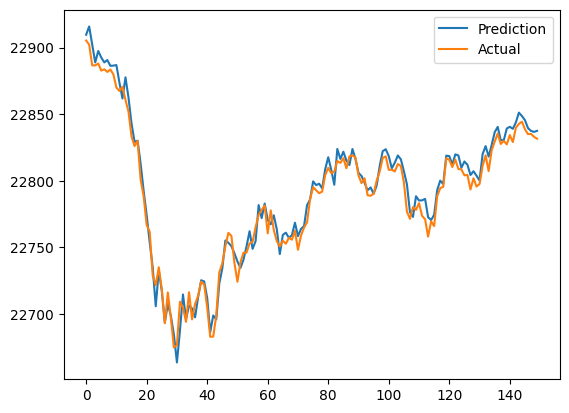

 mape: 0.0003056549578078743,
wape: 0.9996927720643138,
mae: 7.122764512837771,
 mpe: 0.0001930199211387869,
 rmse: 9.402325144593966,
 corr: 0.9999662169695894,
r2_score:0.9999118575794085 minmax: 
150 6
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_33 (Conv1D)          (None, 147, 28)           700       
                                                                 
 flatten_33 (Flatten)        (None, 4116)              0         
                                                                 
 dense_33 (Dense)            (None, 1)                 4117      
                                                                 
Total params: 4,817
Trainable params: 4,817
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3746/3748 [============================>.] - ETA: 0s - loss: 1.8613e-04 - root_mean_squared_er

3748/3748 [==============================] - 28s 7ms/step - loss: 1.8607e-04 - root_mean_squared_error: 0.0136 - val_loss: 1.6847e-04 - val_root_mean_squared_error: 0.0130
Epoch 2/20
3748/3748 [==============================] - 25s 7ms/step - loss: 2.8529e-05 - root_mean_squared_error: 0.0053 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 3/20
3746/3748 [============================>.] - ETA: 0s - loss: 1.2005e-05 - root_mean_squared_error: 0.0035

3748/3748 [==============================] - 26s 7ms/step - loss: 1.2003e-05 - root_mean_squared_error: 0.0035 - val_loss: 8.9750e-06 - val_root_mean_squared_error: 0.0030
Epoch 4/20
3748/3748 [==============================] - 24s 6ms/step - loss: 5.5680e-05 - root_mean_squared_error: 0.0075 - val_loss: 7.4057e-05 - val_root_mean_squared_error: 0.0086
Epoch 5/20
3744/3748 [============================>.] - ETA: 0s - loss: 2.9119e-06 - root_mean_squared_error: 0.0017

3748/3748 [==============================] - 27s 7ms/step - loss: 2.9128e-06 - root_mean_squared_error: 0.0017 - val_loss: 3.1432e-06 - val_root_mean_squared_error: 0.0018
Epoch 6/20
3748/3748 [==============================] - 29s 8ms/step - loss: 1.2030e-05 - root_mean_squared_error: 0.0035 - val_loss: 4.4790e-06 - val_root_mean_squared_error: 0.0021
Epoch 7/20
3748/3748 [==============================] - 26s 7ms/step - loss: 4.8101e-06 - root_mean_squared_error: 0.0022 - val_loss: 1.7616e-05 - val_root_mean_squared_error: 0.0042
Epoch 8/20
3748/3748 [==============================] - 25s 7ms/step - loss: 7.7459e-06 - root_mean_squared_error: 0.0028 - val_loss: 6.2704e-06 - val_root_mean_squared_error: 0.0025
Epoch 9/20
3748/3748 [==============================] - 25s 7ms/step - loss: 5.6077e-05 - root_mean_squared_error: 0.0075 - val_loss: 9.2274e-05 - val_root_mean_squared_error: 0.0096
Epoch 10/20
3748/3748 [==============================] - 28s 7ms/step - loss: 3.7814e-06 - root_

3748/3748 [==============================] - 29s 8ms/step - loss: 4.4338e-05 - root_mean_squared_error: 0.0067 - val_loss: 2.4763e-06 - val_root_mean_squared_error: 0.0016
Epoch 14/20
3746/3748 [============================>.] - ETA: 0s - loss: 4.8543e-06 - root_mean_squared_error: 0.0022

3748/3748 [==============================] - 27s 7ms/step - loss: 4.8528e-06 - root_mean_squared_error: 0.0022 - val_loss: 1.1515e-06 - val_root_mean_squared_error: 0.0011
Epoch 15/20
3748/3748 [==============================] - 29s 8ms/step - loss: 1.6469e-05 - root_mean_squared_error: 0.0041 - val_loss: 2.0799e-06 - val_root_mean_squared_error: 0.0014
Epoch 16/20
3748/3748 [==============================] - 28s 7ms/step - loss: 1.2218e-06 - root_mean_squared_error: 0.0011 - val_loss: 1.1665e-06 - val_root_mean_squared_error: 0.0011
Epoch 17/20
3748/3748 [==============================] - 28s 7ms/step - loss: 5.9940e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.3090e-06 - val_root_mean_squared_error: 0.0011
Epoch 18/20
3748/3748 [==============================] - 27s 7ms/step - loss: 9.8267e-07 - root_mean_squared_error: 9.9130e-04 - val_loss: 3.3667e-06 - val_root_mean_squared_error: 0.0018
Epoch 19/20
3748/3748 [==============================] - 26s 7ms/step - loss: 2.9783e-06

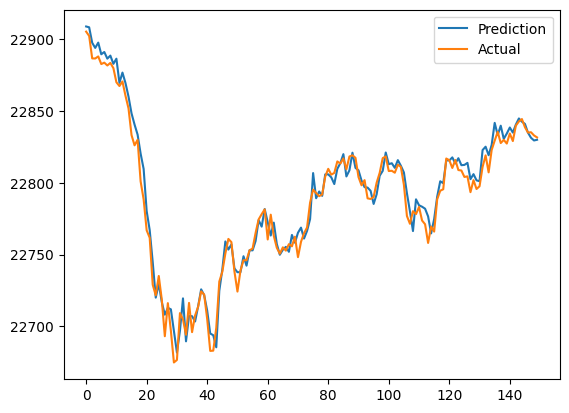

 mape: 0.0003123362644809162,
wape: 0.9996863659820501,
mae: 7.2712829583125025,
 mpe: 0.0002140916418360498,
 rmse: 10.21936722129399,
 corr: 0.9999603207031889,
r2_score:0.9998958732166509 minmax: 
150 6
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_34 (Conv1D)          (None, 146, 28)           868       
                                                                 
 flatten_34 (Flatten)        (None, 4088)              0         
                                                                 
 dense_34 (Dense)            (None, 1)                 4089      
                                                                 
Total params: 4,957
Trainable params: 4,957
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3744/3748 [============================>.] - ETA: 0s - loss: 1.1120e-04 - root_mean_squared_e

3748/3748 [==============================] - 33s 9ms/step - loss: 1.1112e-04 - root_mean_squared_error: 0.0105 - val_loss: 1.3351e-05 - val_root_mean_squared_error: 0.0037
Epoch 2/20
3748/3748 [==============================] - 31s 8ms/step - loss: 1.9970e-05 - root_mean_squared_error: 0.0045 - val_loss: 1.6509e-04 - val_root_mean_squared_error: 0.0128
Epoch 3/20
3748/3748 [==============================] - 31s 8ms/step - loss: 1.6390e-05 - root_mean_squared_error: 0.0040 - val_loss: 2.4273e-05 - val_root_mean_squared_error: 0.0049
Epoch 4/20
3743/3748 [============================>.] - ETA: 0s - loss: 3.5858e-05 - root_mean_squared_error: 0.0060

3748/3748 [==============================] - 30s 8ms/step - loss: 3.5820e-05 - root_mean_squared_error: 0.0060 - val_loss: 6.0850e-06 - val_root_mean_squared_error: 0.0025
Epoch 5/20
3748/3748 [==============================] - 29s 8ms/step - loss: 5.6786e-06 - root_mean_squared_error: 0.0024 - val_loss: 6.6508e-04 - val_root_mean_squared_error: 0.0258
Epoch 6/20
3746/3748 [============================>.] - ETA: 0s - loss: 9.5687e-05 - root_mean_squared_error: 0.0098

3748/3748 [==============================] - 31s 8ms/step - loss: 9.5657e-05 - root_mean_squared_error: 0.0098 - val_loss: 2.7837e-06 - val_root_mean_squared_error: 0.0017
Epoch 7/20
3747/3748 [============================>.] - ETA: 0s - loss: 2.6112e-06 - root_mean_squared_error: 0.0016

3748/3748 [==============================] - 32s 8ms/step - loss: 2.6111e-06 - root_mean_squared_error: 0.0016 - val_loss: 2.0749e-06 - val_root_mean_squared_error: 0.0014
Epoch 8/20
3748/3748 [==============================] - 31s 8ms/step - loss: 2.9692e-05 - root_mean_squared_error: 0.0054 - val_loss: 6.1656e-04 - val_root_mean_squared_error: 0.0248
Epoch 9/20
3748/3748 [==============================] - 32s 8ms/step - loss: 7.4332e-06 - root_mean_squared_error: 0.0027 - val_loss: 4.1589e-06 - val_root_mean_squared_error: 0.0020
Epoch 10/20
3748/3748 [==============================] - 30s 8ms/step - loss: 3.7945e-05 - root_mean_squared_error: 0.0062 - val_loss: 1.6616e-05 - val_root_mean_squared_error: 0.0041
Epoch 11/20
3748/3748 [==============================] - 29s 8ms/step - loss: 2.4190e-06 - root_mean_squared_error: 0.0016 - val_loss: 5.3648e-06 - val_root_mean_squared_error: 0.0023
Epoch 12/20
3748/3748 [==============================] - 27s 7ms/step - loss: 1.5570e-04 - roo

3748/3748 [==============================] - 32s 9ms/step - loss: 3.8089e-05 - root_mean_squared_error: 0.0062 - val_loss: 1.5154e-06 - val_root_mean_squared_error: 0.0012
Epoch 17/20
3748/3748 [==============================] - 32s 9ms/step - loss: 2.5795e-06 - root_mean_squared_error: 0.0016 - val_loss: 3.2457e-05 - val_root_mean_squared_error: 0.0057
Epoch 18/20
3748/3748 [==============================] - 30s 8ms/step - loss: 1.0129e-04 - root_mean_squared_error: 0.0101 - val_loss: 1.6737e-06 - val_root_mean_squared_error: 0.0013
Epoch 19/20
3748/3748 [==============================] - 32s 9ms/step - loss: 3.5464e-06 - root_mean_squared_error: 0.0019 - val_loss: 8.1478e-06 - val_root_mean_squared_error: 0.0029
Epoch 20/20
1250/1250 [==============================] - 5s 4ms/step
       Test Predictions   Actuals
0          22910.126953  22905.32
1          22908.179688  22902.29
2          22896.806641  22886.67
3          22887.500000  22886.61
4          22892.027344  22888.05
...

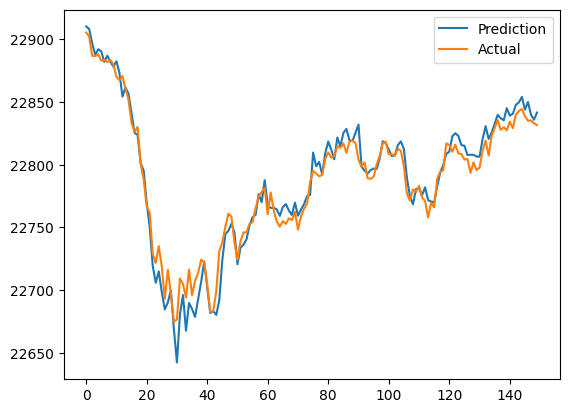

 mape: 0.00038576158461115184,
wape: 0.999611701913084,
mae: 9.00229280163248,
 mpe: 0.00020443566037909938,
 rmse: 12.850701703880887,
 corr: 0.9999303711013925,
r2_score:0.9998353475765704 minmax: 
150 6
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_35 (Conv1D)          (None, 149, 32)           416       
                                                                 
 flatten_35 (Flatten)        (None, 4768)              0         
                                                                 
 dense_35 (Dense)            (None, 1)                 4769      
                                                                 
Total params: 5,185
Trainable params: 5,185
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3746/3748 [============================>.] - ETA: 0s - loss: 2.0857e-04 - root_mean_squared_e

3748/3748 [==============================] - 28s 7ms/step - loss: 2.0851e-04 - root_mean_squared_error: 0.0144 - val_loss: 1.2350e-05 - val_root_mean_squared_error: 0.0035
Epoch 2/20
3748/3748 [==============================] - 27s 7ms/step - loss: 2.7519e-05 - root_mean_squared_error: 0.0052 - val_loss: 2.1435e-05 - val_root_mean_squared_error: 0.0046
Epoch 3/20
3745/3748 [============================>.] - ETA: 0s - loss: 1.5120e-05 - root_mean_squared_error: 0.0039

3748/3748 [==============================] - 30s 8ms/step - loss: 1.5120e-05 - root_mean_squared_error: 0.0039 - val_loss: 9.9381e-06 - val_root_mean_squared_error: 0.0032
Epoch 4/20
3748/3748 [==============================] - 29s 8ms/step - loss: 9.3887e-06 - root_mean_squared_error: 0.0031 - val_loss: 3.9355e-05 - val_root_mean_squared_error: 0.0063
Epoch 5/20
3748/3748 [==============================] - ETA: 0s - loss: 2.6419e-05 - root_mean_squared_error: 0.0051

3748/3748 [==============================] - 30s 8ms/step - loss: 2.6419e-05 - root_mean_squared_error: 0.0051 - val_loss: 3.3270e-06 - val_root_mean_squared_error: 0.0018
Epoch 6/20
3748/3748 [==============================] - 30s 8ms/step - loss: 4.6038e-06 - root_mean_squared_error: 0.0021 - val_loss: 5.3082e-06 - val_root_mean_squared_error: 0.0023
Epoch 7/20
3748/3748 [==============================] - 28s 7ms/step - loss: 1.5170e-05 - root_mean_squared_error: 0.0039 - val_loss: 5.1868e-06 - val_root_mean_squared_error: 0.0023
Epoch 8/20
3747/3748 [============================>.] - ETA: 0s - loss: 3.3100e-06 - root_mean_squared_error: 0.0018

3748/3748 [==============================] - 30s 8ms/step - loss: 3.3099e-06 - root_mean_squared_error: 0.0018 - val_loss: 2.4406e-06 - val_root_mean_squared_error: 0.0016
Epoch 9/20
3748/3748 [==============================] - 30s 8ms/step - loss: 1.0437e-05 - root_mean_squared_error: 0.0032 - val_loss: 1.1846e-05 - val_root_mean_squared_error: 0.0034
Epoch 10/20
3748/3748 [==============================] - ETA: 0s - loss: 4.3490e-06 - root_mean_squared_error: 0.0021

3748/3748 [==============================] - 28s 7ms/step - loss: 4.3490e-06 - root_mean_squared_error: 0.0021 - val_loss: 1.7974e-06 - val_root_mean_squared_error: 0.0013
Epoch 11/20
3745/3748 [============================>.] - ETA: 0s - loss: 3.3240e-05 - root_mean_squared_error: 0.0058

3748/3748 [==============================] - 28s 8ms/step - loss: 3.3222e-05 - root_mean_squared_error: 0.0058 - val_loss: 1.2356e-06 - val_root_mean_squared_error: 0.0011
Epoch 12/20
3748/3748 [==============================] - 25s 7ms/step - loss: 2.5269e-06 - root_mean_squared_error: 0.0016 - val_loss: 2.8664e-05 - val_root_mean_squared_error: 0.0054
Epoch 13/20
3748/3748 [==============================] - 29s 8ms/step - loss: 1.4811e-05 - root_mean_squared_error: 0.0038 - val_loss: 6.3587e-06 - val_root_mean_squared_error: 0.0025
Epoch 14/20
3748/3748 [==============================] - 26s 7ms/step - loss: 1.0362e-05 - root_mean_squared_error: 0.0032 - val_loss: 1.6303e-06 - val_root_mean_squared_error: 0.0013
Epoch 15/20
3748/3748 [==============================] - 30s 8ms/step - loss: 2.1958e-06 - root_mean_squared_error: 0.0015 - val_loss: 3.6662e-06 - val_root_mean_squared_error: 0.0019
Epoch 16/20
3748/3748 [==============================] - 25s 7ms/step - loss: 8.3051e-06 - r

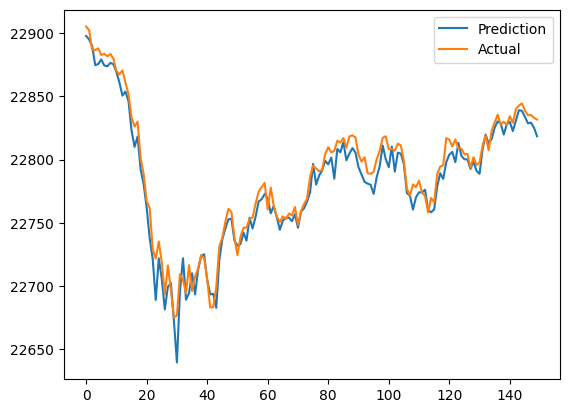

 mape: 0.0003483161090459573,
wape: 0.9996507687313336,
mae: 8.096568698007879,
 mpe: -0.0002376632116826496,
 rmse: 10.569400324925882,
 corr: 0.9999593947887966,
r2_score:0.9998886179679554 minmax: 
150 6
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_36 (Conv1D)          (None, 148, 32)           608       
                                                                 
 flatten_36 (Flatten)        (None, 4736)              0         
                                                                 
 dense_36 (Dense)            (None, 1)                 4737      
                                                                 
Total params: 5,345
Trainable params: 5,345
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3748/3748 [==============================] - ETA: 0s - loss: 2.3682e-04 - root_mean_squared_

3748/3748 [==============================] - 30s 8ms/step - loss: 2.3682e-04 - root_mean_squared_error: 0.0154 - val_loss: 2.4904e-05 - val_root_mean_squared_error: 0.0050
Epoch 2/20
3744/3748 [============================>.] - ETA: 0s - loss: 2.6862e-05 - root_mean_squared_error: 0.0052

3748/3748 [==============================] - 28s 8ms/step - loss: 2.6852e-05 - root_mean_squared_error: 0.0052 - val_loss: 1.0616e-05 - val_root_mean_squared_error: 0.0033
Epoch 3/20
3748/3748 [==============================] - 29s 8ms/step - loss: 2.2717e-05 - root_mean_squared_error: 0.0048 - val_loss: 6.4086e-05 - val_root_mean_squared_error: 0.0080
Epoch 4/20
3748/3748 [==============================] - 25s 7ms/step - loss: 5.9053e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.0904e-05 - val_root_mean_squared_error: 0.0033
Epoch 5/20
3742/3748 [============================>.] - ETA: 0s - loss: 4.9092e-06 - root_mean_squared_error: 0.0022

3748/3748 [==============================] - 27s 7ms/step - loss: 4.9166e-06 - root_mean_squared_error: 0.0022 - val_loss: 1.0093e-05 - val_root_mean_squared_error: 0.0032
Epoch 6/20
3748/3748 [==============================] - 28s 7ms/step - loss: 7.5314e-06 - root_mean_squared_error: 0.0027 - val_loss: 5.3908e-05 - val_root_mean_squared_error: 0.0073
Epoch 7/20
3747/3748 [============================>.] - ETA: 0s - loss: 2.4522e-05 - root_mean_squared_error: 0.0050

3748/3748 [==============================] - 30s 8ms/step - loss: 2.4521e-05 - root_mean_squared_error: 0.0050 - val_loss: 1.9429e-06 - val_root_mean_squared_error: 0.0014
Epoch 8/20
3748/3748 [==============================] - 30s 8ms/step - loss: 3.5354e-06 - root_mean_squared_error: 0.0019 - val_loss: 2.2601e-04 - val_root_mean_squared_error: 0.0150
Epoch 9/20
3743/3748 [============================>.] - ETA: 0s - loss: 5.2792e-05 - root_mean_squared_error: 0.0073

3748/3748 [==============================] - 30s 8ms/step - loss: 5.2734e-05 - root_mean_squared_error: 0.0073 - val_loss: 1.4859e-06 - val_root_mean_squared_error: 0.0012
Epoch 10/20
3748/3748 [==============================] - 26s 7ms/step - loss: 2.1727e-06 - root_mean_squared_error: 0.0015 - val_loss: 1.0968e-05 - val_root_mean_squared_error: 0.0033
Epoch 11/20
3748/3748 [==============================] - 30s 8ms/step - loss: 2.6164e-05 - root_mean_squared_error: 0.0051 - val_loss: 1.8578e-05 - val_root_mean_squared_error: 0.0043
Epoch 12/20
3748/3748 [==============================] - 33s 9ms/step - loss: 2.4961e-06 - root_mean_squared_error: 0.0016 - val_loss: 1.1748e-05 - val_root_mean_squared_error: 0.0034
Epoch 13/20
3747/3748 [============================>.] - ETA: 0s - loss: 1.5040e-05 - root_mean_squared_error: 0.0039

3748/3748 [==============================] - 28s 8ms/step - loss: 1.5040e-05 - root_mean_squared_error: 0.0039 - val_loss: 1.0658e-06 - val_root_mean_squared_error: 0.0010
Epoch 14/20
3748/3748 [==============================] - 26s 7ms/step - loss: 4.2066e-06 - root_mean_squared_error: 0.0021 - val_loss: 3.4854e-06 - val_root_mean_squared_error: 0.0019
Epoch 15/20
3748/3748 [==============================] - 30s 8ms/step - loss: 5.4386e-06 - root_mean_squared_error: 0.0023 - val_loss: 4.7269e-06 - val_root_mean_squared_error: 0.0022
Epoch 16/20
3748/3748 [==============================] - 30s 8ms/step - loss: 4.0888e-05 - root_mean_squared_error: 0.0064 - val_loss: 3.0832e-06 - val_root_mean_squared_error: 0.0018
Epoch 17/20
3748/3748 [==============================] - 27s 7ms/step - loss: 3.8360e-06 - root_mean_squared_error: 0.0020 - val_loss: 5.0899e-06 - val_root_mean_squared_error: 0.0023
Epoch 18/20
3748/3748 [==============================] - 28s 7ms/step - loss: 7.0751e-05 - r

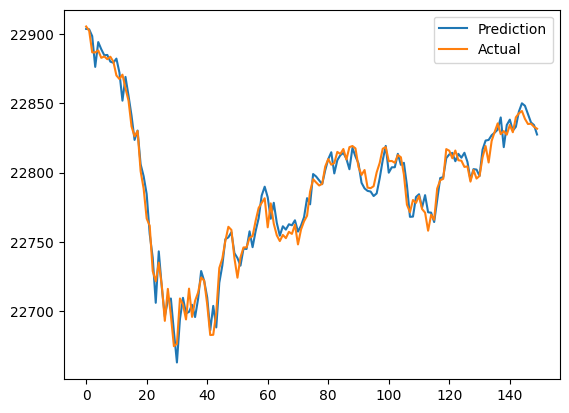

 mape: 0.0002932050622451486,
wape: 0.9997057066234326,
mae: 6.822890028849769,
 mpe: 6.421605455815653e-05,
 rmse: 9.70648182503383,
 corr: 0.9999549557684844,
r2_score:0.9999060626870276 minmax: 
150 6
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_37 (Conv1D)          (None, 147, 32)           800       
                                                                 
 flatten_37 (Flatten)        (None, 4704)              0         
                                                                 
 dense_37 (Dense)            (None, 1)                 4705      
                                                                 
Total params: 5,505
Trainable params: 5,505
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3744/3748 [============================>.] - ETA: 0s - loss: 1.7515e-04 - root_mean_squared_err

3748/3748 [==============================] - 32s 8ms/step - loss: 1.7501e-04 - root_mean_squared_error: 0.0132 - val_loss: 2.3917e-05 - val_root_mean_squared_error: 0.0049
Epoch 2/20
3748/3748 [==============================] - 30s 8ms/step - loss: 2.1838e-05 - root_mean_squared_error: 0.0047 - val_loss: 4.5556e-04 - val_root_mean_squared_error: 0.0213
Epoch 3/20
3748/3748 [==============================] - 30s 8ms/step - loss: 1.3651e-05 - root_mean_squared_error: 0.0037 - val_loss: 9.6257e-05 - val_root_mean_squared_error: 0.0098
Epoch 4/20
3746/3748 [============================>.] - ETA: 0s - loss: 5.2656e-05 - root_mean_squared_error: 0.0073

3748/3748 [==============================] - 32s 8ms/step - loss: 5.2640e-05 - root_mean_squared_error: 0.0073 - val_loss: 9.3379e-06 - val_root_mean_squared_error: 0.0031
Epoch 5/20
3743/3748 [============================>.] - ETA: 0s - loss: 6.1291e-06 - root_mean_squared_error: 0.0025

3748/3748 [==============================] - 30s 8ms/step - loss: 6.1262e-06 - root_mean_squared_error: 0.0025 - val_loss: 8.8037e-06 - val_root_mean_squared_error: 0.0030
Epoch 6/20
3748/3748 [==============================] - 26s 7ms/step - loss: 5.9728e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.0218e-05 - val_root_mean_squared_error: 0.0032
Epoch 7/20
3748/3748 [==============================] - 30s 8ms/step - loss: 9.6802e-06 - root_mean_squared_error: 0.0031 - val_loss: 9.0882e-05 - val_root_mean_squared_error: 0.0095
Epoch 8/20
3748/3748 [==============================] - ETA: 0s - loss: 8.9460e-05 - root_mean_squared_error: 0.0095

3748/3748 [==============================] - 28s 7ms/step - loss: 8.9460e-05 - root_mean_squared_error: 0.0095 - val_loss: 4.5632e-06 - val_root_mean_squared_error: 0.0021
Epoch 9/20
3748/3748 [==============================] - 30s 8ms/step - loss: 1.7624e-06 - root_mean_squared_error: 0.0013 - val_loss: 1.1126e-04 - val_root_mean_squared_error: 0.0105
Epoch 10/20
3744/3748 [============================>.] - ETA: 0s - loss: 4.1226e-06 - root_mean_squared_error: 0.0020

3748/3748 [==============================] - 30s 8ms/step - loss: 4.1197e-06 - root_mean_squared_error: 0.0020 - val_loss: 2.0978e-06 - val_root_mean_squared_error: 0.0014
Epoch 11/20
3748/3748 [==============================] - 26s 7ms/step - loss: 8.3686e-05 - root_mean_squared_error: 0.0091 - val_loss: 4.5037e-05 - val_root_mean_squared_error: 0.0067
Epoch 12/20
3748/3748 [==============================] - 30s 8ms/step - loss: 9.3080e-06 - root_mean_squared_error: 0.0031 - val_loss: 4.0747e-04 - val_root_mean_squared_error: 0.0202
Epoch 13/20
3746/3748 [============================>.] - ETA: 0s - loss: 6.4034e-05 - root_mean_squared_error: 0.0080

3748/3748 [==============================] - 29s 8ms/step - loss: 6.4014e-05 - root_mean_squared_error: 0.0080 - val_loss: 1.1541e-06 - val_root_mean_squared_error: 0.0011
Epoch 14/20
3748/3748 [==============================] - 30s 8ms/step - loss: 6.6943e-06 - root_mean_squared_error: 0.0026 - val_loss: 1.9180e-05 - val_root_mean_squared_error: 0.0044
Epoch 15/20
3748/3748 [==============================] - 29s 8ms/step - loss: 1.2030e-05 - root_mean_squared_error: 0.0035 - val_loss: 9.6047e-06 - val_root_mean_squared_error: 0.0031
Epoch 16/20
3748/3748 [==============================] - 29s 8ms/step - loss: 5.8267e-05 - root_mean_squared_error: 0.0076 - val_loss: 5.0014e-06 - val_root_mean_squared_error: 0.0022
Epoch 17/20
3748/3748 [==============================] - 27s 7ms/step - loss: 1.5553e-06 - root_mean_squared_error: 0.0012 - val_loss: 3.5271e-06 - val_root_mean_squared_error: 0.0019
Epoch 18/20
3748/3748 [==============================] - 28s 7ms/step - loss: 1.0274e-04 - r

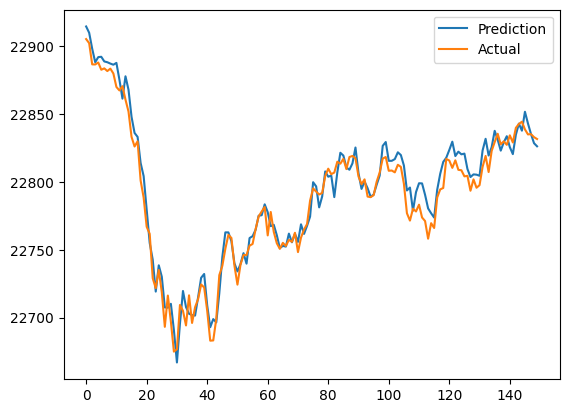

 mape: 0.00031471699773990674,
wape: 0.9996836168834103,
mae: 7.33501799005505,
 mpe: 8.171039823263093e-05,
 rmse: 10.21492051520381,
 corr: 0.9999497495301992,
r2_score:0.9998959638133493 minmax: 
150 6
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_38 (Conv1D)          (None, 146, 32)           992       
                                                                 
 flatten_38 (Flatten)        (None, 4672)              0         
                                                                 
 dense_38 (Dense)            (None, 1)                 4673      
                                                                 
Total params: 5,665
Trainable params: 5,665
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3742/3748 [============================>.] - ETA: 0s - loss: 2.3081e-04 - root_mean_squared_er

3748/3748 [==============================] - 33s 9ms/step - loss: 2.3053e-04 - root_mean_squared_error: 0.0152 - val_loss: 5.6156e-05 - val_root_mean_squared_error: 0.0075
Epoch 2/20
3748/3748 [==============================] - 33s 9ms/step - loss: 2.6478e-05 - root_mean_squared_error: 0.0051 - val_loss: 1.4166e-04 - val_root_mean_squared_error: 0.0119
Epoch 3/20
3747/3748 [============================>.] - ETA: 0s - loss: 1.3652e-05 - root_mean_squared_error: 0.0037

3748/3748 [==============================] - 33s 9ms/step - loss: 1.3652e-05 - root_mean_squared_error: 0.0037 - val_loss: 3.0424e-05 - val_root_mean_squared_error: 0.0055
Epoch 4/20
3748/3748 [==============================] - 33s 9ms/step - loss: 3.2851e-05 - root_mean_squared_error: 0.0057 - val_loss: 1.2130e-04 - val_root_mean_squared_error: 0.0110
Epoch 5/20
3748/3748 [==============================] - ETA: 0s - loss: 7.9746e-06 - root_mean_squared_error: 0.0028

3748/3748 [==============================] - 33s 9ms/step - loss: 7.9746e-06 - root_mean_squared_error: 0.0028 - val_loss: 3.3790e-06 - val_root_mean_squared_error: 0.0018
Epoch 6/20
3748/3748 [==============================] - 32s 8ms/step - loss: 5.4303e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.0484e-04 - val_root_mean_squared_error: 0.0102
Epoch 7/20
3748/3748 [==============================] - 31s 8ms/step - loss: 7.0654e-06 - root_mean_squared_error: 0.0027 - val_loss: 1.0739e-05 - val_root_mean_squared_error: 0.0033
Epoch 8/20
3748/3748 [==============================] - 32s 8ms/step - loss: 7.9895e-05 - root_mean_squared_error: 0.0089 - val_loss: 4.7142e-05 - val_root_mean_squared_error: 0.0069
Epoch 9/20
3748/3748 [==============================] - 35s 9ms/step - loss: 1.3022e-05 - root_mean_squared_error: 0.0036 - val_loss: 4.4935e-04 - val_root_mean_squared_error: 0.0212
Epoch 10/20
3747/3748 [============================>.] - ETA: 0s - loss: 6.0103e-05 - root_mean_

3748/3748 [==============================] - 32s 8ms/step - loss: 6.0100e-05 - root_mean_squared_error: 0.0078 - val_loss: 1.6038e-06 - val_root_mean_squared_error: 0.0013
Epoch 11/20
3747/3748 [============================>.] - ETA: 0s - loss: 3.7646e-06 - root_mean_squared_error: 0.0019

3748/3748 [==============================] - 32s 8ms/step - loss: 3.7645e-06 - root_mean_squared_error: 0.0019 - val_loss: 1.4160e-06 - val_root_mean_squared_error: 0.0012
Epoch 12/20
3748/3748 [==============================] - 32s 8ms/step - loss: 7.5709e-05 - root_mean_squared_error: 0.0087 - val_loss: 8.5475e-06 - val_root_mean_squared_error: 0.0029
Epoch 13/20
3748/3748 [==============================] - 33s 9ms/step - loss: 6.5849e-06 - root_mean_squared_error: 0.0026 - val_loss: 9.1595e-05 - val_root_mean_squared_error: 0.0096
Epoch 14/20
3748/3748 [==============================] - 31s 8ms/step - loss: 7.5605e-06 - root_mean_squared_error: 0.0027 - val_loss: 3.4782e-05 - val_root_mean_squared_error: 0.0059
Epoch 15/20
3748/3748 [==============================] - 33s 9ms/step - loss: 1.0255e-04 - root_mean_squared_error: 0.0101 - val_loss: 3.5921e-06 - val_root_mean_squared_error: 0.0019
Epoch 16/20
3748/3748 [==============================] - 32s 9ms/step - loss: 6.2203e-06 - r

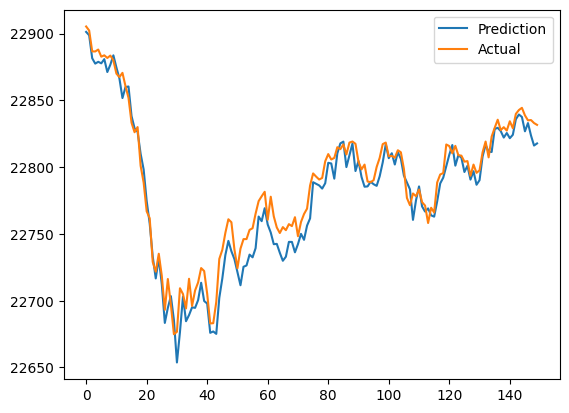

 mape: 0.0003801068730161919,
wape: 0.9996179513646887,
mae: 8.857405677304852,
 mpe: -0.0002474548995312426,
 rmse: 11.890484409423852,
 corr: 0.9999461676233304,
r2_score:0.999859034272333 minmax: 


In [ ]:
stats2 = []
for conv_neurons in range(4, 36, 4):
  for kernel_size in range(2, 6):
    build_compile_fit_model(
        conv_neurons, kernel_size,
        24, 0.001,
        f'model_{mins}_min/', 20,
        X_n_train, y_n_train, X_n_val, y_n_val
    )
    model_1_min = load_model(f'model_{mins}_min/')
    mape, wape, mae, mpe, rmse, corr, r2_sc = get_predictions(model_1_min, X_n_test, y_n_test, 'Test', unsmooth=True)

    stats2.append([conv_neurons, kernel_size, mape, wape, mae, mpe, rmse, corr, r2_sc])

In [ ]:
stat2 = pd.DataFrame(stats2, columns=['conv_neurons', 'kernel_size', 'mape', 'wape', 'mae', 'mpe', 'rmse', 'corr', 'r2 score'])
stat2

,conv_neurons,kernel_size,mape,wape,mae,mpe,rmse,corr,r2 score
0,4,2,0.000240,0.999759,5.590065,-0.000007,8.377385,0.999965,0.999930
1,4,3,0.000418,0.999580,9.737391,0.000338,12.083902,0.999959,0.999854
2,4,4,0.000478,0.999519,11.143430,0.000419,14.245926,0.999947,0.999798
3,4,5,0.000365,0.999634,8.491706,-0.000222,12.357081,0.999937,0.999848
4,8,2,0.000336,0.999664,7.797600,0.000147,10.543289,0.999951,0.999889
5,8,3,0.000332,0.999666,7.738172,-0.000280,11.062760,0.999960,0.999878
6,8,4,0.000420,0.999578,9.787891,0.000313,12.343476,0.999951,0.999848
7,8,5,0.000295,0.999703,6.885635,-0.000173,9.549661,0.999963,0.999909
8,12,2,0.000729,0.999266,17.026972,-0.000709,20.829799,0.999927,0.999567
9,12,3,0.000296,0.999702,6.908698,-0.000089,10.006451,0.999952,0.999900


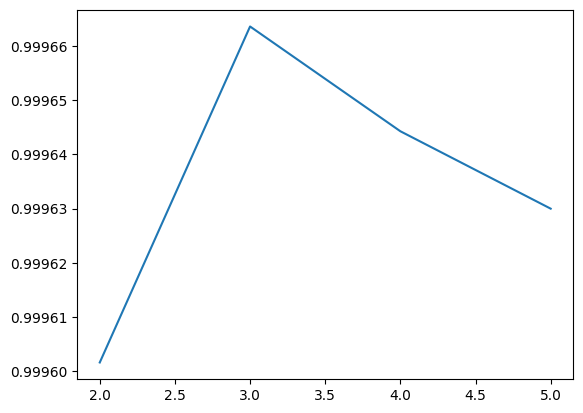

In [ ]:
stat3 = stat2.groupby(by='kernel_size').mean()

plt.plot(stat3.index, stat3['wape'])
plt.show()

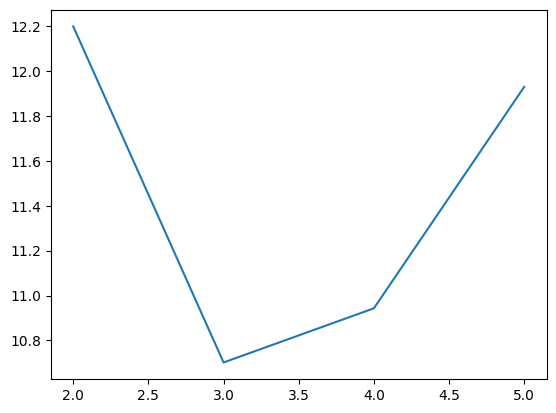

In [ ]:
stat3 = stat2.groupby(by='kernel_size').mean()

plt.plot(stat3.index, stat3['rmse'])
plt.show()

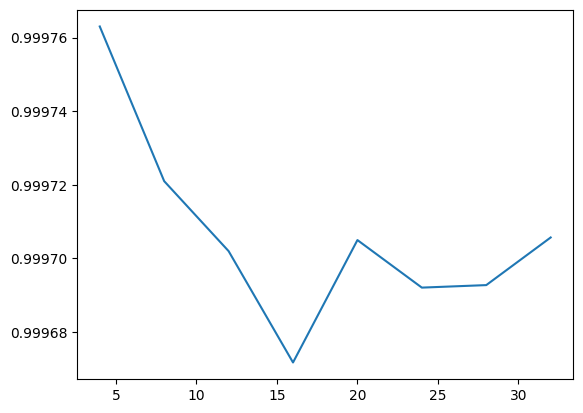

In [ ]:
stat3 = stat2[stat2['kernel_size'] == 3].groupby(by='conv_neurons').mean()

plt.plot(stat3.index, stat3['wape'])
plt.show()

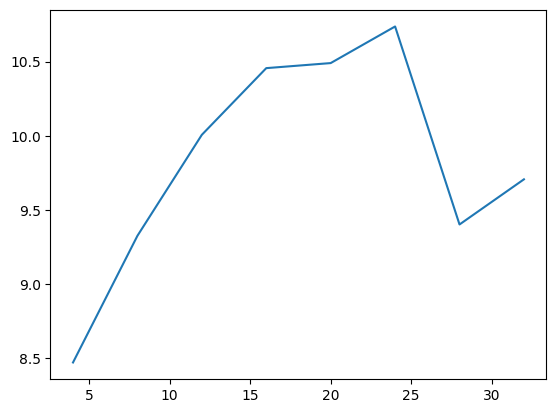

In [ ]:
stat3 = stat2[stat2['kernel_size'] == 3].groupby(by='conv_neurons').mean()

plt.plot(stat3.index, stat3['rmse'])
plt.show()

The best result is 4 neurons and kernel_size = 3



## Get result for the best hyperparameters

In [24]:
conv_neurons, kernel_size, mins = 4, 3, 1
X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(parsed_klines, 1, columns=[CPR, HPR, LPR, VOL, TN, TAKER])
build_compile_fit_model(conv_neurons, kernel_size,
                        24, 0.001,
                        f'model_{mins}_min_time_par/', 15,
                        X_n_train, y_n_train, X_n_val, y_n_val)
model_1_min_time_par4 = load_model(f'model_{mins}_min_time_par/')

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER, Difference, Absolute Difference, Day Time sin, Day Time cos, Week Day sin, Week Day cos, Direction]
Index: []
150 6
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 148, 4)            76        
                                                                 
 flatten (Flatten)           (None, 592)               0         
                                                                 
 dense (Dense)               (None, 1)                 593       
                                                                 
Total params: 669
Trainable params: 669
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
3734/3748 [============================>.] - ETA: 0s - los

3748/3748 [==============================] - 16s 4ms/step - loss: 0.0013 - root_mean_squared_error: 0.0359 - val_loss: 8.6266e-05 - val_root_mean_squared_error: 0.0093
Epoch 2/15
3746/3748 [============================>.] - ETA: 0s - loss: 7.7028e-05 - root_mean_squared_error: 0.0088

3748/3748 [==============================] - 15s 4ms/step - loss: 7.7014e-05 - root_mean_squared_error: 0.0088 - val_loss: 2.7909e-05 - val_root_mean_squared_error: 0.0053
Epoch 3/15
3748/3748 [==============================] - 15s 4ms/step - loss: 4.6307e-05 - root_mean_squared_error: 0.0068 - val_loss: 2.9030e-05 - val_root_mean_squared_error: 0.0054
Epoch 4/15
3748/3748 [==============================] - 15s 4ms/step - loss: 3.0629e-05 - root_mean_squared_error: 0.0055 - val_loss: 3.1201e-05 - val_root_mean_squared_error: 0.0056
Epoch 5/15
3743/3748 [============================>.] - ETA: 0s - loss: 2.2223e-05 - root_mean_squared_error: 0.0047

3748/3748 [==============================] - 15s 4ms/step - loss: 2.2246e-05 - root_mean_squared_error: 0.0047 - val_loss: 1.6691e-05 - val_root_mean_squared_error: 0.0041
Epoch 6/15
3740/3748 [============================>.] - ETA: 0s - loss: 1.6234e-05 - root_mean_squared_error: 0.0040

3748/3748 [==============================] - 15s 4ms/step - loss: 1.6223e-05 - root_mean_squared_error: 0.0040 - val_loss: 4.0540e-06 - val_root_mean_squared_error: 0.0020
Epoch 7/15
3748/3748 [==============================] - ETA: 0s - loss: 1.2005e-05 - root_mean_squared_error: 0.0035

3748/3748 [==============================] - 17s 4ms/step - loss: 1.2005e-05 - root_mean_squared_error: 0.0035 - val_loss: 3.6535e-06 - val_root_mean_squared_error: 0.0019
Epoch 8/15
3748/3748 [==============================] - 15s 4ms/step - loss: 1.2085e-05 - root_mean_squared_error: 0.0035 - val_loss: 3.8885e-06 - val_root_mean_squared_error: 0.0020
Epoch 9/15
3748/3748 [==============================] - 14s 4ms/step - loss: 9.9232e-06 - root_mean_squared_error: 0.0032 - val_loss: 1.0484e-05 - val_root_mean_squared_error: 0.0032
Epoch 10/15
3748/3748 [==============================] - 14s 4ms/step - loss: 1.0310e-05 - root_mean_squared_error: 0.0032 - val_loss: 1.7355e-05 - val_root_mean_squared_error: 0.0042
Epoch 11/15
3748/3748 [==============================] - 14s 4ms/step - loss: 9.1683e-06 - root_mean_squared_error: 0.0030 - val_loss: 6.3702e-06 - val_root_mean_squared_error: 0.0025
Epoch 12/15
3740/3748 [============================>.] - ETA: 0s - loss: 7.9246e-06 - root_mea

3748/3748 [==============================] - 15s 4ms/step - loss: 7.9170e-06 - root_mean_squared_error: 0.0028 - val_loss: 3.1072e-06 - val_root_mean_squared_error: 0.0018
Epoch 13/15
3748/3748 [==============================] - 15s 4ms/step - loss: 8.6253e-06 - root_mean_squared_error: 0.0029 - val_loss: 1.7423e-05 - val_root_mean_squared_error: 0.0042
Epoch 14/15
3748/3748 [==============================] - 14s 4ms/step - loss: 8.2510e-06 - root_mean_squared_error: 0.0029 - val_loss: 8.2533e-06 - val_root_mean_squared_error: 0.0029
Epoch 15/15
3748/3748 [==============================] - 14s 4ms/step - loss: 7.6735e-06 - root_mean_squared_error: 0.0028 - val_loss: 7.2069e-06 - val_root_mean_squared_error: 0.0027


1250/1250 [==============================] - 3s 3ms/step
       Test Predictions   Actuals
0              0.559207  0.559154
1              0.559388  0.559492
2              0.559946  0.559651
3              0.560075  0.559054
4              0.559128  0.559259
...                 ...       ...
39965          0.067609  0.065297
39966          0.066633  0.062453
39967          0.063210  0.063193
39968          0.064776  0.060809
39969          0.060913  0.062251

[39970 rows x 2 columns]


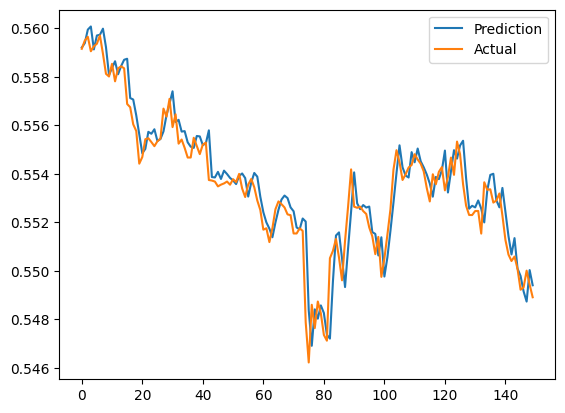

 mape: inf,
wape: 0.9971062123624959,
mae: 0.0012532693224586076,
 mpe: inf,
 rmse: 0.0018935537433405376,
 corr: 0.9999004941357584,
r2_score:0.9997572017337666 minmax: 


(inf,
 0.9971062123624959,
 0.0012532693224586076,
 inf,
 0.0018935537433405376,
 0.9999004941357584,
 0.9997572017337666)

In [61]:
get_predictions(model_1_min_time_par4, X_n_test, y_n_test, 'Test')

1250/1250 [==============================] - 3s 2ms/step
       Test Predictions       Actuals
0          20943.753906  20949.666265
1          20943.207031  20952.957462
2          20949.611328  20954.494427
3          20951.720703  20948.692586
4          20945.691406  20950.688226
...                 ...           ...
39965      16180.671875  16148.626604
39966      16193.979492  16120.981354
39967      16146.852539  16128.175315
39968      16148.036133  16104.992091
39969      16131.640625  16119.009855

[39970 rows x 2 columns]


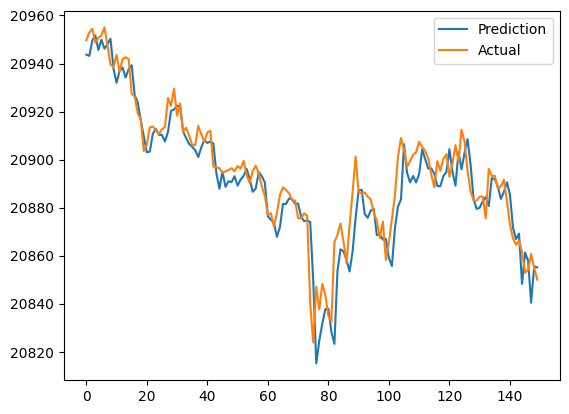

 mape: 0.0005968300170877644,
wape: 0.9994237109898142,
mae: 11.366798882768855,
 mpe: 3.557958534085203e-05,
 rmse: 18.885580542607336,
 corr: 0.9998736509278606,
r2_score:0.9997444460249553 minmax: 


(0.0005968300170877644,
 0.9994237109898142,
 11.366798882768855,
 3.557958534085203e-05,
 18.885580542607336,
 0.9998736509278606,
 0.9997444460249553)

In [25]:
smooth_data(parsed_klines[CPR][430000:630000].copy().values.reshape(-1, 1), smoothing_window_size=200000)
get_predictions(model_1_min_time_par4, X_n_test, y_n_test, 'Test', unsmooth=True)

## **Let's add new parameters related to time such as TSIN, TCOS, DSIN, DCOS**

In [55]:
conv_neurons, kernel_size, mins = 4, 3, 1
X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(parsed_klines, 1, columns=[CPR, HPR, LPR, VOL, TN, TAKER, TSIN, TCOS, DSIN, DCOS])
build_compile_fit_model(conv_neurons, kernel_size,
                        24, 0.001,
                        f'model_{mins}_min_time_par/', 15,
                        X_n_train, y_n_train, X_n_val, y_n_val)
model_1_min_time_par = load_model(f'model_{mins}_min_time_par/')

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER, Difference, Absolute Difference, Day Time sin, Day Time cos, Week Day sin, Week Day cos, Direction]
Index: []
150 10
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 148, 4)            124       
                                                                 
 flatten_20 (Flatten)        (None, 592)               0         
                                                                 
 dense_20 (Dense)            (None, 1)                 593       
                                                                 
Total params: 717
Trainable params: 717
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
3735/3748 [============================>.] - ETA: 0s -

3748/3748 [==============================] - 26s 7ms/step - loss: 0.0033 - root_mean_squared_error: 0.0571 - val_loss: 5.3680e-04 - val_root_mean_squared_error: 0.0232
Epoch 2/15
3746/3748 [============================>.] - ETA: 0s - loss: 1.5166e-04 - root_mean_squared_error: 0.0123

3748/3748 [==============================] - 23s 6ms/step - loss: 1.5162e-04 - root_mean_squared_error: 0.0123 - val_loss: 1.1547e-04 - val_root_mean_squared_error: 0.0107
Epoch 3/15
3748/3748 [==============================] - 20s 5ms/step - loss: 1.0925e-04 - root_mean_squared_error: 0.0105 - val_loss: 3.9412e-04 - val_root_mean_squared_error: 0.0199
Epoch 4/15
3745/3748 [============================>.] - ETA: 0s - loss: 4.9951e-05 - root_mean_squared_error: 0.0071

3748/3748 [==============================] - 18s 5ms/step - loss: 4.9940e-05 - root_mean_squared_error: 0.0071 - val_loss: 3.8340e-05 - val_root_mean_squared_error: 0.0062
Epoch 5/15
3748/3748 [==============================] - 20s 5ms/step - loss: 3.8392e-05 - root_mean_squared_error: 0.0062 - val_loss: 8.5569e-05 - val_root_mean_squared_error: 0.0093
Epoch 6/15
3748/3748 [==============================] - 20s 5ms/step - loss: 3.0100e-05 - root_mean_squared_error: 0.0055 - val_loss: 9.1827e-05 - val_root_mean_squared_error: 0.0096
Epoch 7/15
3743/3748 [============================>.] - ETA: 0s - loss: 2.0898e-05 - root_mean_squared_error: 0.0046

3748/3748 [==============================] - 18s 5ms/step - loss: 2.0883e-05 - root_mean_squared_error: 0.0046 - val_loss: 1.0674e-05 - val_root_mean_squared_error: 0.0033
Epoch 8/15
3737/3748 [============================>.] - ETA: 0s - loss: 2.1323e-05 - root_mean_squared_error: 0.0046

3748/3748 [==============================] - 21s 6ms/step - loss: 2.1296e-05 - root_mean_squared_error: 0.0046 - val_loss: 9.1415e-06 - val_root_mean_squared_error: 0.0030
Epoch 9/15
3748/3748 [==============================] - 17s 5ms/step - loss: 1.7601e-05 - root_mean_squared_error: 0.0042 - val_loss: 1.7762e-05 - val_root_mean_squared_error: 0.0042
Epoch 10/15
3735/3748 [============================>.] - ETA: 0s - loss: 1.6809e-05 - root_mean_squared_error: 0.0041

3748/3748 [==============================] - 18s 5ms/step - loss: 1.6794e-05 - root_mean_squared_error: 0.0041 - val_loss: 6.4776e-06 - val_root_mean_squared_error: 0.0025
Epoch 11/15
3741/3748 [============================>.] - ETA: 0s - loss: 1.4305e-05 - root_mean_squared_error: 0.0038

3748/3748 [==============================] - 18s 5ms/step - loss: 1.4289e-05 - root_mean_squared_error: 0.0038 - val_loss: 3.9051e-06 - val_root_mean_squared_error: 0.0020
Epoch 12/15
3748/3748 [==============================] - 18s 5ms/step - loss: 1.4696e-05 - root_mean_squared_error: 0.0038 - val_loss: 9.9073e-06 - val_root_mean_squared_error: 0.0031
Epoch 13/15
3748/3748 [==============================] - 20s 5ms/step - loss: 1.6066e-05 - root_mean_squared_error: 0.0040 - val_loss: 2.9165e-04 - val_root_mean_squared_error: 0.0171
Epoch 14/15
3742/3748 [============================>.] - ETA: 0s - loss: 1.4216e-05 - root_mean_squared_error: 0.0038

3748/3748 [==============================] - 20s 5ms/step - loss: 1.4208e-05 - root_mean_squared_error: 0.0038 - val_loss: 2.7316e-06 - val_root_mean_squared_error: 0.0017
Epoch 15/15
3748/3748 [==============================] - 20s 5ms/step - loss: 1.2701e-05 - root_mean_squared_error: 0.0036 - val_loss: 5.8007e-06 - val_root_mean_squared_error: 0.0024


3748/3748 [==============================] - 10s 3ms/step
        Train Predictions   Actuals
0                0.960059  0.960792
1                0.959236  0.960792
2                0.958973  0.960241
3                0.958442  0.958443
4                0.957239  0.959471
...                   ...       ...
119905           0.543537  0.546411
119906           0.544439  0.547710
119907           0.545351  0.551725
119908           0.549142  0.551253
119909           0.550153  0.553239

[119910 rows x 2 columns]


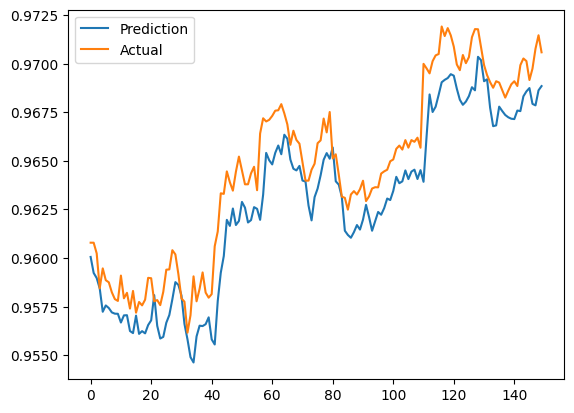

 mape: 0.0027861650214715656,
wape: 0.9974615623586959,
mae: 0.0014406448177764974,
 mpe: -2.205572222220449e-06,
 rmse: 0.002012936841630614,
 corr: 0.9999175991892899,
r2_score:0.9998328687258519 minmax: 


(0.0027861650214715656,
 0.9974615623586959,
 0.0014406448177764974,
 -2.205572222220449e-06,
 0.002012936841630614,
 0.9999175991892899,
 0.9998328687258519)

In [56]:
get_predictions(model_1_min_time_par, X_n_train, y_n_train, 'Train')

1250/1250 [==============================] - 4s 3ms/step
       Val Predictions   Actuals
0             0.550729  0.550605
1             0.547958  0.550754
2             0.549962  0.550525
3             0.548535  0.550819
4             0.548641  0.551789
...                ...       ...
39965         0.556164  0.557156
39966         0.555896  0.556999
39967         0.556137  0.558398
39968         0.557098  0.558154
39969         0.557153  0.559216

[39970 rows x 2 columns]


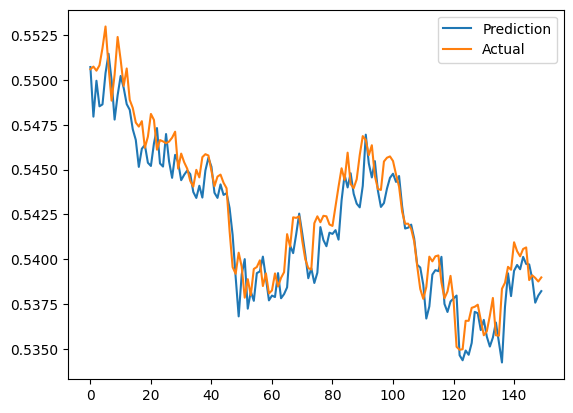

 mape: 0.0018583033272028442,
wape: 0.9981826263395293,
mae: 0.0012037573597220256,
 mpe: 0.00015248972217743364,
 rmse: 0.0016527633458562163,
 corr: 0.9998550628392218,
r2_score:0.9997087465157335 minmax: 


(0.0018583033272028442,
 0.9981826263395293,
 0.0012037573597220256,
 0.00015248972217743364,
 0.0016527633458562163,
 0.9998550628392218,
 0.9997087465157335)

In [57]:
get_predictions(model_1_min_time_par, X_n_val, y_n_val, 'Val')

1250/1250 [==============================] - 3s 2ms/step
       Test Predictions   Actuals
0              0.558001  0.559154
1              0.557825  0.559492
2              0.558210  0.559651
3              0.558365  0.559054
4              0.557975  0.559259
...                 ...       ...
39965          0.067746  0.065297
39966          0.069155  0.062453
39967          0.064809  0.063193
39968          0.063818  0.060809
39969          0.060573  0.062251

[39970 rows x 2 columns]


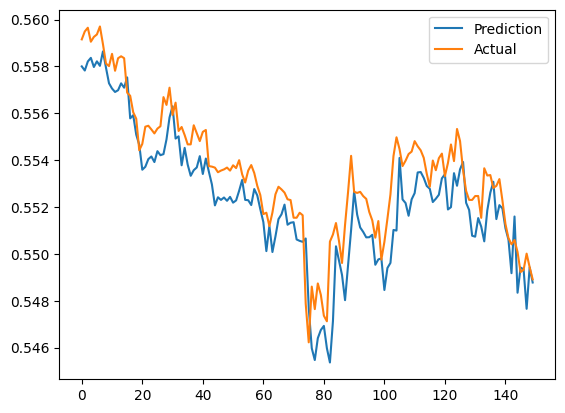

 mape: inf,
wape: 0.996854598344898,
mae: 0.001362240736002945,
 mpe: inf,
 rmse: 0.0019475864512752247,
 corr: 0.9998787544040646,
r2_score:0.9997431474990833 minmax: 


(inf,
 0.996854598344898,
 0.001362240736002945,
 inf,
 0.0019475864512752247,
 0.9998787544040646,
 0.9997431474990833)

In [58]:
get_predictions(model_1_min_time_par, X_n_test, y_n_test, 'Test')

This test shows the result which we can understand as following: adding time parameters makes prediction **worse** than without it

Postprocess data to get price

In [ ]:
smoothing_window_size = 200000
predictions = model_1_min_time_par4.predict(X_n_test).flatten().copy()
predicted_prices = unsmooth_data(predictions.reshape(-1, 1).copy(), smoothing_window_size).reshape(-1)

actual_prices = parsed_klines.loc[430000 + 200000 + 150 - len(predictions):430000 + 200000, OPR]
predicted_prices, actual_prices

1250/1250 [==============================] - 2s 2ms/step


(array([50924.895, 50924.867, 50924.867, ..., 50920.426, 50920.46 ,
        50920.258], dtype=float32),
 590180    22831.65
 590181    22830.13
 590182    22828.75
 590183    22830.64
 590184    22844.56
             ...   
 629996    22542.26
 629997    22533.65
 629998    22530.37
 629999    22520.83
 630000    22524.46
 Name: OPEN PRICE, Length: 39821, dtype: float64)

## Trend direction prediction

In [63]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score, roc_curve, auc, precision_recall_curve

from __future__ import division

def line(p1, p2):
  k = (p1[1] - p2[1])/(p1[0] - p2[0])
  b = p1[1] - p1[0] * k

  return k, b

def intersection(L1, L2):
  x = (L2[1] - L1[1]) / (L1[0] - L2[0])
  y = L1[0] * x + L1[1]

  return x, y


#aucc = roc_auc_score(y_test, predictions_proba[::, 1])
def get_tree_score(y_test, y_pred):
  f1 = f1_score(y_test, y_pred)
  fpr, tpr, treshold = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr, tpr)
  precision, recall, threshold = precision_recall_curve(y_test, y_pred)

  l1 = line([fpr[-2], tpr[-2]], [fpr[-1], tpr[-1]])
  l2 = line([precision[1], recall[1]], [precision[0], recall[0]])
  x,y = intersection(l1, l2)

  # строим график
  plt.plot(fpr, tpr, color='darkorange',
           label='ROC кривая (area = %0.2f)' % roc_auc)
  plt.plot(precision, recall,
           #label='AUC кривая (area = %0.2f)' % aucc
           )
  plt.scatter(x, y, label='X =  %0.2f' % x)

  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Пример ROC-кривой')
  plt.legend(loc="lower right")
  plt.show()

  recall = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  return {'recall': recall, 'prec': precision, 'auc': 'Here no auc', 'f1': f1}

1250/1250 [==============================] - 2s 2ms/step


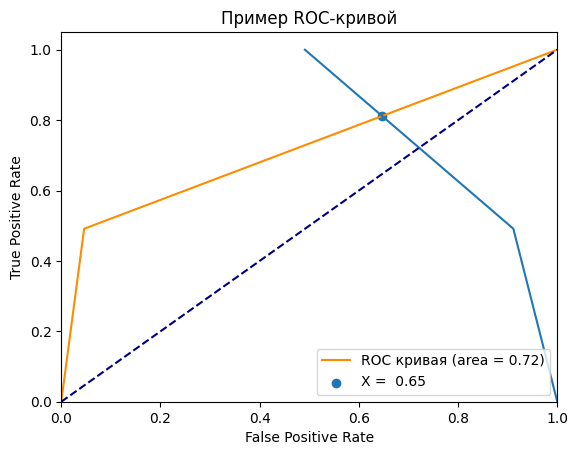

{'recall': 0.49139248242844047,
 'prec': 0.9114785073216817,
 'auc': 'Here no auc',
 'f1': 0.6385386677256031}

In [ ]:
#count direction precision for minute prediction

preds = model_1_min_time_par4.predict(X_n_test).flatten()

pred_dir = ((preds[1:] - y_n_test[:-1]) > 0).astype(np.int32)
true_dir = ((y_n_test[1:] - y_n_test[:-1]) > 0).astype(np.int32)

get_tree_score(true_dir, pred_dir)

In [ ]:
coefs = np.round(abs(y_n_test) / abs(preds), 2)
coef_df = pd.DataFrame(coefs, columns=['Coefs'])
coef_df.describe()

,Coefs
count,3.997000e+04
mean,1.768356e+02
std,8.100261e+03
min,0.000000e+00
25%,7.010000e+00
50%,1.812000e+01
75%,4.587000e+01
max,1.506378e+06


# Predict for timeframe bigger than 1 minute

## Try to predict 5 mins

In [ ]:
#try to predict without smoothing window in the hardest part of history data with new values of model's parameters

conv_neurons, kernel_size, mins = 4, 3, 5
X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(parsed_klines, mins,
                                                                        df_start=430000,
                                                                        columns=[OPR, HPR, LPR, VOL, TN, TAKER],
                                                                        smoothing_window_size=200000)
build_compile_fit_model(conv_neurons, kernel_size,
                        24, 0.001,
                        f'model_{mins}_min/', 20,
                        X_n_train, y_n_train, X_n_val, y_n_val)
model_5_min = load_model(f'model_{mins}_min/')

1250/1250 [==============================] - 2s 2ms/step
       Test Predictions   Actuals
0              0.760141  0.759664
1              0.760412  0.760115
2              0.760870  0.759803
3              0.759087  0.758197
4              0.758503  0.758191
...                 ...       ...
39965          0.722549  0.723299
39966          0.722087  0.722779
39967          0.722738  0.721894
39968          0.721879  0.721556
39969          0.719738  0.720575

[39970 rows x 2 columns]


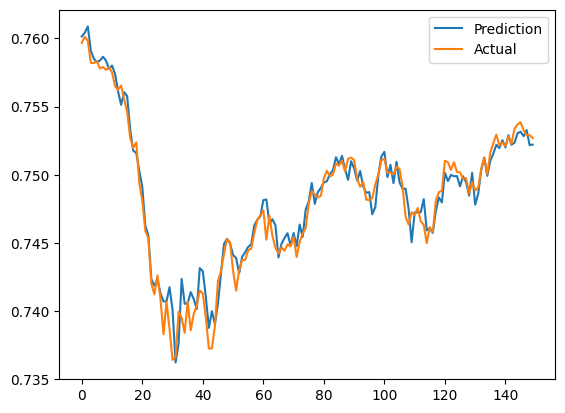

 mape: 0.0009353828647273878,
 mae: 0.0007426035523294447,
 mpe: -2.196043090141356e-05,
 rmse: 0.001102137522897222,
 corr: 0.9999430425513708,
 minmax: 


(0.0009353828647273878,
 0.0007426035523294447,
 -2.196043090141356e-05,
 0.001102137522897222,
 0.9999430425513708)

In [ ]:
get_predictions(model_5_min, X_n_test, y_n_test, 'Test')

## Try to predict 10 mins

In [ ]:
#try to predict without smoothing window in the hardest part of history data with new values of model's parameters

conv_neurons, kernel_size, mins = 4, 3, 10
X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(parsed_klines, mins,
                                                                        df_start=430000,
                                                                        columns=[OPR, HPR, LPR, VOL, TN, TAKER],
                                                                        smoothing_window_size=200000)
build_compile_fit_model(conv_neurons, kernel_size,
                        24, 0.001,
                        f'model_{mins}_min/', 20,
                        X_n_train, y_n_train, X_n_val, y_n_val)
model_10_min = load_model(f'model_{mins}_min/')

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER]
Index: []
150 6
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 148, 4)            76        
                                                                 
 flatten_2 (Flatten)         (None, 592)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 593       
                                                                 
Total params: 669
Trainable params: 669
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3745/3748 [============================>.] - ETA: 0s - loss: 1.5541e-04 - root_mean_squared_error: 0.0125

3748/3748 [==============================] - 17s 4ms/step - loss: 1.5537e-04 - root_mean_squared_error: 0.0125 - val_loss: 1.2036e-04 - val_root_mean_squared_error: 0.0110
Epoch 2/20
3748/3748 [==============================] - 14s 4ms/step - loss: 2.0731e-05 - root_mean_squared_error: 0.0046 - val_loss: 1.9761e-04 - val_root_mean_squared_error: 0.0141
Epoch 3/20
3740/3748 [============================>.] - ETA: 0s - loss: 1.2263e-05 - root_mean_squared_error: 0.0035

3748/3748 [==============================] - 15s 4ms/step - loss: 1.2266e-05 - root_mean_squared_error: 0.0035 - val_loss: 5.8394e-06 - val_root_mean_squared_error: 0.0024
Epoch 4/20
3748/3748 [==============================] - 14s 4ms/step - loss: 8.4712e-06 - root_mean_squared_error: 0.0029 - val_loss: 4.0575e-05 - val_root_mean_squared_error: 0.0064
Epoch 5/20
3748/3748 [==============================] - 14s 4ms/step - loss: 5.4352e-06 - root_mean_squared_error: 0.0023 - val_loss: 9.5004e-05 - val_root_mean_squared_error: 0.0097
Epoch 6/20
3748/3748 [==============================] - 14s 4ms/step - loss: 4.7538e-06 - root_mean_squared_error: 0.0022 - val_loss: 2.4789e-05 - val_root_mean_squared_error: 0.0050
Epoch 7/20
3748/3748 [==============================] - 17s 5ms/step - loss: 4.0308e-06 - root_mean_squared_error: 0.0020 - val_loss: 2.4654e-05 - val_root_mean_squared_error: 0.0050
Epoch 8/20
3748/3748 [==============================] - 16s 4ms/step - loss: 3.9675e-06 - root_m

3748/3748 [==============================] - 14s 4ms/step - loss: 3.4412e-06 - root_mean_squared_error: 0.0019 - val_loss: 2.5487e-06 - val_root_mean_squared_error: 0.0016
Epoch 10/20
3748/3748 [==============================] - 14s 4ms/step - loss: 3.8388e-06 - root_mean_squared_error: 0.0020 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0322
Epoch 11/20
3736/3748 [============================>.] - ETA: 0s - loss: 4.0287e-06 - root_mean_squared_error: 0.0020

3748/3748 [==============================] - 14s 4ms/step - loss: 4.0217e-06 - root_mean_squared_error: 0.0020 - val_loss: 1.5941e-06 - val_root_mean_squared_error: 0.0013
Epoch 12/20
3748/3748 [==============================] - 14s 4ms/step - loss: 3.0173e-06 - root_mean_squared_error: 0.0017 - val_loss: 2.1498e-06 - val_root_mean_squared_error: 0.0015
Epoch 13/20
3748/3748 [==============================] - 14s 4ms/step - loss: 3.8174e-06 - root_mean_squared_error: 0.0020 - val_loss: 3.4800e-06 - val_root_mean_squared_error: 0.0019
Epoch 14/20
3748/3748 [==============================] - 14s 4ms/step - loss: 3.2353e-06 - root_mean_squared_error: 0.0018 - val_loss: 7.3896e-05 - val_root_mean_squared_error: 0.0086
Epoch 15/20
3748/3748 [==============================] - 14s 4ms/step - loss: 3.3202e-06 - root_mean_squared_error: 0.0018 - val_loss: 1.5698e-05 - val_root_mean_squared_error: 0.0040
Epoch 16/20
3748/3748 [==============================] - 15s 4ms/step - loss: 2.8635e-06 - r

3748/3748 [==============================] - 16s 4ms/step - loss: 2.7651e-06 - root_mean_squared_error: 0.0017 - val_loss: 1.0278e-06 - val_root_mean_squared_error: 0.0010
Epoch 18/20
3748/3748 [==============================] - 15s 4ms/step - loss: 3.2563e-06 - root_mean_squared_error: 0.0018 - val_loss: 3.8017e-05 - val_root_mean_squared_error: 0.0062
Epoch 19/20
3748/3748 [==============================] - 15s 4ms/step - loss: 2.6125e-06 - root_mean_squared_error: 0.0016 - val_loss: 1.2462e-06 - val_root_mean_squared_error: 0.0011
Epoch 20/20
3748/3748 [==============================] - 14s 4ms/step - loss: 2.7781e-06 - root_mean_squared_error: 0.0017 - val_loss: 5.8608e-06 - val_root_mean_squared_error: 0.0024


1250/1250 [==============================] - 3s 2ms/step
       Test Predictions   Actuals
0              0.759659  0.759664
1              0.759493  0.760115
2              0.759420  0.759803
3              0.758919  0.758197
4              0.757220  0.758191
...                 ...       ...
39965          0.723533  0.723299
39966          0.723010  0.722779
39967          0.722524  0.721894
39968          0.721045  0.721556
39969          0.720982  0.720575

[39970 rows x 2 columns]


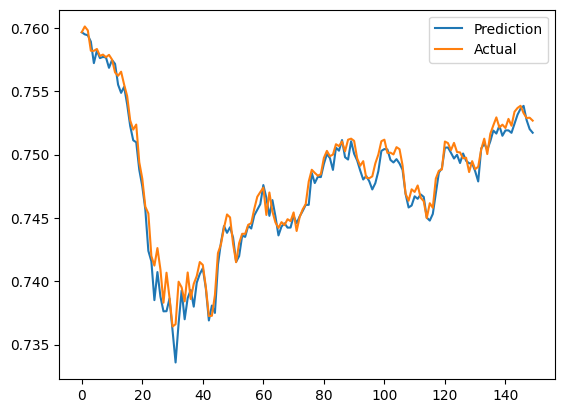

 mape: 0.0008459423034260185,
 mae: 0.0006747423657407049,
 mpe: -0.0003487094165049695,
 rmse: 0.0009800875419536008,
 corr: 0.9999585104292431,
 minmax: 


(0.0008459423034260185,
 0.0006747423657407049,
 -0.0003487094165049695,
 0.0009800875419536008,
 0.9999585104292431)

In [ ]:
get_predictions(model_10_min, X_n_test, y_n_test, 'Test')

## Predict 1 day

In [ ]:
mins = 60*24

X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(
    parsed_klines, mins,
    df_start=0, df_size=700000,
    columns=[OPR, HPR, LPR, VOL, TN, TAKER],
    smoothing_window_size=700000
)
smooth_data(agg_to_freq_data(parsed_klines.copy(), mins)[OPR].values.reshape(-1, 1), smoothing_window_size=700000)

In [ ]:
conv_neurons, kernel_size = 4, 3
build_compile_fit_model(conv_neurons, kernel_size,
                        24, 0.001,
                        f'model_{mins}_min_diff/', 10,
                        X_n_train, y_n_train, X_n_val, y_n_val)

150 6
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_39 (Conv1D)          (None, 148, 4)            76        
                                                                 
 flatten_39 (Flatten)        (None, 592)               0         
                                                                 
 dense_39 (Dense)            (None, 1)                 593       
                                                                 
Total params: 669
Trainable params: 669
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1/6 [====>.........................] - ETA: 4s - loss: 0.3002 - root_mean_squared_error: 0.5479

6/6 [==============================] - 2s 272ms/step - loss: 0.1309 - root_mean_squared_error: 0.3618 - val_loss: 0.0574 - val_root_mean_squared_error: 0.2397
Epoch 2/10
1/6 [====>.........................] - ETA: 0s - loss: 0.1035 - root_mean_squared_error: 0.3217

6/6 [==============================] - 1s 156ms/step - loss: 0.0588 - root_mean_squared_error: 0.2425 - val_loss: 0.0421 - val_root_mean_squared_error: 0.2053
Epoch 3/10
6/6 [==============================] - 0s 14ms/step - loss: 0.0491 - root_mean_squared_error: 0.2216 - val_loss: 0.0879 - val_root_mean_squared_error: 0.2965
Epoch 4/10
6/6 [==============================] - 0s 11ms/step - loss: 0.0346 - root_mean_squared_error: 0.1859 - val_loss: 0.0920 - val_root_mean_squared_error: 0.3034
Epoch 5/10
6/6 [==============================] - 0s 14ms/step - loss: 0.0247 - root_mean_squared_error: 0.1571 - val_loss: 0.0502 - val_root_mean_squared_error: 0.2241
Epoch 6/10
1/6 [====>.........................] - ETA: 0s - loss: 0.0239 - root_mean_squared_error: 0.1547

6/6 [==============================] - 1s 150ms/step - loss: 0.0198 - root_mean_squared_error: 0.1407 - val_loss: 0.0409 - val_root_mean_squared_error: 0.2023
Epoch 7/10
6/6 [==============================] - 0s 11ms/step - loss: 0.0180 - root_mean_squared_error: 0.1340 - val_loss: 0.0489 - val_root_mean_squared_error: 0.2212
Epoch 8/10
6/6 [==============================] - 0s 12ms/step - loss: 0.0155 - root_mean_squared_error: 0.1245 - val_loss: 0.0570 - val_root_mean_squared_error: 0.2388
Epoch 9/10
6/6 [==============================] - 0s 13ms/step - loss: 0.0137 - root_mean_squared_error: 0.1170 - val_loss: 0.0790 - val_root_mean_squared_error: 0.2811
Epoch 10/10
6/6 [==============================] - 0s 13ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163 - val_loss: 0.0719 - val_root_mean_squared_error: 0.2682


2/2 [==============================] - 0s 9ms/step
    Test Predictions   Actuals
0       14458.461914  17440.64
1       10670.333008  17943.26
2       18378.666016  18846.62
3       20335.640625  19930.01
4       14915.045898  20952.76
5       27330.798828  20872.99
6       23973.443359  21185.65
7       19051.082031  21132.29
8       15995.668945  20677.47
9       21878.992188  21071.59
10      18729.341797  22666.00
11      15405.779297  22783.35
12      17773.816406  22706.02
13      11971.815430  22917.81
14      11402.374023  22631.94
15      13189.418945  23060.42
16      17909.328125  23009.65
17      16077.329102  23074.16
18      22024.583984  23021.40
19      31910.160156  23743.37
20      23419.843750  22827.38
21      14923.833008  23125.13
22      15892.781250  23731.41
23      26623.921875  23489.33
24      27426.820312  23431.90
25      31346.570312  23327.66
26      37129.398438  22932.91
27      29656.544922  22762.52
28      14586.043945  23242.42
29      21421.50585

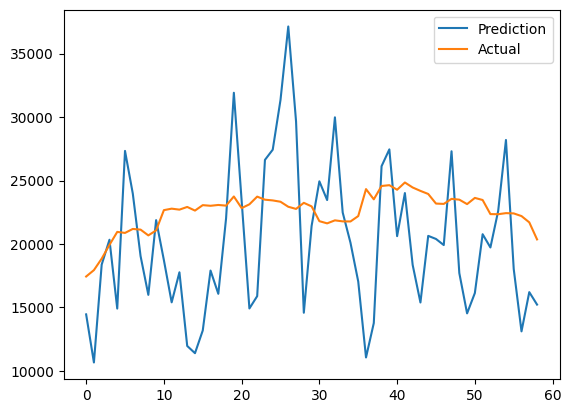

 mape: 0.22780046048612076,
wape: 0.7709436900199654,
mae: 5158.435646848517,
 mpe: -0.10317385680997841,
 rmse: 6150.05557695211,
 corr: 0.19901318117199696,
r2_score:-15.751979012615102 minmax: 


(0.22780046048612076,
 0.7709436900199654,
 5158.435646848517,
 -0.10317385680997841,
 6150.05557695211,
 0.19901318117199696,
 -15.751979012615102)

In [ ]:
model_1440_min_diff = load_model(f'model_{mins}_min_diff/')
get_predictions(model_1440_min_diff, X_n_test, y_n_test, 'Test', unsmooth=True)

### Try to use for prediction 1 minute model

2/2 [==============================] - 0s 8ms/step
    Test Predictions   Actuals
0       17485.154297  17440.64
1       17932.537109  17943.26
2       18363.066406  18846.62
3       18836.410156  19930.01
4       19960.460938  20952.76
5       20059.654297  20872.99
6       20405.779297  21185.65
7       20695.074219  21132.29
8       20566.318359  20677.47
9       20635.439453  21071.59
10      21234.031250  22666.00
11      21792.523438  22783.35
12      21655.697266  22706.02
13      21731.199219  22917.81
14      22224.824219  22631.94
15      22212.927734  23060.42
16      22519.556641  23009.65
17      22458.718750  23074.16
18      22496.691406  23021.40
19      22862.978516  23743.37
20      22663.314453  22827.38
21      22122.769531  23125.13
22      22792.179688  23731.41
23      22939.650391  23489.33
24      22622.128906  23431.90
25      22829.066406  23327.66
26      23040.988281  22932.91
27      22847.537109  22762.52
28      22903.957031  23242.42
29      22978.80664

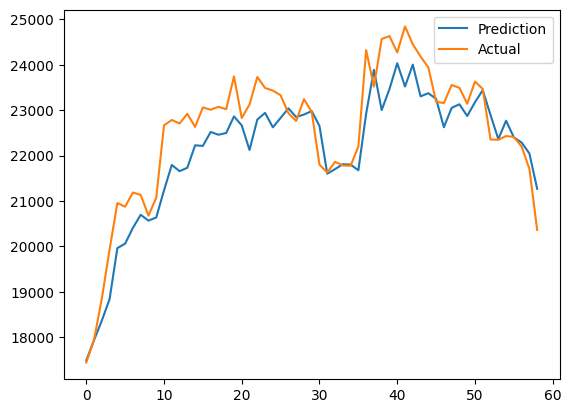

 mape: 0.023941973163292,
wape: 0.9757936890319244,
mae: 545.1353747351693,
 mpe: -0.017982414820904655,
 rmse: 686.1192461564956,
 corr: 0.9317085312653012,
r2_score:0.7914994317556204 minmax: 


(0.023941973163292,
 0.9757936890319244,
 545.1353747351693,
 -0.017982414820904655,
 686.1192461564956,
 0.9317085312653012,
 0.7914994317556204)

In [31]:
get_predictions(model_1_min_time_par4, X_n_test, y_n_test, 'Test', unsmooth=True)

There is a shift on the previous graph. So let's remove it

2/2 [==============================] - 0s 13ms/step


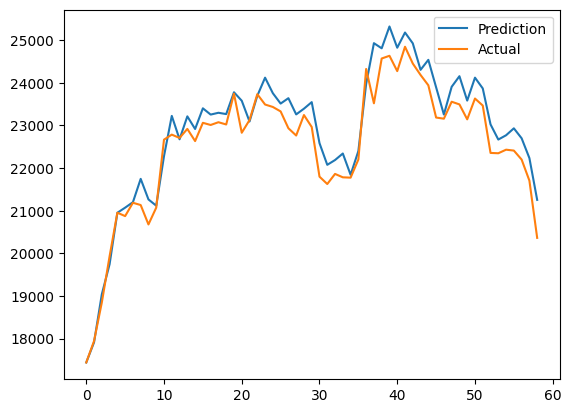

In [ ]:
preds = model_1_min_time_par4.predict(X_n_test).flatten()
diff = y_n_test[0] - preds[0]
preds += diff
preds = unsmooth_data(preds.reshape(-1, 1)).reshape(-1)
y = unsmooth_data(y_n_test.copy().reshape(-1, 1)).reshape(-1)
plt.plot(preds, label='Prediction')
plt.plot(y, label='Actual')
plt.legend()
plt.show()

In [ ]:
output_stats(preds, y)

 mape: 0.016681629311879213,
wape: 0.9831894884741134,
mae: 378.5791445974576,
 mpe: 0.015088334633226935,
 rmse: 463.73351537760516,
 corr: 0.981136926511337,
r2_score:0.9047543809403655 minmax: 


(0.016681629311879213,
 0.9831894884741134,
 378.5791445974576,
 0.015088334633226935,
 463.73351537760516,
 0.981136926511337,
 0.9047543809403655)

# Let's check prediction of a price difference

### For 1 minute

In [ ]:
mins = 1

X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(
    parsed_klines, mins,
    df_start=430000,
    columns=[A_DIF, HPR, LPR, VOL, TN, TAKER],
    smoothing_window_size=200000
)

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER, Difference, Direction, Absolute Difference]
Index: []


In [ ]:
conv_neurons, kernel_size, mins = 4, 3, 1
build_compile_fit_model(conv_neurons, kernel_size,
                        24, 0.001,
                        f'model_{mins}_min_diff/', 10,
                        X_n_train, y_n_train, X_n_val, y_n_val)

150 6
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 148, 4)            76        
                                                                 
 flatten (Flatten)           (None, 592)               0         
                                                                 
 dense (Dense)               (None, 1)                 593       
                                                                 
Total params: 669
Trainable params: 669
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3742/3748 [============================>.] - ETA: 0s - loss: 1.8199e-04 - root_mean_squared_error: 0.0135

3748/3748 [==============================] - 15s 4ms/step - loss: 1.8182e-04 - root_mean_squared_error: 0.0135 - val_loss: 1.6104e-04 - val_root_mean_squared_error: 0.0127
Epoch 2/10
3738/3748 [============================>.] - ETA: 0s - loss: 9.7695e-05 - root_mean_squared_error: 0.0099

3748/3748 [==============================] - 12s 3ms/step - loss: 9.7725e-05 - root_mean_squared_error: 0.0099 - val_loss: 1.3741e-04 - val_root_mean_squared_error: 0.0117
Epoch 3/10
3727/3748 [============================>.] - ETA: 0s - loss: 9.3198e-05 - root_mean_squared_error: 0.0097

3748/3748 [==============================] - 13s 4ms/step - loss: 9.3089e-05 - root_mean_squared_error: 0.0096 - val_loss: 1.2959e-04 - val_root_mean_squared_error: 0.0114
Epoch 4/10
3726/3748 [============================>.] - ETA: 0s - loss: 9.0879e-05 - root_mean_squared_error: 0.0095

3748/3748 [==============================] - 16s 4ms/step - loss: 9.0595e-05 - root_mean_squared_error: 0.0095 - val_loss: 1.1966e-04 - val_root_mean_squared_error: 0.0109
Epoch 5/10
3748/3748 [==============================] - 27s 7ms/step - loss: 8.8103e-05 - root_mean_squared_error: 0.0094 - val_loss: 1.2703e-04 - val_root_mean_squared_error: 0.0113
Epoch 6/10
3748/3748 [==============================] - 16s 4ms/step - loss: 8.7609e-05 - root_mean_squared_error: 0.0094 - val_loss: 1.2495e-04 - val_root_mean_squared_error: 0.0112
Epoch 7/10
3748/3748 [==============================] - 13s 3ms/step - loss: 8.7203e-05 - root_mean_squared_error: 0.0093 - val_loss: 1.7110e-04 - val_root_mean_squared_error: 0.0131
Epoch 8/10
3739/3748 [============================>.] - ETA: 0s - loss: 8.6063e-05 - root_mean_squared_error: 0.0093

3748/3748 [==============================] - 13s 4ms/step - loss: 8.5961e-05 - root_mean_squared_error: 0.0093 - val_loss: 1.1750e-04 - val_root_mean_squared_error: 0.0108
Epoch 9/10
3748/3748 [==============================] - 12s 3ms/step - loss: 8.5226e-05 - root_mean_squared_error: 0.0092 - val_loss: 1.8028e-04 - val_root_mean_squared_error: 0.0134
Epoch 10/10
3746/3748 [============================>.] - ETA: 0s - loss: 8.5010e-05 - root_mean_squared_error: 0.0092

3748/3748 [==============================] - 12s 3ms/step - loss: 8.4988e-05 - root_mean_squared_error: 0.0092 - val_loss: 1.1584e-04 - val_root_mean_squared_error: 0.0108


1250/1250 [==============================] - 2s 2ms/step
       Test Predictions   Actuals
0              0.008965  0.005494
1              0.008089  0.003792
2              0.006321  0.019549
3              0.010921  0.000075
4              0.007997  0.001802
...                 ...       ...
39965          0.002422  0.006333
39966          0.005813  0.010776
39967          0.011386  0.004105
39968          0.008971  0.011940
39969          0.006817  0.004543

[39970 rows x 2 columns]


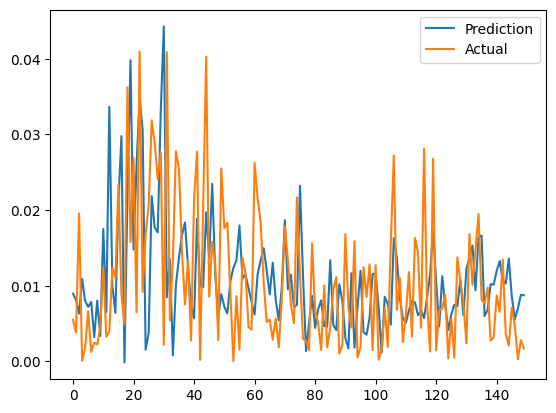

 mape: inf,
wape: 0.4127463334610926,
mae: 0.006570730631537168,
 mpe: inf,
 rmse: 0.010181932072555376,
 corr: 0.6827076089549747,
r2_score:0.46496012138510445 minmax: 


(inf,
 0.4127463334610926,
 0.006570730631537168,
 inf,
 0.010181932072555376,
 0.6827076089549747,
 0.46496012138510445)

In [ ]:
model_1_min_diff = load_model(f'model_{mins}_min_diff/')
get_predictions(model_1_min_diff, X_n_test, y_n_test, 'Test', unsmooth=False)

1250/1250 [==============================] - 2s 2ms/step
       Test Predictions  Actuals
0              7.163520     4.39
1              6.463504     3.03
2              5.050324    15.62
3              8.725743     0.06
4              6.389766     1.44
...                 ...      ...
39965          1.934896     5.06
39966          4.644527     8.61
39967          9.097969     3.28
39968          7.168069     9.54
39969          5.447124     3.63

[39970 rows x 2 columns]


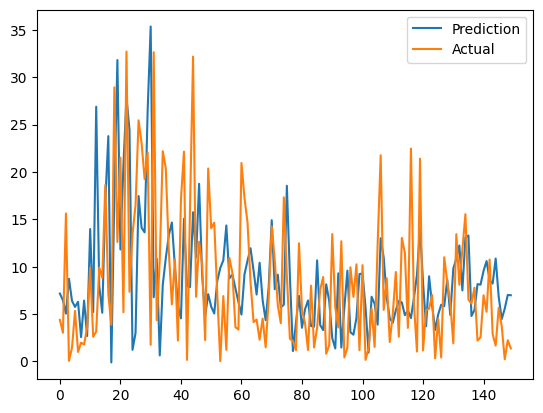

 mape: inf,
wape: 0.4127463334967023,
mae: 5.250145188892475,
 mpe: inf,
 rmse: 8.135567364708562,
 corr: 0.6827076089366048,
r2_score:0.4649601213725614 minmax: 


(inf,
 0.4127463334967023,
 5.250145188892475,
 inf,
 8.135567364708562,
 0.6827076089366048,
 0.4649601213725614)

In [ ]:
model_1_min_diff = load_model(f'model_{mins}_min_diff/')
smooth_data(parsed_klines[A_DIF][430000:630000].copy().values.reshape(-1, 1), smoothing_window_size=200000)
get_predictions(model_1_min_diff, X_n_test, y_n_test, 'Test', unsmooth=True)

### For 1 day

In [ ]:
mins = 60*24

X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(
    parsed_klines, mins,
    df_start=0, df_size=700000,
    columns=[A_DIF, HPR, LPR, VOL, TN, TAKER],
    smoothing_window_size=700000
)

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER, Difference, Direction, Absolute Difference]
Index: []


2/2 [==============================] - 0s 6ms/step
    Test Predictions  Actuals
0         189.437134   504.89
1         248.853729   910.80
2         654.316406  1077.09
3         491.270264  1029.40
4         636.333008    84.68
5         252.624176   307.81
6         474.822388    46.20
7         397.936066   460.33
8         583.669006   403.99
9         336.946442  1607.87
10        583.558960    88.39
11        672.571594    60.13
12        497.411987   200.42
13        492.867218   283.96
14        491.347321   442.75
15        534.976440    61.25
16        394.953705    54.82
17        392.343506    41.07
18         34.702385   724.39
19        422.611389   920.96
20        428.904083   297.25
21        358.788757   585.34
22        551.492554   264.80
23        630.858032    17.62
24        536.629639   109.44
25        164.813309   392.03
26        309.761719   175.91
27        351.277710   491.97
28        557.477234   296.43
29        447.675781  1159.10
30        580.88757

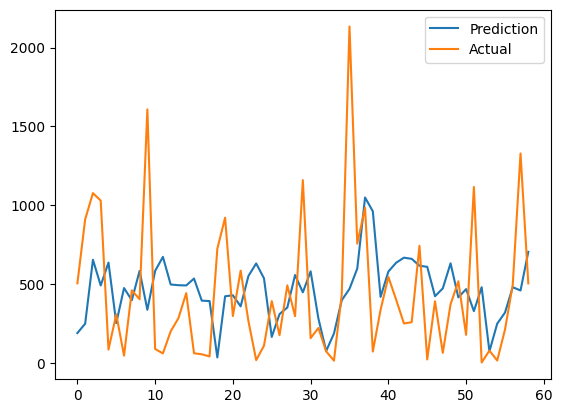

 mape: 6.128171932160198,
wape: 0.19299124588286032,
mae: 352.565300592972,
 mpe: 5.802437398291308,
 rmse: 470.6144859041748,
 corr: 0.004538147633586234,
r2_score:-0.19198473208211908 minmax: 


(6.128171932160198,
 0.19299124588286032,
 352.565300592972,
 5.802437398291308,
 470.6144859041748,
 0.004538147633586234,
 -0.19198473208211908)

In [ ]:
model_1_min_diff = load_model(f'model_1_min_diff/')
smooth_data(agg_to_freq_data(parsed_klines.copy(), mins)[A_DIF].values.reshape(-1, 1), smoothing_window_size=700000)
get_predictions(model_1_min_diff, X_n_test, y_n_test, 'Test', unsmooth=True)

# Results

The results for price difference prediction are better than those for price prediction <br>

RMSE for price diff = **8.135**/**470.614** *1min/1day*<br>
RMSE for price pred = 18.885/686.119 *1min/1day*

Now find rmse of actual data to understand how good is the result

In [24]:
parsed_klines

,date,OPEN TIME,OPEN PRICE,HIGH PRICE,LOW PRICE,CLOSE PRICE,VOLUME,TRADES NUMBER,TAKER,Difference,Absolute Difference,Day Time sin,Day Time cos,Week Day sin,Week Day cos,Direction
0,2021-12-24 05:01:00,1640322060000,50931.91,50931.97,50876.70,50880.00,25.65137,1185.0,9.06440,-19.50,19.50,0.967046,0.254602,0.884406,0.466717,0
1,2021-12-24 05:02:00,1640322120000,50876.73,50880.00,50837.71,50837.71,16.19787,1201.0,6.86989,-55.18,55.18,0.968148,0.250380,0.884697,0.466166,0
2,2021-12-24 05:03:00,1640322180000,50840.81,50919.27,50837.71,50909.47,22.53036,1215.0,13.97411,-35.92,35.92,0.969231,0.246153,0.884988,0.465615,0
3,2021-12-24 05:04:00,1640322240000,50909.47,50931.95,50869.08,50880.26,14.09173,788.0,4.37506,68.66,68.66,0.970296,0.241922,0.885278,0.465063,1
4,2021-12-24 05:05:00,1640322300000,50885.58,50895.13,50850.00,50852.82,12.18793,945.0,3.02775,-23.89,23.89,0.971342,0.237686,0.885567,0.464511,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635867,2023-03-10 18:48:00,1678474080000,19924.80,19931.91,19909.00,19911.25,262.09242,6421.0,120.41953,-3.99,3.99,-0.978148,0.207912,0.999552,-0.029915,0
635868,2023-03-10 18:49:00,1678474140000,19912.20,19912.96,19886.76,19892.08,272.13501,6677.0,133.42091,-12.60,12.60,-0.977231,0.212178,0.999534,-0.030539,0
635869,2023-03-10 18:50:00,1678474200000,19892.61,19904.63,19885.80,19895.61,279.22393,6247.0,136.15247,-19.59,19.59,-0.976296,0.216440,0.999514,-0.031162,0
635870,2023-03-10 18:51:00,1678474260000,19896.19,19896.23,19871.03,19871.03,264.10529,6622.0,126.31206,3.58,3.58,-0.975342,0.220697,0.999495,-0.031785,1


In [25]:
output_stats(parsed_klines.loc[590001:630000, CPR].values, parsed_klines.loc[590000:629999, CPR].values)

 mape: 0.0003822306354120428,
wape: 0.9996145838044741,
mae: 8.935390250000015,
 mpe: -2.0838473688582146e-07,
 rmse: 14.260514005199827,
 corr: 0.9998985515847593,
r2_score:0.9997971022018036 minmax: 


(0.0003822306354120428,
 0.9996145838044741,
 8.935390250000015,
 -2.0838473688582146e-07,
 14.260514005199827,
 0.9998985515847593,
 0.9997971022018036)

In [26]:
day_klines = agg_to_freq_data(parsed_klines.copy(), 60*24)
day_klines

,date,OPEN TIME,OPEN PRICE,HIGH PRICE,LOW PRICE,CLOSE PRICE,VOLUME,TRADES NUMBER,TAKER,Difference,Absolute Difference,Day Time sin,Day Time cos,Week Day sin,Week Day cos,Direction
0,2021-12-24,1640322060000,50931.91,51810.00,50384.43,50820.00,23274.25072,839518.0,11277.88384,-179.35,179.35,9.670459e-01,0.254602,8.844065e-01,0.466717,0
1,2021-12-25,1640390400000,50819.99,51156.23,50142.32,50399.66,19135.51613,766979.0,9928.30266,-372.19,372.19,-9.638239e-12,1.000000,9.749279e-01,-0.222521,0
2,2021-12-26,1640476800000,50399.67,51280.00,49412.00,50775.49,22569.88914,797133.0,11285.69707,389.80,389.80,-1.989162e-11,1.000000,4.338837e-01,-0.900969,1
3,2021-12-27,1640563200000,50775.48,52088.00,50449.00,50701.44,28792.21566,1009411.0,14436.09322,-114.13,114.13,-1.559308e-11,1.000000,-4.338837e-01,-0.900969,0
4,2021-12-28,1640649600000,50701.44,50704.05,47313.01,47543.74,45853.33924,1345774.0,21743.17013,-3108.73,3108.73,-1.129454e-11,1.000000,-9.749279e-01,-0.222521,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,2023-03-06,1678060800000,22430.24,22602.19,22258.00,22410.00,203751.82957,6471278.0,102110.26304,-15.29,15.29,-1.267246e-11,1.000000,-4.338837e-01,-0.900969,0
438,2023-03-07,1678147200000,22409.41,22557.91,21927.00,22197.96,292519.80912,7813394.0,145498.64219,-211.15,211.15,-8.373925e-12,1.000000,-9.749279e-01,-0.222521,0
439,2023-03-08,1678233600000,22198.56,22287.00,21580.00,21705.44,301460.57272,8018963.0,150008.02488,-495.91,495.91,-1.862730e-11,1.000000,-7.818315e-01,0.623490,0
440,2023-03-09,1678320000000,21704.37,21834.99,20042.72,20362.22,443658.28584,10076702.0,217900.59621,-1328.54,1328.54,-1.432876e-11,1.000000,-4.878324e-13,1.000000,0


In [27]:
output_stats(day_klines.loc[383:441, CPR].values, day_klines.loc[382:440, CPR].values)

 mape: 0.019930409441873947,
wape: 0.9804777372751751,
mae: 439.6513559322033,
 mpe: 0.0025964103246912374,
 rmse: 615.839624009368,
 corr: 0.9126654586512831,
r2_score:0.8320180203516448 minmax: 


(0.019930409441873947,
 0.9804777372751751,
 439.6513559322033,
 0.0025964103246912374,
 615.839624009368,
 0.9126654586512831,
 0.8320180203516448)

As we can see the rmse model result for 1 minute almost **2 times less** than actual rmse <br>
At the same time the rmse of model for 1 day almost **1.5 times less** than actual rmse

# **END**

# P.S.

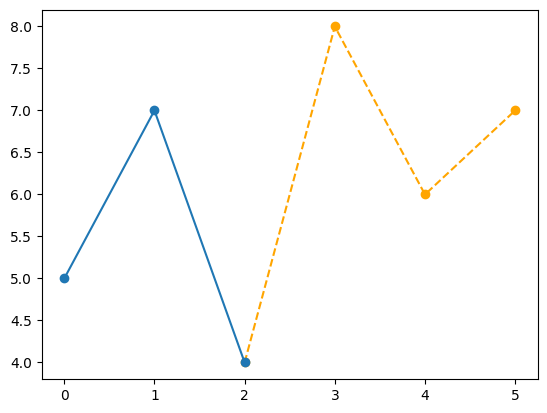

In [ ]:
import matplotlib.pyplot as plt


plt.plot([2, 3, 4, 5], [4, 8, 6, 7], linestyle='--', marker='o', color='orange')
plt.plot([0, 1, 2], [5, 7, 4], linestyle='-', marker='o')
plt.show()
